## A model build using TweetBERT to classify tweet as causal or non-causal 

The causal sentence prediction model will be trained in several steps using an active learning approach, where in each step the training dataset will be augmented.
In each step the causal sentence classifier is trained and applied on a subsample of unlabeled tweets to identify tweets with causal elements. Those tweets are then manually labeled for the two tasks: causal sentence prediction and cause-effect identification (NER). The newly labeled data will be added to the training dataset and the causal sentence classifier will be retrained with the augmented dataset to increase performance

In [84]:
import pandas as pd
import numpy as np
import spacy 
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import random
import os
import torch.nn.functional as F
import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, SubsetRandomSampler
import transformers
from tqdm import tqdm, trange
import io
from utils import normalizeTweet, split_into_sentences, EarlyStopping
import matplotlib.pyplot as plt

########################### Check if cuda available ############################
# print("Cuda available: ", torch.cuda.is_available())
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



########################### DATA FILE ###################################
# dataPath = "/home/adrian/workspace/causality/Causal-associations-diabetes-twitter/data/Causality_tweets_data.xlsx"
# dataPath = "data/Causality_tweets_data.xlsx"
dataPath = "Causality_tweets_data.xlsx"


########################### MODEL PARAMETERS ############################
active_learning_round = 3 # will change the saved model name 
lr = 1e-3    
adam_eps = 1e-8
epochs = 35
num_warmup_steps = 0
early_patience = 7# how long to wait after last time validation loss improved

train_batch_size = 16
val_batch_size = 16
test_batch_size = 16
test_to_train_ratio = 0.1 # 10% test and 90% train
val_to_train_ratio = 0.2

metrics_average = "binary" # this will give measure for class_1,i.e., causal class
#
# saveModelName = "./model-causal-model/model_1_finetuned-{}-epochs-lr_{}.pth".format(epochs, lr) # it should be epoch so that the name shows at what epoch teh mdel ws saved
finetuned_model = "./model-causal-model/model_2_finetuned-30-epochs-lr_0.001.pth" # load finetuned model from previous round to continue fine-tuning on new data

#### Checking if thec cuda is available and then select the `gpu`

In [85]:
########################### Check if cuda available ############################
print("Cuda available: ", torch.cuda.is_available())
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print("Selected {} for this notebook".format(device))

Cuda available:  True
Selected cuda:1 for this notebook


In [86]:
##### DATA TO LOAD ######

data_round0 = pd.read_excel(dataPath, sheet_name="round0")
data_round0 = data_round0[data_round0["Causal association"].notnull()] # some tweets at the end are not labeled yet
data_round0 = data_round0[["full_text", "Intent", "Cause", "Effect", "Causal association"]]
print("Data round 0 (tweets!):")
print(data_round0["Causal association"].value_counts())
print("-----"*5)


##### additional data labeled through active learning strategy - round 1 ########
data_round1 = pd.read_excel(dataPath, sheet_name="round1")
data_round1 = data_round1[data_round1["Causal association"].notnull()]
data_round1 = data_round1[["sentence", "Intent", "Cause", "Effect", "Causal association"]]
data_round1.rename(columns ={"sentence":"full_text"}, inplace=True) # rename for merge
print("Sentences round 1:")
print(data_round1["Causal association"].value_counts())
print("-----"*5)

##### additional data labeled through active learning strategy - round 2 ########
data_round2 = pd.read_excel(dataPath, sheet_name="round2")
data_round2 = data_round2[data_round2["Causal association"].notnull()]
data_round2 = data_round2[["sentence", "Intent", "Cause", "Effect", "Causal association"]]
data_round2.rename(columns ={"sentence":"full_text"}, inplace=True) # rename for merge
print("sentences round 2:")
print(data_round2["Causal association"].value_counts())
print("-----"*5)
#### merge datasets ######
data_old = data_round0.append(data_round1).append(data_round2)
print("\nAfter merge old data:")
print(data_old["Causal association"].value_counts())
data_old.head()
print("-----"*5)

##### new additional data labeled through active learning strategy - round 3 (model is only retrained with this data) #####################
data_round3 = pd.read_excel(dataPath, sheet_name="round3")
data_round3 = data_round3[data_round3["Causal association"].notnull()]
data_round3 = data_round3[["sentence", "Intent", "Cause", "Effect", "Causal association"]]
data_round3.rename(columns ={"sentence":"full_text"}, inplace=True) # rename for merge
data_new = data_round3
print("sentences round 3:")
print(data_new["Causal association"].value_counts())

print("----"*5)
print(" 0:non causal tweet \n 1: causal tweet.\n \n each tweet may have more than one sentence and we are splitting them and labelling by checking if cause or effect occur in them or not")

Data round 0 (tweets!):
0.0    3710
1.0    1290
Name: Causal association, dtype: int64
-------------------------
Sentences round 1:
0.0    1763
1.0     429
Name: Causal association, dtype: int64
-------------------------
sentences round 2:
0    1658
1     150
Name: Causal association, dtype: int64
-------------------------

After merge old data:
0.0    7131
1.0    1869
Name: Causal association, dtype: int64
-------------------------
sentences round 3:
0    1886
1     215
Name: Causal association, dtype: int64
--------------------
 0:non causal tweet 
 1: causal tweet.
 
 each tweet may have more than one sentence and we are splitting them and labelling by checking if cause or effect occur in them or not


### Preprocessing

In [87]:
def get_start_end_index_of_sentence_in_tweet(tweet, sentence):
    """ 
    The sentence tokens are included in the tweet tokens.
    Return the start end end indices of the sentence tokens in the tweet tokens

    """

    sentence_start_word = sentence[0]
    start_indices = [i for i, x in enumerate(tweet) if x == sentence_start_word] # find all indices of the start word of the sentence 
    try:
        for start_index in start_indices:
            isTrueStartIndex = all([tweet[start_index+i] == sentence[i] for i in range(len(sentence))])
            #print("start_index:", start_index, "isTrueStartIndex:", isTrueStartIndex)
            if isTrueStartIndex:
                return start_index, start_index + len(sentence) 
    except:
        print("ERROR: StartIndex should have been found for sentence:")
        print("tweet:")
        print(tweet)
        print("sentence:")
        print(sentence)
    return -1, -2 # should not be returned


def split_tweets_to_sentences(data):
    """ 
        Splits tweets into sentences and associates the appropriate intent, causes, effects and causal association
        to each sentence.
        
        Parameters:
        - min_words_in_sentences: Minimal number of words in a sentence such that the sentence is kept. 
                                  Assumption: A sentence with too few words does not have enough information
                              
                              
                              
        Ex.:
        full_text                              | Intent | Cause | Effect | Causal association | ...
        --------------------------------------------------------------------------------------------
        what? type 1 causes insulin dependence | q;msS  | type 1|insulin dependence | 1       | ...  
        
        New dataframe returned: 
        full_text                              | Intent | Cause | Effect | Causal association | ...
        --------------------------------------------------------------------------------------------
        what?                                  |   q    |       |        |       0            | ...
        type 1 causes insulin dependence       |        | type 1| insulin dependence | 1       | ...  
    """

    newDF = pd.DataFrame(columns=["sentence", "Intent", "Cause", "Effect", "Causal association", "tokenized"])
    
    for i,row in data.iterrows():
        causes = row["Cause"]
        effects = row["Effect"]
        sentences = split_into_sentences(normalizeTweet(row["full_text"]))
        
        # single sentence in tweet
        if len(sentences) == 1:
            singleSentenceIntent = ""
            if isinstance(row["Intent"], str):
                if len(row["Intent"].split(";")) > 1:
                    singleSentenceIntent = row["Intent"].strip().replace(";msS", "").replace("msS;", "").replace(";mS", "").replace("mS;", "")
                else:
                    if row["Intent"] == "mS" or row["Intent"] == "msS":
                        singleSentenceIntent = ""
                    else:
                        singleSentenceIntent = row["Intent"].strip()
                    
            newDF=newDF.append(pd.Series({"sentence": sentences[0] # only one sentence
                         , "Intent": singleSentenceIntent
                         , "Cause" : row["Cause"]
                         , "Effect": row["Effect"]
                         , "Causal association" : row["Causal association"]
                         , "tokenized": row["tokenized"]}), ignore_index=True)
        
        # tweet has several sentences
        else: 
            intents = str(row["Intent"]).strip().split(";")
            for sentence in sentences:
                sent_tokenized = sentence.split(" ")
                causeInSentence = np.nan if not isinstance(causes, str) or not any([cause in sentence for cause in causes.split(";")]) else ";".join([cause for cause in causes.split(";") if cause in sentence])
                effectInSentence = np.nan if not isinstance(effects, str) or not any([effect in sentence for effect in effects.split(";")]) else ";".join([effect for effect in effects.split(";") if effect in sentence])
                causalAssociationInSentence = 1 if isinstance(causeInSentence, str) and isinstance(effectInSentence, str) else 0
                startIndex, endIndex = get_start_end_index_of_sentence_in_tweet(row["tokenized"], sent_tokenized)
                sentence_tokenized = row["tokenized"][startIndex:endIndex]
                
                if "q" in intents and sentence[-1] == "?": # if current sentence is question
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": "q", "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)                    
                elif "joke" in intents: # all sentences with "joke" in tweet keep the intent "joke"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": "joke", "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)   
                elif "neg" in intents: # all sentences with "neg" in tweet keep intent "neg"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": "neg", "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)               
                elif isinstance(causeInSentence, str) and isinstance(effectInSentence, str): # cause effect sentence
                    causalIntent = ""
                    if len(causeInSentence.split(";")) > 1:
                        causalIntent = "mC"
                        if len(effectInSentence.split(";")) > 1:
                            causalIntent = "mC;mE"
                    elif len(effectInSentence.split(";")) > 1:
                        causalIntent = "mE"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": causalIntent, "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)                                  
                else:
                    nonCausalIntent = ""
                    if isinstance(causeInSentence, str): # only cause is given
                        if len(causeInSentence.split(";")) > 1:
                            nonCausalIntent = "mC"
                    elif isinstance(effectInSentence, str): # only effect is given
                        if len(effectInSentence.split(";")) > 1:
                            nonCausalIntent = "mE"
                    newDF=newDF.append(pd.Series({"sentence": sentence, "Intent": nonCausalIntent, "Cause" : causeInSentence
                                                , "Effect": effectInSentence, "Causal association" : causalAssociationInSentence
                                                , "tokenized": sentence_tokenized}), ignore_index=True)

    return newDF

In [88]:
### Split tweets into sentences (train classifier on sentence level) ####

print("Count of  tweets old:", data_old.shape[0])
print("Count of  tweets new:", data_new.shape[0])

data_old["tokenized"] = data_old["full_text"].map(lambda tweet: normalizeTweet(tweet).split(" "))
dataSentences_old = split_tweets_to_sentences(data_old)
print("Count of sentences old:", dataSentences_old.shape[0])


data_new["tokenized"] = data_new["full_text"].map(lambda tweet: normalizeTweet(tweet).split(" "))
dataSentences_new = split_tweets_to_sentences(data_new)
print("Count of sentences new:", dataSentences_new.shape[0])
dataSentences_new.head()

Count of  tweets old: 9000
Count of  tweets new: 2101
Count of sentences old: 15756
Count of sentences new: 2101


,sentence,Intent,Cause,Effect,Causal association,tokenized
0,I got super sick the last day I was in Mexico ...,,NaN,NaN,0,"[I, got, super, sick, the, last, day, I, was, ..."
1,"@USER @USER I know this is just twitter , but ...",mC;mE,type 1 diabetic;low blood sugar,die;sad,1,"[@USER, @USER, I, know, this, is, just, twitte..."
2,While I was lifting today spotify reminded me ...,,NaN,NaN,0,"[While, I, was, lifting, today, spotify, remin..."
3,@USER Many already send for private finger pri...,mC,finger prick tests;medicine,alive,1,"[@USER, Many, already, send, for, private, fin..."
4,"@USER @USER Speaking of testimony , I beat typ...",,Daniel diet,beat type 2 diabetes,1,"[@USER, @USER, Speaking, of, testimony, ,, I, ..."


In [89]:
########## Remove sentences with joke, question, negation and keep only sentences with more than 3 tokens #####

print("Count ofsentences old before filtering: ", dataSentences_old.shape[0])
dataSentFiltered_old = dataSentences_old[~dataSentences_old["Intent"].str.contains("neg|joke|q")] 
dataSentFiltered_old = dataSentFiltered_old[dataSentFiltered_old["tokenized"].map(len) > 3] 
print("Count of sentences old after filtering: ", dataSentFiltered_old.shape[0])
print("\n")
print("Distribution old:")
print(dataSentFiltered_old["Causal association"].value_counts())
print("----"*5)

print("Count of sentences new before filtering: ", dataSentences_new.shape[0])
dataSentFiltered_new = dataSentences_new[~dataSentences_new["Intent"].str.contains("neg|joke|q")] 
dataSentFiltered_new = dataSentFiltered_new[dataSentFiltered_new["tokenized"].map(len) > 3] 
print("Count of sentences new after filtering: ", dataSentFiltered_new.shape[0])
print("Distribution new:")
print("\n")
print(dataSentFiltered_new["Causal association"].value_counts())
dataSentFiltered_new.head()



Count ofsentences old before filtering:  15756
Count of sentences old after filtering:  12229


Distribution old:
0.0    10625
1.0     1604
Name: Causal association, dtype: int64
--------------------
Count of sentences new before filtering:  2101
Count of sentences new after filtering:  2056
Distribution new:


0    1855
1     201
Name: Causal association, dtype: int64


,sentence,Intent,Cause,Effect,Causal association,tokenized
0,I got super sick the last day I was in Mexico ...,,NaN,NaN,0,"[I, got, super, sick, the, last, day, I, was, ..."
1,"@USER @USER I know this is just twitter , but ...",mC;mE,type 1 diabetic;low blood sugar,die;sad,1,"[@USER, @USER, I, know, this, is, just, twitte..."
2,While I was lifting today spotify reminded me ...,,NaN,NaN,0,"[While, I, was, lifting, today, spotify, remin..."
3,@USER Many already send for private finger pri...,mC,finger prick tests;medicine,alive,1,"[@USER, Many, already, send, for, private, fin..."
4,"@USER @USER Speaking of testimony , I beat typ...",,Daniel diet,beat type 2 diabetes,1,"[@USER, @USER, Speaking, of, testimony, ,, I, ..."


### Data split and calculate class weight

In [90]:
####################### Stratified splits ####################


## ONLY FOR TESTING ---------------
#dataSentFiltered = dataSentFiltered[0:500] # for testing

text_old = dataSentFiltered_old["sentence"].map(normalizeTweet).values.tolist()
labels_old = dataSentFiltered_old["Causal association"].values.tolist()

# first split the data into training and testing label in the ratio of 90:10
train_texts_old, test_texts, train_labels_old, test_labels = train_test_split(text_old, labels_old, test_size=test_to_train_ratio, stratify=labels_old, random_state=9)
train_texts_old, val_texts, train_labels_old, val_labels = train_test_split(train_texts, train_labels, test_size=val_to_train_ratio, stratify=train_labels, random_state=9)

# Redefine training set:Take only new labeled tweets from round 3 for training; test and val set come from old data
train_texts = dataSentFiltered_new["sentence"].map(normalizeTweet).values.tolist()
train_labels = dataSentFiltered_new["Causal association"].values.tolist()

labels = train_labels + val_labels +test_labels # combining new train with validataion and test data from previous rounds


data_count_info = pd.Series(labels).value_counts(normalize=True)
train_count_info = pd.Series(train_labels).value_counts(normalize=True)
val_count_info = pd.Series(val_labels).value_counts(normalize=True)
test_count_info = pd.Series(test_labels).value_counts(normalize=True)

# for class-imbalanced dataset, the class weight for a ith class
# to be specified for balancing in the loss function is given by:
# weight[i] = num_samples / (num_classes * num_samples[i])
# since train_count_info obtained above has fraction of samples
# for ith class, hence the corresponding weight calculation is:
class_weight = (1/train_count_info)/len(train_count_info)

print("All: Count = {}, % of 0 = {}, % of 1 = {}".format(len(labels), *data_count_info.round(4).to_list()))
print("\n")
print("Train: Count = {}, % of 0 = {}, % of 1 = {}".format(len(train_labels), *train_count_info.round(4).to_list()))
print("\n")
print("Val: Count = {}, % of 0 = {}, % of 1 = {}".format(len(val_labels), *val_count_info.round(4).to_list()))
print("\n")
print("Test: Count = {}, % of 0 = {}, % of 1 = {}".format(len(test_labels), *test_count_info.round(4).to_list()))
print("\n")
print("Balancing class wts: for 0 = {}, for 1 = {}".format(*class_weight.round(4).to_list()))
print("\n")

All: Count = 3691, % of 0 = 0.8914, % of 1 = 0.1086


Train: Count = 2056, % of 0 = 0.9022, % of 1 = 0.0978


Val: Count = 412, % of 0 = 0.9029, % of 1 = 0.0971


Test: Count = 1223, % of 0 = 0.8692, % of 1 = 0.1308


Balancing class wts: for 0 = 0.5542, for 1 = 5.1144




#### Defining our DataLoader 

In [91]:
class TweetDataSet(torch.utils.data.Dataset):
    def __init__(self, text, labels, tokenizer):
        self.text = text
        self.labels = labels
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        inputs = self.tokenizer(self.text, padding=True, truncation=True, return_token_type_ids=True)
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]
        return {
                "input_ids" : torch.tensor(ids[idx], dtype=torch.long)
              , "attention_mask" : torch.tensor(mask[idx], dtype=torch.long)
              , "token_type_ids" : torch.tensor(token_type_ids[idx], dtype=torch.long)
              , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
        }      

    def __len__(self):
        return len(self.labels)

    
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")

train_dataset = TweetDataSet(train_texts, train_labels, tokenizer)
val_dataset = TweetDataSet(val_texts, val_labels, tokenizer)
test_dataset = TweetDataSet(test_texts, test_labels, tokenizer)
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

# During training: In each epoch one part of the training data will be used as validation set
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


2056
412
1223


### Evaluation Metrics

In [92]:
## we are measuring weighted metrics - as our dataset is imbalanced 
# Calculate metrics for each label, and find their average weighted by support
# (the number of true instances for each label). 
# This alters ‘macro’ to account for label imbalance; 
# it can result in an F-score that is not between precision and recall.


from sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef

def compute_metrics(pred, labels):
#     precision, recall, f1, _ = precision_recall_fscore_support(labels, pred, average='weighted')
    precision, recall, f1, _ = precision_recall_fscore_support(labels,pred, average=metrics_average)
    acc = accuracy_score(labels, pred)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }



### Model defintion

In [93]:


class CausalityBERT(torch.nn.Module):
    """ Model Bert"""
    def __init__(self):
        super(CausalityBERT, self).__init__()
        self.num_labels = 2
        self.bert = transformers.BertModel.from_pretrained("vinai/bertweet-base")
        self.dropout = torch.nn.Dropout(0.3)
        self.linear1 = torch.nn.Linear(768, 256)
        self.linear2 = torch.nn.Linear(256, self.num_labels)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, output_1 = self.bert(input_ids, attention_mask = attention_mask, token_type_ids=token_type_ids, return_dict=False) # if output 1 is our cls token        
        output_2 = self.dropout(output_1)
        output_3 = self.linear1(output_2)  
        output_4 = self.dropout(output_3)
        output_5 = self.linear2(output_4)
        return output_5

### Moving the model to  GPU and defining training parameters: 
    * num_training_steps 
    * optimizers 
    * scheduler 
    * loss funciton (weighted) 

In [94]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = CausalityBERT() ## just load the model trained in previous round here 
model.load_state_dict(torch.load(finetuned_model, map_location='cpu')) # load model trained in previous round
model.to(device)

# fine-tune only the task-specific parameters
for param in model.bert.parameters():
    param.requires_grad = False

num_training_steps = np.ceil(len(train_dataset)/train_batch_size)*epochs
optim = AdamW(model.parameters(), lr=lr, eps=adam_eps)
scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps) # scheduler with a linearly decreasing learning rate from the initial lr set in the optimizer to 0; after a warmup period durnig which it increases linearly from 0 to the initial lr set in the optimizer

## penalising more for class with less number of exaplmes 
loss_fn = CrossEntropyLoss(torch.tensor(class_weight.to_list()).to(device))

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing BertModel: ['roberta.encoder.layer.6.attention.self.key.bias', 'roberta.encoder.layer.0.output.dense.bias', 'roberta.encoder.layer.1.attention.self.key.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.2.attention.self.key.bias', 'roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.intermediate.dense.weight', 'roberta.encoder.layer.7.output.LayerNorm.weight', 'roberta.encoder.layer.1.intermediate.dense.bias', 'roberta.encoder.layer.9.attention.output.dense.weight', 'roberta.encoder.layer.9.attention.output.LayerNorm.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'roberta.encoder.layer.1.output.dense.weight', 'robe

### Training (fine-tuning) with Validation and early stopping 

In [102]:
############ TRAINING #############

# initialise the early_stopping object
# early_stopping = EarlyStopping(patience=early_patience, path=saveModelName, verbose=True)
early_stopping = EarlyStopping(patience=early_patience,verbose=True)


train_avg_loss = [] # avg training loss per epoch
val_avg_loss = [] # avg validation loss per epoch
train_avg_acc = [] # avg training accuracy per epoch
val_avg_acc = [] # avg val accuracy per epoch
n_trained_epochs = 0


for epoch in trange(1, epochs+1, desc='Epoch'):
    print("<" + "="*22 + F" Epoch {epoch} "+ "="*22 + ">")
    
    
    ########### training eval metrics #############################
    train_accuracy = []
    train_loss = []
    train_acc = []
    train_prec = []
    train_rec = []
    train_f1 = []
    
    ###################################################
    
    for batch in tqdm(train_loader):
        optim.zero_grad() # gradients get accumulated by default -> clear previous accumulated gradients
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels = batch['labels'].to(device)
        ###########################################################################
        model.train()
        logits = model(**{"input_ids":input_ids, "attention_mask":attention_mask, "token_type_ids":token_type_ids}) # forward pass
        #############################################################################
        loss = loss_fn(logits, labels)
        print("loss:", loss)
        loss.backward() # backward pass
        optim.step()    # update parameters and take a step up using the computed gradient
        scheduler.step()# update learning rate scheduler
        train_loss.append(loss.item())
        
    
        ############# Training Accuracy Measure ###################################

        # move logits and labels to CPU
        logits = logits.detach().to('cpu').numpy()
        label_ids = labels.to('cpu').numpy()

        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()

        metrics = compute_metrics(pred_flat, labels_flat)        
        
        train_acc.append(metrics["accuracy"])
        train_prec.append(metrics["precision"])
        train_rec.append(metrics["recall"])
        train_f1.append(metrics["f1"])
        
    train_avg_loss.append(np.mean(train_loss))
    train_avg_acc.append(np.mean(train_acc))
    print(F'\n\tTrain loss: {np.mean(train_loss)}')
    print(F'\n\ttrain acc: {np.mean(train_acc)}')
    print(F'\n\ttraining prec: {np.mean(train_prec)}')
    print(F'\n\ttraining rec: {np.mean(train_rec)}')
    print(F'\n\ttraining f1: {np.mean(train_f1)}')
    
    n_trained_epochs += 1
    
    ###################################################################################

    
    ## ---- Validation ------
    val_accuracy = []
    val_loss = []
    val_acc = []
    val_prec = []
    val_rec = []
    val_f1 = []
    
    
    # Evaluate data for one epoch
    for batch in tqdm(validation_loader):
        batch = tuple(batch[t].to(device) for t in batch)      # batch to GPU
        b_input_ids, b_input_mask, b_token_type_ids, b_labels = batch     # unpack inputs from dataloader
        
        with torch.no_grad(): # tell model not to compute or store gradients -> saves memory + speeds up validation
            ##################################################################################
            model.eval()
            logits = model(**{"input_ids":b_input_ids, "attention_mask":b_input_mask, "token_type_ids":b_token_type_ids}) # forward pass, calculates logit predictions 

                        
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())
        
        # move logits and labels to CPU
        logits = logits.detach().to('cpu').numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        
        metrics = compute_metrics(pred_flat, labels_flat)
        val_acc.append(metrics["accuracy"])
        val_prec.append(metrics["precision"])
        val_rec.append(metrics["recall"])
        val_f1.append(metrics["f1"])

    val_avg_loss.append(np.mean(val_loss))
    val_avg_acc.append(np.mean(val_acc))
    print(F'\n\tValidation loss: {np.mean(val_loss)}')
    print(F'\n\tValidation acc: {np.mean(val_acc)}')
    print(F'\n\tValidation prec: {np.mean(val_prec)}')
    print(F'\n\tValidation rec: {np.mean(val_rec)}')
    print(F'\n\tValidation f1: {np.mean(val_f1)}')

    # early_stopping needs the validation loss to check if it has decreased,
    # and if it has, it will make a checkpoint of the current model
    saveModelName = "./model-causal-model/model_{}_finetuned-{}-epochs-lr_{}.pth".format(active_learning_round,n_trained_epochs-early_patience, lr) 
    early_stopping.path = saveModelName
    early_stopping(np.average(val_loss), model)
    
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch:   0%|          | 0/35 [00:00<?, ?it/s]

<====================== Epoch 1 ======================>



  1%|          | 1/129 [00:01<04:11,  1.96s/it]

loss: tensor(0.4404, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 2/129 [00:03<04:08,  1.96s/it]

loss: tensor(0.6705, device='cuda:1', grad_fn=<NllLossBackward>)



  2%|▏         | 3/129 [00:05<03:58,  1.89s/it]

loss: tensor(0.5736, device='cuda:1', grad_fn=<NllLossBackward>)



  3%|▎         | 4/129 [00:07<03:58,  1.91s/it]

loss: tensor(0.3326, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 5/129 [00:09<03:51,  1.87s/it]

loss: tensor(0.3907, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▍         | 6/129 [00:11<03:46,  1.84s/it]

loss: tensor(0.6800, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  5%|▌         | 7/129 [00:13<03:47,  1.87s/it]

loss: tensor(0.3665, device='cuda:1', grad_fn=<NllLossBackward>)



  6%|▌         | 8/129 [00:14<03:42,  1.84s/it]

loss: tensor(0.5990, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  7%|▋         | 9/129 [00:16<03:43,  1.86s/it]

loss: tensor(0.1858, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  8%|▊         | 10/129 [00:18<03:39,  1.84s/it]

loss: tensor(0.8924, device='cuda:1', grad_fn=<NllLossBackward>)



  9%|▊         | 11/129 [00:20<03:41,  1.87s/it]

loss: tensor(0.2659, device='cuda:1', grad_fn=<NllLossBackward>)



  9%|▉         | 12/129 [00:22<03:37,  1.86s/it]

loss: tensor(0.6684, device='cuda:1', grad_fn=<NllLossBackward>)



 10%|█         | 13/129 [00:24<03:40,  1.90s/it]

loss: tensor(0.6180, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 14/129 [00:26<03:37,  1.89s/it]

loss: tensor(0.3844, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 12%|█▏        | 15/129 [00:28<03:39,  1.92s/it]

loss: tensor(0.5668, device='cuda:1', grad_fn=<NllLossBackward>)



 12%|█▏        | 16/129 [00:30<03:34,  1.90s/it]

loss: tensor(0.4155, device='cuda:1', grad_fn=<NllLossBackward>)



 13%|█▎        | 17/129 [00:31<03:31,  1.88s/it]

loss: tensor(0.5036, device='cuda:1', grad_fn=<NllLossBackward>)



 14%|█▍        | 18/129 [00:33<03:32,  1.91s/it]

loss: tensor(0.6516, device='cuda:1', grad_fn=<NllLossBackward>)



 15%|█▍        | 19/129 [00:35<03:26,  1.88s/it]

loss: tensor(0.5844, device='cuda:1', grad_fn=<NllLossBackward>)



 16%|█▌        | 20/129 [00:37<03:26,  1.90s/it]

loss: tensor(0.9405, device='cuda:1', grad_fn=<NllLossBackward>)



 16%|█▋        | 21/129 [00:39<03:21,  1.87s/it]

loss: tensor(0.4988, device='cuda:1', grad_fn=<NllLossBackward>)



 17%|█▋        | 22/129 [00:41<03:21,  1.88s/it]

loss: tensor(0.8789, device='cuda:1', grad_fn=<NllLossBackward>)



 18%|█▊        | 23/129 [00:43<03:17,  1.86s/it]

loss: tensor(0.3140, device='cuda:1', grad_fn=<NllLossBackward>)



 19%|█▊        | 24/129 [00:45<03:17,  1.88s/it]

loss: tensor(0.8807, device='cuda:1', grad_fn=<NllLossBackward>)



 19%|█▉        | 25/129 [00:46<03:12,  1.86s/it]

loss: tensor(0.4652, device='cuda:1', grad_fn=<NllLossBackward>)



 20%|██        | 26/129 [00:48<03:13,  1.88s/it]

loss: tensor(0.4565, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 21%|██        | 27/129 [00:50<03:09,  1.86s/it]

loss: tensor(0.6294, device='cuda:1', grad_fn=<NllLossBackward>)



 22%|██▏       | 28/129 [00:52<03:09,  1.88s/it]

loss: tensor(0.4888, device='cuda:1', grad_fn=<NllLossBackward>)



 22%|██▏       | 29/129 [00:54<03:05,  1.85s/it]

loss: tensor(0.3146, device='cuda:1', grad_fn=<NllLossBackward>)



 23%|██▎       | 30/129 [00:56<03:01,  1.84s/it]

loss: tensor(0.4090, device='cuda:1', grad_fn=<NllLossBackward>)



 24%|██▍       | 31/129 [00:58<03:02,  1.86s/it]

loss: tensor(0.3926, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 25%|██▍       | 32/129 [00:59<02:59,  1.85s/it]

loss: tensor(0.3446, device='cuda:1', grad_fn=<NllLossBackward>)



 26%|██▌       | 33/129 [01:01<02:59,  1.87s/it]

loss: tensor(0.4384, device='cuda:1', grad_fn=<NllLossBackward>)



 26%|██▋       | 34/129 [01:03<02:55,  1.85s/it]

loss: tensor(1.0177, device='cuda:1', grad_fn=<NllLossBackward>)



 27%|██▋       | 35/129 [01:05<02:56,  1.87s/it]

loss: tensor(0.5884, device='cuda:1', grad_fn=<NllLossBackward>)



 28%|██▊       | 36/129 [01:07<02:52,  1.86s/it]

loss: tensor(0.6746, device='cuda:1', grad_fn=<NllLossBackward>)



 29%|██▊       | 37/129 [01:09<02:53,  1.89s/it]

loss: tensor(0.6686, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 29%|██▉       | 38/129 [01:11<02:50,  1.88s/it]

loss: tensor(0.4348, device='cuda:1', grad_fn=<NllLossBackward>)



 30%|███       | 39/129 [01:13<02:51,  1.91s/it]

loss: tensor(0.2506, device='cuda:1', grad_fn=<NllLossBackward>)



 31%|███       | 40/129 [01:15<02:47,  1.89s/it]

loss: tensor(0.7242, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 32%|███▏      | 41/129 [01:16<02:44,  1.87s/it]

loss: tensor(0.5053, device='cuda:1', grad_fn=<NllLossBackward>)



 33%|███▎      | 42/129 [01:18<02:45,  1.91s/it]

loss: tensor(0.5756, device='cuda:1', grad_fn=<NllLossBackward>)



 33%|███▎      | 43/129 [01:20<02:42,  1.89s/it]

loss: tensor(0.8585, device='cuda:1', grad_fn=<NllLossBackward>)



 34%|███▍      | 44/129 [01:22<02:42,  1.91s/it]

loss: tensor(0.4980, device='cuda:1', grad_fn=<NllLossBackward>)



 35%|███▍      | 45/129 [01:24<02:39,  1.90s/it]

loss: tensor(0.4502, device='cuda:1', grad_fn=<NllLossBackward>)



 36%|███▌      | 46/129 [01:26<02:39,  1.92s/it]

loss: tensor(0.2588, device='cuda:1', grad_fn=<NllLossBackward>)



 36%|███▋      | 47/129 [01:28<02:35,  1.90s/it]

loss: tensor(0.4530, device='cuda:1', grad_fn=<NllLossBackward>)



 37%|███▋      | 48/129 [01:30<02:35,  1.92s/it]

loss: tensor(0.3793, device='cuda:1', grad_fn=<NllLossBackward>)



 38%|███▊      | 49/129 [01:32<02:31,  1.90s/it]

loss: tensor(0.6304, device='cuda:1', grad_fn=<NllLossBackward>)



 39%|███▉      | 50/129 [01:34<02:31,  1.92s/it]

loss: tensor(0.4336, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|███▉      | 51/129 [01:36<02:27,  1.89s/it]

loss: tensor(0.4597, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|████      | 52/129 [01:37<02:24,  1.88s/it]

loss: tensor(0.5663, device='cuda:1', grad_fn=<NllLossBackward>)



 41%|████      | 53/129 [01:39<02:24,  1.90s/it]

loss: tensor(0.3641, device='cuda:1', grad_fn=<NllLossBackward>)



 42%|████▏     | 54/129 [01:41<02:21,  1.88s/it]

loss: tensor(0.7156, device='cuda:1', grad_fn=<NllLossBackward>)



 43%|████▎     | 55/129 [01:43<02:20,  1.90s/it]

loss: tensor(0.4542, device='cuda:1', grad_fn=<NllLossBackward>)



 43%|████▎     | 56/129 [01:45<02:17,  1.88s/it]

loss: tensor(0.4261, device='cuda:1', grad_fn=<NllLossBackward>)



 44%|████▍     | 57/129 [01:47<02:16,  1.90s/it]

loss: tensor(0.5858, device='cuda:1', grad_fn=<NllLossBackward>)



 45%|████▍     | 58/129 [01:49<02:12,  1.87s/it]

loss: tensor(0.5355, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 46%|████▌     | 59/129 [01:51<02:12,  1.89s/it]

loss: tensor(0.4795, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 60/129 [01:52<02:08,  1.87s/it]

loss: tensor(0.6275, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 61/129 [01:54<02:08,  1.88s/it]

loss: tensor(0.6623, device='cuda:1', grad_fn=<NllLossBackward>)



 48%|████▊     | 62/129 [01:56<02:04,  1.86s/it]

loss: tensor(0.3669, device='cuda:1', grad_fn=<NllLossBackward>)



 49%|████▉     | 63/129 [01:58<02:01,  1.84s/it]

loss: tensor(0.6141, device='cuda:1', grad_fn=<NllLossBackward>)



 50%|████▉     | 64/129 [02:00<02:01,  1.87s/it]

loss: tensor(0.2690, device='cuda:1', grad_fn=<NllLossBackward>)



 50%|█████     | 65/129 [02:02<01:58,  1.85s/it]

loss: tensor(0.3598, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 51%|█████     | 66/129 [02:04<01:58,  1.87s/it]

loss: tensor(0.6599, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 52%|█████▏    | 67/129 [02:05<01:54,  1.85s/it]

loss: tensor(0.2936, device='cuda:1', grad_fn=<NllLossBackward>)



 53%|█████▎    | 68/129 [02:07<01:54,  1.88s/it]

loss: tensor(0.6140, device='cuda:1', grad_fn=<NllLossBackward>)



 53%|█████▎    | 69/129 [02:09<01:51,  1.85s/it]

loss: tensor(0.3470, device='cuda:1', grad_fn=<NllLossBackward>)



 54%|█████▍    | 70/129 [02:11<01:50,  1.88s/it]

loss: tensor(0.8112, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 55%|█████▌    | 71/129 [02:13<01:47,  1.86s/it]

loss: tensor(0.1730, device='cuda:1', grad_fn=<NllLossBackward>)



 56%|█████▌    | 72/129 [02:15<01:47,  1.89s/it]

loss: tensor(0.6079, device='cuda:1', grad_fn=<NllLossBackward>)



 57%|█████▋    | 73/129 [02:17<01:44,  1.87s/it]

loss: tensor(0.2419, device='cuda:1', grad_fn=<NllLossBackward>)



 57%|█████▋    | 74/129 [02:19<01:42,  1.87s/it]

loss: tensor(0.7787, device='cuda:1', grad_fn=<NllLossBackward>)



 58%|█████▊    | 75/129 [02:20<01:41,  1.89s/it]

loss: tensor(1.0953, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 59%|█████▉    | 76/129 [02:22<01:38,  1.86s/it]

loss: tensor(0.4836, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|█████▉    | 77/129 [02:24<01:37,  1.88s/it]

loss: tensor(0.3806, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|██████    | 78/129 [02:26<01:34,  1.86s/it]

loss: tensor(0.7828, device='cuda:1', grad_fn=<NllLossBackward>)



 61%|██████    | 79/129 [02:28<01:34,  1.88s/it]

loss: tensor(0.5921, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 62%|██████▏   | 80/129 [02:30<01:31,  1.86s/it]

loss: tensor(0.6166, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 63%|██████▎   | 81/129 [02:32<01:30,  1.88s/it]

loss: tensor(0.5954, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▎   | 82/129 [02:34<01:27,  1.86s/it]

loss: tensor(0.6666, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 64%|██████▍   | 83/129 [02:35<01:26,  1.88s/it]

loss: tensor(0.4770, device='cuda:1', grad_fn=<NllLossBackward>)



 65%|██████▌   | 84/129 [02:37<01:23,  1.87s/it]

loss: tensor(0.4231, device='cuda:1', grad_fn=<NllLossBackward>)



 66%|██████▌   | 85/129 [02:39<01:21,  1.86s/it]

loss: tensor(0.4220, device='cuda:1', grad_fn=<NllLossBackward>)



 67%|██████▋   | 86/129 [02:41<01:21,  1.89s/it]

loss: tensor(0.7086, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 87/129 [02:43<01:18,  1.87s/it]

loss: tensor(0.1595, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 68%|██████▊   | 88/129 [02:45<01:17,  1.90s/it]

loss: tensor(1.0633, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 69%|██████▉   | 89/129 [02:47<01:15,  1.88s/it]

loss: tensor(0.3494, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 70%|██████▉   | 90/129 [02:49<01:14,  1.90s/it]

loss: tensor(0.2613, device='cuda:1', grad_fn=<NllLossBackward>)



 71%|███████   | 91/129 [02:50<01:11,  1.87s/it]

loss: tensor(0.9204, device='cuda:1', grad_fn=<NllLossBackward>)



 71%|███████▏  | 92/129 [02:52<01:09,  1.89s/it]

loss: tensor(0.3772, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 72%|███████▏  | 93/129 [02:54<01:07,  1.86s/it]

loss: tensor(0.5002, device='cuda:1', grad_fn=<NllLossBackward>)



 73%|███████▎  | 94/129 [02:56<01:05,  1.88s/it]

loss: tensor(0.5926, device='cuda:1', grad_fn=<NllLossBackward>)



 74%|███████▎  | 95/129 [02:58<01:03,  1.86s/it]

loss: tensor(0.7202, device='cuda:1', grad_fn=<NllLossBackward>)



 74%|███████▍  | 96/129 [03:00<01:00,  1.84s/it]

loss: tensor(0.2427, device='cuda:1', grad_fn=<NllLossBackward>)



 75%|███████▌  | 97/129 [03:02<00:59,  1.87s/it]

loss: tensor(0.2811, device='cuda:1', grad_fn=<NllLossBackward>)



 76%|███████▌  | 98/129 [03:03<00:57,  1.86s/it]

loss: tensor(0.3333, device='cuda:1', grad_fn=<NllLossBackward>)



 77%|███████▋  | 99/129 [03:05<00:56,  1.89s/it]

loss: tensor(0.2539, device='cuda:1', grad_fn=<NllLossBackward>)



 78%|███████▊  | 100/129 [03:07<00:54,  1.87s/it]

loss: tensor(0.4727, device='cuda:1', grad_fn=<NllLossBackward>)



 78%|███████▊  | 101/129 [03:09<00:53,  1.90s/it]

loss: tensor(0.4183, device='cuda:1', grad_fn=<NllLossBackward>)



 79%|███████▉  | 102/129 [03:11<00:50,  1.88s/it]

loss: tensor(0.3818, device='cuda:1', grad_fn=<NllLossBackward>)



 80%|███████▉  | 103/129 [03:13<00:49,  1.90s/it]

loss: tensor(0.6964, device='cuda:1', grad_fn=<NllLossBackward>)



 81%|████████  | 104/129 [03:15<00:46,  1.88s/it]

loss: tensor(0.9414, device='cuda:1', grad_fn=<NllLossBackward>)



 81%|████████▏ | 105/129 [03:17<00:45,  1.90s/it]

loss: tensor(0.2160, device='cuda:1', grad_fn=<NllLossBackward>)



 82%|████████▏ | 106/129 [03:19<00:43,  1.88s/it]

loss: tensor(0.5036, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 83%|████████▎ | 107/129 [03:20<00:41,  1.87s/it]

loss: tensor(1.1178, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▎ | 108/129 [03:22<00:39,  1.90s/it]

loss: tensor(0.4548, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▍ | 109/129 [03:24<00:37,  1.88s/it]

loss: tensor(0.3664, device='cuda:1', grad_fn=<NllLossBackward>)



 85%|████████▌ | 110/129 [03:26<00:36,  1.91s/it]

loss: tensor(0.3739, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 86%|████████▌ | 111/129 [03:28<00:34,  1.89s/it]

loss: tensor(0.8381, device='cuda:1', grad_fn=<NllLossBackward>)



 87%|████████▋ | 112/129 [03:30<00:32,  1.91s/it]

loss: tensor(0.7719, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 88%|████████▊ | 113/129 [03:32<00:30,  1.89s/it]

loss: tensor(1.1872, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 88%|████████▊ | 114/129 [03:34<00:28,  1.91s/it]

loss: tensor(0.4236, device='cuda:1', grad_fn=<NllLossBackward>)



 89%|████████▉ | 115/129 [03:36<00:26,  1.89s/it]

loss: tensor(0.6570, device='cuda:1', grad_fn=<NllLossBackward>)



 90%|████████▉ | 116/129 [03:38<00:24,  1.91s/it]

loss: tensor(0.2726, device='cuda:1', grad_fn=<NllLossBackward>)



 91%|█████████ | 117/129 [03:40<00:22,  1.89s/it]

loss: tensor(0.4575, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 91%|█████████▏| 118/129 [03:41<00:20,  1.88s/it]

loss: tensor(0.4294, device='cuda:1', grad_fn=<NllLossBackward>)



 92%|█████████▏| 119/129 [03:43<00:18,  1.90s/it]

loss: tensor(0.1921, device='cuda:1', grad_fn=<NllLossBackward>)



 93%|█████████▎| 120/129 [03:45<00:16,  1.88s/it]

loss: tensor(0.8834, device='cuda:1', grad_fn=<NllLossBackward>)



 94%|█████████▍| 121/129 [03:47<00:15,  1.90s/it]

loss: tensor(1.6573, device='cuda:1', grad_fn=<NllLossBackward>)



 95%|█████████▍| 122/129 [03:49<00:13,  1.88s/it]

loss: tensor(0.4760, device='cuda:1', grad_fn=<NllLossBackward>)



 95%|█████████▌| 123/129 [03:51<00:11,  1.90s/it]

loss: tensor(0.3572, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 96%|█████████▌| 124/129 [03:53<00:09,  1.88s/it]

loss: tensor(0.6706, device='cuda:1', grad_fn=<NllLossBackward>)



 97%|█████████▋| 125/129 [03:55<00:07,  1.90s/it]

loss: tensor(1.0445, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 98%|█████████▊| 126/129 [03:56<00:05,  1.88s/it]

loss: tensor(0.5164, device='cuda:1', grad_fn=<NllLossBackward>)



 98%|█████████▊| 127/129 [03:58<00:03,  1.90s/it]

loss: tensor(0.5318, device='cuda:1', grad_fn=<NllLossBackward>)



 99%|█████████▉| 128/129 [04:00<00:01,  1.88s/it]

loss: tensor(0.4065, device='cuda:1', grad_fn=<NllLossBackward>)



100%|██████████| 129/129 [04:01<00:00,  1.87s/it]


loss: tensor(0.4936, device='cuda:1', grad_fn=<NllLossBackward>)

	Train loss: 0.5439181173032568

	train acc: 0.7640503875968992

	training prec: 0.26131805317851825

	training rec: 0.555297157622739

	training f1: 0.31395181046343834



 12%|█▏        | 3/26 [00:01<00:07,  2.95it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 23%|██▎       | 6/26 [00:02<00:06,  2.95it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 92%|█████████▏| 24/26 [00:08<00:00,  2.94it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division


	Validation loss: 0.5100909035939437

	Validation acc: 0.717948717948718

	Validation prec: 0.23374542124542125

	Validation rec: 0.766025641025641

	Validation f1: 0.344988344988345
Validation loss decreased (inf --> 0.510091).  Saving model ...


Epoch:   3%|▎         | 1/35 [04:11<2:22:15, 251.03s/it]

<====================== Epoch 2 ======================>



  1%|          | 1/129 [00:01<04:13,  1.98s/it]

loss: tensor(0.4542, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 2/129 [00:03<04:01,  1.90s/it]

loss: tensor(0.6172, device='cuda:1', grad_fn=<NllLossBackward>)



  2%|▏         | 3/129 [00:05<04:04,  1.94s/it]

loss: tensor(0.6089, device='cuda:1', grad_fn=<NllLossBackward>)



  3%|▎         | 4/129 [00:07<03:54,  1.88s/it]

loss: tensor(0.4413, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 5/129 [00:09<03:54,  1.89s/it]

loss: tensor(0.5678, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  5%|▍         | 6/129 [00:11<03:47,  1.85s/it]

loss: tensor(0.3077, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▌         | 7/129 [00:13<03:50,  1.89s/it]

loss: tensor(0.7755, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  6%|▌         | 8/129 [00:15<03:46,  1.87s/it]

loss: tensor(1.0579, device='cuda:1', grad_fn=<NllLossBackward>)



  7%|▋         | 9/129 [00:16<03:43,  1.86s/it]

loss: tensor(0.9020, device='cuda:1', grad_fn=<NllLossBackward>)



  8%|▊         | 10/129 [00:18<03:47,  1.91s/it]

loss: tensor(0.6544, device='cuda:1', grad_fn=<NllLossBackward>)



  9%|▊         | 11/129 [00:20<03:42,  1.89s/it]

loss: tensor(0.6995, device='cuda:1', grad_fn=<NllLossBackward>)



  9%|▉         | 12/129 [00:22<03:43,  1.91s/it]

loss: tensor(0.4459, device='cuda:1', grad_fn=<NllLossBackward>)



 10%|█         | 13/129 [00:24<03:37,  1.88s/it]

loss: tensor(0.4548, device='cuda:1', grad_fn=<NllLossBackward>)



 11%|█         | 14/129 [00:26<03:38,  1.90s/it]

loss: tensor(0.6095, device='cuda:1', grad_fn=<NllLossBackward>)



 12%|█▏        | 15/129 [00:28<03:33,  1.88s/it]

loss: tensor(0.5462, device='cuda:1', grad_fn=<NllLossBackward>)



 12%|█▏        | 16/129 [00:30<03:35,  1.91s/it]

loss: tensor(0.3941, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 13%|█▎        | 17/129 [00:32<03:30,  1.88s/it]

loss: tensor(0.7616, device='cuda:1', grad_fn=<NllLossBackward>)



 14%|█▍        | 18/129 [00:34<03:32,  1.91s/it]

loss: tensor(0.5730, device='cuda:1', grad_fn=<NllLossBackward>)



 15%|█▍        | 19/129 [00:35<03:28,  1.89s/it]

loss: tensor(0.4624, device='cuda:1', grad_fn=<NllLossBackward>)



 16%|█▌        | 20/129 [00:37<03:25,  1.89s/it]

loss: tensor(0.5070, device='cuda:1', grad_fn=<NllLossBackward>)



 16%|█▋        | 21/129 [00:39<03:26,  1.92s/it]

loss: tensor(0.6769, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 17%|█▋        | 22/129 [00:41<03:22,  1.89s/it]

loss: tensor(0.6071, device='cuda:1', grad_fn=<NllLossBackward>)



 18%|█▊        | 23/129 [00:43<03:22,  1.91s/it]

loss: tensor(0.4470, device='cuda:1', grad_fn=<NllLossBackward>)



 19%|█▊        | 24/129 [00:45<03:17,  1.89s/it]

loss: tensor(0.4061, device='cuda:1', grad_fn=<NllLossBackward>)



 19%|█▉        | 25/129 [00:47<03:18,  1.91s/it]

loss: tensor(0.3299, device='cuda:1', grad_fn=<NllLossBackward>)



 20%|██        | 26/129 [00:49<03:14,  1.89s/it]

loss: tensor(0.3660, device='cuda:1', grad_fn=<NllLossBackward>)



 21%|██        | 27/129 [00:51<03:14,  1.91s/it]

loss: tensor(0.4944, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 22%|██▏       | 28/129 [00:53<03:10,  1.89s/it]

loss: tensor(0.1991, device='cuda:1', grad_fn=<NllLossBackward>)



 22%|██▏       | 29/129 [00:54<03:11,  1.91s/it]

loss: tensor(0.4754, device='cuda:1', grad_fn=<NllLossBackward>)



 23%|██▎       | 30/129 [00:56<03:06,  1.89s/it]

loss: tensor(0.5215, device='cuda:1', grad_fn=<NllLossBackward>)



 24%|██▍       | 31/129 [00:58<03:07,  1.91s/it]

loss: tensor(0.4830, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 25%|██▍       | 32/129 [01:00<03:03,  1.89s/it]

loss: tensor(0.5401, device='cuda:1', grad_fn=<NllLossBackward>)



 26%|██▌       | 33/129 [01:02<02:59,  1.87s/it]

loss: tensor(0.4889, device='cuda:1', grad_fn=<NllLossBackward>)



 26%|██▋       | 34/129 [01:04<03:00,  1.90s/it]

loss: tensor(0.7291, device='cuda:1', grad_fn=<NllLossBackward>)



 27%|██▋       | 35/129 [01:06<02:57,  1.89s/it]

loss: tensor(0.3094, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 28%|██▊       | 36/129 [01:08<02:58,  1.92s/it]

loss: tensor(0.4559, device='cuda:1', grad_fn=<NllLossBackward>)



 29%|██▊       | 37/129 [01:10<02:55,  1.90s/it]

loss: tensor(0.4029, device='cuda:1', grad_fn=<NllLossBackward>)



 29%|██▉       | 38/129 [01:12<02:55,  1.93s/it]

loss: tensor(0.4001, device='cuda:1', grad_fn=<NllLossBackward>)



 30%|███       | 39/129 [01:13<02:51,  1.91s/it]

loss: tensor(0.3130, device='cuda:1', grad_fn=<NllLossBackward>)



 31%|███       | 40/129 [01:15<02:51,  1.93s/it]

loss: tensor(0.3832, device='cuda:1', grad_fn=<NllLossBackward>)



 32%|███▏      | 41/129 [01:17<02:46,  1.90s/it]

loss: tensor(2.2544, device='cuda:1', grad_fn=<NllLossBackward>)



 33%|███▎      | 42/129 [01:19<02:46,  1.92s/it]

loss: tensor(0.2901, device='cuda:1', grad_fn=<NllLossBackward>)



 33%|███▎      | 43/129 [01:21<02:42,  1.89s/it]

loss: tensor(0.6301, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 34%|███▍      | 44/129 [01:23<02:39,  1.88s/it]

loss: tensor(0.4621, device='cuda:1', grad_fn=<NllLossBackward>)



 35%|███▍      | 45/129 [01:25<02:41,  1.92s/it]

loss: tensor(0.3992, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 36%|███▌      | 46/129 [01:27<02:37,  1.90s/it]

loss: tensor(0.3573, device='cuda:1', grad_fn=<NllLossBackward>)



 36%|███▋      | 47/129 [01:29<02:38,  1.93s/it]

loss: tensor(0.3022, device='cuda:1', grad_fn=<NllLossBackward>)



 37%|███▋      | 48/129 [01:31<02:34,  1.91s/it]

loss: tensor(0.8326, device='cuda:1', grad_fn=<NllLossBackward>)



 38%|███▊      | 49/129 [01:33<02:35,  1.94s/it]

loss: tensor(0.4850, device='cuda:1', grad_fn=<NllLossBackward>)



 39%|███▉      | 50/129 [01:35<02:30,  1.91s/it]

loss: tensor(0.2723, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|███▉      | 51/129 [01:36<02:30,  1.92s/it]

loss: tensor(0.3465, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|████      | 52/129 [01:38<02:26,  1.90s/it]

loss: tensor(0.4838, device='cuda:1', grad_fn=<NllLossBackward>)



 41%|████      | 53/129 [01:40<02:26,  1.92s/it]

loss: tensor(0.7773, device='cuda:1', grad_fn=<NllLossBackward>)



 42%|████▏     | 54/129 [01:42<02:22,  1.89s/it]

loss: tensor(0.2989, device='cuda:1', grad_fn=<NllLossBackward>)



 43%|████▎     | 55/129 [01:44<02:22,  1.92s/it]

loss: tensor(0.5867, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 43%|████▎     | 56/129 [01:46<02:18,  1.90s/it]

loss: tensor(0.4001, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 57/129 [01:48<02:15,  1.89s/it]

loss: tensor(0.4089, device='cuda:1', grad_fn=<NllLossBackward>)



 45%|████▍     | 58/129 [01:50<02:16,  1.92s/it]

loss: tensor(0.3140, device='cuda:1', grad_fn=<NllLossBackward>)



 46%|████▌     | 59/129 [01:52<02:12,  1.90s/it]

loss: tensor(0.6863, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 60/129 [01:54<02:12,  1.93s/it]

loss: tensor(0.3849, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 61/129 [01:56<02:09,  1.91s/it]

loss: tensor(0.2886, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 48%|████▊     | 62/129 [01:58<02:09,  1.93s/it]

loss: tensor(0.1809, device='cuda:1', grad_fn=<NllLossBackward>)



 49%|████▉     | 63/129 [01:59<02:05,  1.91s/it]

loss: tensor(0.7273, device='cuda:1', grad_fn=<NllLossBackward>)



 50%|████▉     | 64/129 [02:01<02:05,  1.93s/it]

loss: tensor(0.3655, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|█████     | 65/129 [02:03<02:02,  1.91s/it]

loss: tensor(0.4071, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 51%|█████     | 66/129 [02:05<02:01,  1.94s/it]

loss: tensor(0.3283, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 52%|█████▏    | 67/129 [02:07<01:58,  1.91s/it]

loss: tensor(0.3707, device='cuda:1', grad_fn=<NllLossBackward>)



 53%|█████▎    | 68/129 [02:09<01:55,  1.90s/it]

loss: tensor(0.8971, device='cuda:1', grad_fn=<NllLossBackward>)



 53%|█████▎    | 69/129 [02:11<01:55,  1.93s/it]

loss: tensor(0.7188, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 54%|█████▍    | 70/129 [02:13<01:52,  1.91s/it]

loss: tensor(0.1736, device='cuda:1', grad_fn=<NllLossBackward>)



 55%|█████▌    | 71/129 [02:15<01:52,  1.94s/it]

loss: tensor(0.4796, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 56%|█████▌    | 72/129 [02:17<01:49,  1.92s/it]

loss: tensor(0.1392, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 57%|█████▋    | 73/129 [02:19<01:48,  1.94s/it]

loss: tensor(0.7745, device='cuda:1', grad_fn=<NllLossBackward>)



 57%|█████▋    | 74/129 [02:21<01:45,  1.92s/it]

loss: tensor(0.4279, device='cuda:1', grad_fn=<NllLossBackward>)



 58%|█████▊    | 75/129 [02:23<01:45,  1.95s/it]

loss: tensor(0.7156, device='cuda:1', grad_fn=<NllLossBackward>)



 59%|█████▉    | 76/129 [02:24<01:42,  1.93s/it]

loss: tensor(1.0001, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|█████▉    | 77/129 [02:26<01:42,  1.96s/it]

loss: tensor(0.6420, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|██████    | 78/129 [02:28<01:38,  1.94s/it]

loss: tensor(0.2656, device='cuda:1', grad_fn=<NllLossBackward>)



 61%|██████    | 79/129 [02:30<01:35,  1.91s/it]

loss: tensor(0.4075, device='cuda:1', grad_fn=<NllLossBackward>)



 62%|██████▏   | 80/129 [02:32<01:34,  1.94s/it]

loss: tensor(0.6890, device='cuda:1', grad_fn=<NllLossBackward>)



 63%|██████▎   | 81/129 [02:34<01:31,  1.91s/it]

loss: tensor(0.4879, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▎   | 82/129 [02:36<01:31,  1.94s/it]

loss: tensor(0.5945, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▍   | 83/129 [02:38<01:28,  1.91s/it]

loss: tensor(0.3196, device='cuda:1', grad_fn=<NllLossBackward>)



 65%|██████▌   | 84/129 [02:40<01:27,  1.94s/it]

loss: tensor(0.5388, device='cuda:1', grad_fn=<NllLossBackward>)



 66%|██████▌   | 85/129 [02:42<01:24,  1.92s/it]

loss: tensor(0.6573, device='cuda:1', grad_fn=<NllLossBackward>)



 67%|██████▋   | 86/129 [02:44<01:23,  1.94s/it]

loss: tensor(0.2459, device='cuda:1', grad_fn=<NllLossBackward>)



 67%|██████▋   | 87/129 [02:46<01:20,  1.92s/it]

loss: tensor(0.4165, device='cuda:1', grad_fn=<NllLossBackward>)



 68%|██████▊   | 88/129 [02:48<01:19,  1.95s/it]

loss: tensor(0.1848, device='cuda:1', grad_fn=<NllLossBackward>)



 69%|██████▉   | 89/129 [02:50<01:17,  1.93s/it]

loss: tensor(0.4122, device='cuda:1', grad_fn=<NllLossBackward>)



 70%|██████▉   | 90/129 [02:51<01:14,  1.92s/it]

loss: tensor(0.6164, device='cuda:1', grad_fn=<NllLossBackward>)



 71%|███████   | 91/129 [02:53<01:14,  1.95s/it]

loss: tensor(0.3953, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 71%|███████▏  | 92/129 [02:55<01:11,  1.93s/it]

loss: tensor(0.3724, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 72%|███████▏  | 93/129 [02:57<01:10,  1.95s/it]

loss: tensor(0.5667, device='cuda:1', grad_fn=<NllLossBackward>)



 73%|███████▎  | 94/129 [02:59<01:07,  1.92s/it]

loss: tensor(0.4431, device='cuda:1', grad_fn=<NllLossBackward>)



 74%|███████▎  | 95/129 [03:01<01:06,  1.95s/it]

loss: tensor(0.4851, device='cuda:1', grad_fn=<NllLossBackward>)



 74%|███████▍  | 96/129 [03:03<01:03,  1.93s/it]

loss: tensor(0.6224, device='cuda:1', grad_fn=<NllLossBackward>)



 75%|███████▌  | 97/129 [03:05<01:02,  1.96s/it]

loss: tensor(0.6759, device='cuda:1', grad_fn=<NllLossBackward>)



 76%|███████▌  | 98/129 [03:07<00:59,  1.94s/it]

loss: tensor(0.7221, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 77%|███████▋  | 99/129 [03:09<00:58,  1.96s/it]

loss: tensor(0.2410, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 100/129 [03:11<00:56,  1.94s/it]

loss: tensor(0.2706, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 101/129 [03:13<00:53,  1.93s/it]

loss: tensor(0.3655, device='cuda:1', grad_fn=<NllLossBackward>)



 79%|███████▉  | 102/129 [03:15<00:52,  1.95s/it]

loss: tensor(0.5103, device='cuda:1', grad_fn=<NllLossBackward>)



 80%|███████▉  | 103/129 [03:17<00:50,  1.93s/it]

loss: tensor(1.2827, device='cuda:1', grad_fn=<NllLossBackward>)



 81%|████████  | 104/129 [03:19<00:49,  1.96s/it]

loss: tensor(1.9010, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 81%|████████▏ | 105/129 [03:21<00:46,  1.93s/it]

loss: tensor(0.2474, device='cuda:1', grad_fn=<NllLossBackward>)



 82%|████████▏ | 106/129 [03:23<00:45,  1.96s/it]

loss: tensor(0.6637, device='cuda:1', grad_fn=<NllLossBackward>)



 83%|████████▎ | 107/129 [03:25<00:42,  1.93s/it]

loss: tensor(0.6310, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▎ | 108/129 [03:27<00:41,  1.96s/it]

loss: tensor(0.7370, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▍ | 109/129 [03:28<00:38,  1.94s/it]

loss: tensor(0.4601, device='cuda:1', grad_fn=<NllLossBackward>)



 85%|████████▌ | 110/129 [03:30<00:37,  1.96s/it]

loss: tensor(0.4489, device='cuda:1', grad_fn=<NllLossBackward>)



 86%|████████▌ | 111/129 [03:32<00:34,  1.93s/it]

loss: tensor(0.6019, device='cuda:1', grad_fn=<NllLossBackward>)



 87%|████████▋ | 112/129 [03:34<00:32,  1.91s/it]

loss: tensor(1.0037, device='cuda:1', grad_fn=<NllLossBackward>)



 88%|████████▊ | 113/129 [03:36<00:31,  1.95s/it]

loss: tensor(0.4478, device='cuda:1', grad_fn=<NllLossBackward>)



 88%|████████▊ | 114/129 [03:38<00:28,  1.93s/it]

loss: tensor(0.4863, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 115/129 [03:40<00:27,  1.96s/it]

loss: tensor(0.8476, device='cuda:1', grad_fn=<NllLossBackward>)



 90%|████████▉ | 116/129 [03:42<00:25,  1.94s/it]

loss: tensor(0.4700, device='cuda:1', grad_fn=<NllLossBackward>)



 91%|█████████ | 117/129 [03:44<00:23,  1.96s/it]

loss: tensor(0.5070, device='cuda:1', grad_fn=<NllLossBackward>)



 91%|█████████▏| 118/129 [03:46<00:21,  1.94s/it]

loss: tensor(0.6312, device='cuda:1', grad_fn=<NllLossBackward>)



 92%|█████████▏| 119/129 [03:48<00:19,  1.96s/it]

loss: tensor(0.8342, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 93%|█████████▎| 120/129 [03:50<00:17,  1.95s/it]

loss: tensor(0.7566, device='cuda:1', grad_fn=<NllLossBackward>)



 94%|█████████▍| 121/129 [03:52<00:15,  1.97s/it]

loss: tensor(0.5448, device='cuda:1', grad_fn=<NllLossBackward>)



 95%|█████████▍| 122/129 [03:54<00:13,  1.94s/it]

loss: tensor(0.7150, device='cuda:1', grad_fn=<NllLossBackward>)



 95%|█████████▌| 123/129 [03:56<00:11,  1.92s/it]

loss: tensor(0.3109, device='cuda:1', grad_fn=<NllLossBackward>)



 96%|█████████▌| 124/129 [03:58<00:09,  1.95s/it]

loss: tensor(0.7548, device='cuda:1', grad_fn=<NllLossBackward>)



 97%|█████████▋| 125/129 [04:00<00:07,  1.93s/it]

loss: tensor(0.8971, device='cuda:1', grad_fn=<NllLossBackward>)



 98%|█████████▊| 126/129 [04:02<00:05,  1.95s/it]

loss: tensor(0.4591, device='cuda:1', grad_fn=<NllLossBackward>)



 98%|█████████▊| 127/129 [04:03<00:03,  1.93s/it]

loss: tensor(0.3808, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 99%|█████████▉| 128/129 [04:05<00:01,  1.95s/it]

loss: tensor(0.4471, device='cuda:1', grad_fn=<NllLossBackward>)



100%|██████████| 129/129 [04:06<00:00,  1.91s/it]


loss: tensor(0.3386, device='cuda:1', grad_fn=<NllLossBackward>)

	Train loss: 0.5410242554291275

	train acc: 0.750484496124031

	training prec: 0.23042551763481994

	training rec: 0.5329457364341085

	training f1: 0.2934391190205144



 54%|█████▍    | 14/26 [00:05<00:04,  2.76it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 65%|██████▌   | 17/26 [00:06<00:03,  2.84it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 73%|███████▎  | 19/26 [00:06<00:02,  2.87it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_divisi


	Validation loss: 0.4884782307423078

	Validation acc: 0.7628205128205128

	Validation prec: 0.288507326007326

	Validation rec: 0.7564102564102563

	Validation f1: 0.3929651545036161
Validation loss decreased (0.510091 --> 0.488478).  Saving model ...


Epoch:   6%|▌         | 2/35 [08:27<2:19:47, 254.18s/it]

<====================== Epoch 3 ======================>



  1%|          | 1/129 [00:01<04:15,  1.99s/it]

loss: tensor(0.3107, device='cuda:1', grad_fn=<NllLossBackward>)



  2%|▏         | 2/129 [00:03<04:04,  1.92s/it]

loss: tensor(0.4006, device='cuda:1', grad_fn=<NllLossBackward>)



  2%|▏         | 3/129 [00:05<04:07,  1.96s/it]

loss: tensor(0.5581, device='cuda:1', grad_fn=<NllLossBackward>)



  3%|▎         | 4/129 [00:07<04:01,  1.93s/it]

loss: tensor(0.6307, device='cuda:1', grad_fn=<NllLossBackward>)



  4%|▍         | 5/129 [00:09<04:03,  1.96s/it]

loss: tensor(0.3522, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▍         | 6/129 [00:11<03:57,  1.93s/it]

loss: tensor(1.1871, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▌         | 7/129 [00:13<03:58,  1.96s/it]

loss: tensor(0.5073, device='cuda:1', grad_fn=<NllLossBackward>)



  6%|▌         | 8/129 [00:15<03:54,  1.94s/it]

loss: tensor(0.3617, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  7%|▋         | 9/129 [00:17<03:50,  1.92s/it]

loss: tensor(0.5481, device='cuda:1', grad_fn=<NllLossBackward>)



  8%|▊         | 10/129 [00:19<03:51,  1.94s/it]

loss: tensor(0.5120, device='cuda:1', grad_fn=<NllLossBackward>)



  9%|▊         | 11/129 [00:21<03:45,  1.91s/it]

loss: tensor(0.3725, device='cuda:1', grad_fn=<NllLossBackward>)



  9%|▉         | 12/129 [00:23<03:48,  1.96s/it]

loss: tensor(0.6628, device='cuda:1', grad_fn=<NllLossBackward>)



 10%|█         | 13/129 [00:25<03:43,  1.93s/it]

loss: tensor(0.3523, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 14/129 [00:27<03:44,  1.95s/it]

loss: tensor(0.7474, device='cuda:1', grad_fn=<NllLossBackward>)



 12%|█▏        | 15/129 [00:29<03:38,  1.92s/it]

loss: tensor(0.4155, device='cuda:1', grad_fn=<NllLossBackward>)



 12%|█▏        | 16/129 [00:31<03:39,  1.95s/it]

loss: tensor(0.4002, device='cuda:1', grad_fn=<NllLossBackward>)



 13%|█▎        | 17/129 [00:32<03:34,  1.92s/it]

loss: tensor(0.3961, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 14%|█▍        | 18/129 [00:34<03:34,  1.93s/it]

loss: tensor(0.2784, device='cuda:1', grad_fn=<NllLossBackward>)



 15%|█▍        | 19/129 [00:36<03:29,  1.90s/it]

loss: tensor(0.7257, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 16%|█▌        | 20/129 [00:38<03:25,  1.88s/it]

loss: tensor(0.4706, device='cuda:1', grad_fn=<NllLossBackward>)



 16%|█▋        | 21/129 [00:40<03:26,  1.91s/it]

loss: tensor(0.8339, device='cuda:1', grad_fn=<NllLossBackward>)



 17%|█▋        | 22/129 [00:42<03:22,  1.90s/it]

loss: tensor(0.4603, device='cuda:1', grad_fn=<NllLossBackward>)



 18%|█▊        | 23/129 [00:44<03:24,  1.93s/it]

loss: tensor(0.2830, device='cuda:1', grad_fn=<NllLossBackward>)



 19%|█▊        | 24/129 [00:46<03:20,  1.91s/it]

loss: tensor(0.5201, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 19%|█▉        | 25/129 [00:48<03:20,  1.93s/it]

loss: tensor(0.3078, device='cuda:1', grad_fn=<NllLossBackward>)



 20%|██        | 26/129 [00:50<03:16,  1.90s/it]

loss: tensor(0.5668, device='cuda:1', grad_fn=<NllLossBackward>)



 21%|██        | 27/129 [00:52<03:17,  1.94s/it]

loss: tensor(0.6930, device='cuda:1', grad_fn=<NllLossBackward>)



 22%|██▏       | 28/129 [00:53<03:13,  1.91s/it]

loss: tensor(0.6690, device='cuda:1', grad_fn=<NllLossBackward>)



 22%|██▏       | 29/129 [00:55<03:13,  1.94s/it]

loss: tensor(0.7443, device='cuda:1', grad_fn=<NllLossBackward>)



 23%|██▎       | 30/129 [00:57<03:09,  1.91s/it]

loss: tensor(0.4666, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 24%|██▍       | 31/129 [00:59<03:08,  1.93s/it]

loss: tensor(0.4304, device='cuda:1', grad_fn=<NllLossBackward>)



 25%|██▍       | 32/129 [01:01<03:04,  1.90s/it]

loss: tensor(0.5410, device='cuda:1', grad_fn=<NllLossBackward>)



 26%|██▌       | 33/129 [01:03<03:01,  1.89s/it]

loss: tensor(0.3993, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 26%|██▋       | 34/129 [01:05<03:03,  1.93s/it]

loss: tensor(0.6435, device='cuda:1', grad_fn=<NllLossBackward>)



 27%|██▋       | 35/129 [01:07<03:00,  1.92s/it]

loss: tensor(0.5955, device='cuda:1', grad_fn=<NllLossBackward>)



 28%|██▊       | 36/129 [01:09<03:01,  1.95s/it]

loss: tensor(0.3726, device='cuda:1', grad_fn=<NllLossBackward>)



 29%|██▊       | 37/129 [01:11<02:58,  1.94s/it]

loss: tensor(0.3087, device='cuda:1', grad_fn=<NllLossBackward>)



 29%|██▉       | 38/129 [01:13<02:58,  1.96s/it]

loss: tensor(0.7480, device='cuda:1', grad_fn=<NllLossBackward>)



 30%|███       | 39/129 [01:15<02:54,  1.94s/it]

loss: tensor(0.4052, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 31%|███       | 40/129 [01:17<02:54,  1.96s/it]

loss: tensor(0.6959, device='cuda:1', grad_fn=<NllLossBackward>)



 32%|███▏      | 41/129 [01:19<02:49,  1.93s/it]

loss: tensor(1.0024, device='cuda:1', grad_fn=<NllLossBackward>)



 33%|███▎      | 42/129 [01:21<02:49,  1.95s/it]

loss: tensor(0.5977, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 43/129 [01:22<02:45,  1.92s/it]

loss: tensor(0.1590, device='cuda:1', grad_fn=<NllLossBackward>)



 34%|███▍      | 44/129 [01:24<02:41,  1.90s/it]

loss: tensor(1.3134, device='cuda:1', grad_fn=<NllLossBackward>)



 35%|███▍      | 45/129 [01:26<02:42,  1.93s/it]

loss: tensor(0.6300, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 36%|███▌      | 46/129 [01:28<02:38,  1.91s/it]

loss: tensor(0.7139, device='cuda:1', grad_fn=<NllLossBackward>)



 36%|███▋      | 47/129 [01:30<02:38,  1.93s/it]

loss: tensor(0.5794, device='cuda:1', grad_fn=<NllLossBackward>)



 37%|███▋      | 48/129 [01:32<02:34,  1.91s/it]

loss: tensor(0.5585, device='cuda:1', grad_fn=<NllLossBackward>)



 38%|███▊      | 49/129 [01:34<02:34,  1.93s/it]

loss: tensor(0.7085, device='cuda:1', grad_fn=<NllLossBackward>)



 39%|███▉      | 50/129 [01:36<02:30,  1.90s/it]

loss: tensor(0.4321, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|███▉      | 51/129 [01:38<02:30,  1.93s/it]

loss: tensor(0.4679, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|████      | 52/129 [01:40<02:27,  1.92s/it]

loss: tensor(0.4599, device='cuda:1', grad_fn=<NllLossBackward>)



 41%|████      | 53/129 [01:42<02:27,  1.94s/it]

loss: tensor(0.4539, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 42%|████▏     | 54/129 [01:44<02:24,  1.93s/it]

loss: tensor(0.4759, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 43%|████▎     | 55/129 [01:45<02:21,  1.91s/it]

loss: tensor(0.9292, device='cuda:1', grad_fn=<NllLossBackward>)



 43%|████▎     | 56/129 [01:47<02:20,  1.93s/it]

loss: tensor(0.4457, device='cuda:1', grad_fn=<NllLossBackward>)



 44%|████▍     | 57/129 [01:49<02:17,  1.91s/it]

loss: tensor(0.3765, device='cuda:1', grad_fn=<NllLossBackward>)



 45%|████▍     | 58/129 [01:51<02:16,  1.92s/it]

loss: tensor(0.6282, device='cuda:1', grad_fn=<NllLossBackward>)



 46%|████▌     | 59/129 [01:53<02:12,  1.90s/it]

loss: tensor(0.4534, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 60/129 [01:55<02:12,  1.92s/it]

loss: tensor(0.4993, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 61/129 [01:57<02:08,  1.89s/it]

loss: tensor(0.4529, device='cuda:1', grad_fn=<NllLossBackward>)



 48%|████▊     | 62/129 [01:59<02:08,  1.92s/it]

loss: tensor(0.2970, device='cuda:1', grad_fn=<NllLossBackward>)



 49%|████▉     | 63/129 [02:01<02:04,  1.89s/it]

loss: tensor(0.5394, device='cuda:1', grad_fn=<NllLossBackward>)



 50%|████▉     | 64/129 [02:03<02:05,  1.93s/it]

loss: tensor(0.3983, device='cuda:1', grad_fn=<NllLossBackward>)



 50%|█████     | 65/129 [02:05<02:02,  1.91s/it]

loss: tensor(0.7534, device='cuda:1', grad_fn=<NllLossBackward>)



 51%|█████     | 66/129 [02:06<01:59,  1.90s/it]

loss: tensor(0.7418, device='cuda:1', grad_fn=<NllLossBackward>)



 52%|█████▏    | 67/129 [02:08<01:59,  1.93s/it]

loss: tensor(0.4500, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 53%|█████▎    | 68/129 [02:10<01:56,  1.90s/it]

loss: tensor(0.2887, device='cuda:1', grad_fn=<NllLossBackward>)



 53%|█████▎    | 69/129 [02:12<01:55,  1.93s/it]

loss: tensor(0.5742, device='cuda:1', grad_fn=<NllLossBackward>)



 54%|█████▍    | 70/129 [02:14<01:52,  1.91s/it]

loss: tensor(0.5446, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 55%|█████▌    | 71/129 [02:16<01:52,  1.94s/it]

loss: tensor(0.4031, device='cuda:1', grad_fn=<NllLossBackward>)



 56%|█████▌    | 72/129 [02:18<01:48,  1.91s/it]

loss: tensor(0.5805, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 57%|█████▋    | 73/129 [02:20<01:48,  1.93s/it]

loss: tensor(0.3105, device='cuda:1', grad_fn=<NllLossBackward>)



 57%|█████▋    | 74/129 [02:22<01:45,  1.91s/it]

loss: tensor(0.4909, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 58%|█████▊    | 75/129 [02:24<01:44,  1.93s/it]

loss: tensor(0.5697, device='cuda:1', grad_fn=<NllLossBackward>)



 59%|█████▉    | 76/129 [02:26<01:41,  1.91s/it]

loss: tensor(0.6880, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|█████▉    | 77/129 [02:28<01:38,  1.89s/it]

loss: tensor(0.5351, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|██████    | 78/129 [02:30<01:38,  1.92s/it]

loss: tensor(0.7095, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 61%|██████    | 79/129 [02:31<01:35,  1.91s/it]

loss: tensor(0.4705, device='cuda:1', grad_fn=<NllLossBackward>)



 62%|██████▏   | 80/129 [02:33<01:35,  1.94s/it]

loss: tensor(0.4297, device='cuda:1', grad_fn=<NllLossBackward>)



 63%|██████▎   | 81/129 [02:35<01:32,  1.93s/it]

loss: tensor(1.0108, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▎   | 82/129 [02:37<01:31,  1.95s/it]

loss: tensor(0.6331, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▍   | 83/129 [02:39<01:28,  1.93s/it]

loss: tensor(0.2927, device='cuda:1', grad_fn=<NllLossBackward>)



 65%|██████▌   | 84/129 [02:41<01:27,  1.95s/it]

loss: tensor(0.6087, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 66%|██████▌   | 85/129 [02:43<01:24,  1.92s/it]

loss: tensor(0.8486, device='cuda:1', grad_fn=<NllLossBackward>)



 67%|██████▋   | 86/129 [02:45<01:23,  1.94s/it]

loss: tensor(0.5911, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 87/129 [02:47<01:20,  1.91s/it]

loss: tensor(0.5308, device='cuda:1', grad_fn=<NllLossBackward>)



 68%|██████▊   | 88/129 [02:49<01:17,  1.89s/it]

loss: tensor(0.4824, device='cuda:1', grad_fn=<NllLossBackward>)



 69%|██████▉   | 89/129 [02:51<01:16,  1.91s/it]

loss: tensor(0.3228, device='cuda:1', grad_fn=<NllLossBackward>)



 70%|██████▉   | 90/129 [02:53<01:13,  1.89s/it]

loss: tensor(0.4919, device='cuda:1', grad_fn=<NllLossBackward>)



 71%|███████   | 91/129 [02:54<01:12,  1.91s/it]

loss: tensor(0.2299, device='cuda:1', grad_fn=<NllLossBackward>)



 71%|███████▏  | 92/129 [02:56<01:09,  1.89s/it]

loss: tensor(0.2434, device='cuda:1', grad_fn=<NllLossBackward>)



 72%|███████▏  | 93/129 [02:58<01:08,  1.91s/it]

loss: tensor(0.4794, device='cuda:1', grad_fn=<NllLossBackward>)



 73%|███████▎  | 94/129 [03:00<01:06,  1.89s/it]

loss: tensor(0.2400, device='cuda:1', grad_fn=<NllLossBackward>)



 74%|███████▎  | 95/129 [03:02<01:05,  1.92s/it]

loss: tensor(0.6377, device='cuda:1', grad_fn=<NllLossBackward>)



 74%|███████▍  | 96/129 [03:04<01:02,  1.91s/it]

loss: tensor(0.9090, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 75%|███████▌  | 97/129 [03:06<01:01,  1.94s/it]

loss: tensor(0.3713, device='cuda:1', grad_fn=<NllLossBackward>)



 76%|███████▌  | 98/129 [03:08<00:59,  1.91s/it]

loss: tensor(0.1938, device='cuda:1', grad_fn=<NllLossBackward>)



 77%|███████▋  | 99/129 [03:10<00:56,  1.89s/it]

loss: tensor(0.4983, device='cuda:1', grad_fn=<NllLossBackward>)



 78%|███████▊  | 100/129 [03:12<00:55,  1.91s/it]

loss: tensor(0.3605, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 101/129 [03:13<00:52,  1.89s/it]

loss: tensor(0.4759, device='cuda:1', grad_fn=<NllLossBackward>)



 79%|███████▉  | 102/129 [03:15<00:51,  1.91s/it]

loss: tensor(0.5142, device='cuda:1', grad_fn=<NllLossBackward>)



 80%|███████▉  | 103/129 [03:17<00:49,  1.89s/it]

loss: tensor(1.2120, device='cuda:1', grad_fn=<NllLossBackward>)



 81%|████████  | 104/129 [03:19<00:47,  1.91s/it]

loss: tensor(0.7087, device='cuda:1', grad_fn=<NllLossBackward>)



 81%|████████▏ | 105/129 [03:21<00:45,  1.90s/it]

loss: tensor(0.9639, device='cuda:1', grad_fn=<NllLossBackward>)



 82%|████████▏ | 106/129 [03:23<00:44,  1.94s/it]

loss: tensor(0.3277, device='cuda:1', grad_fn=<NllLossBackward>)



 83%|████████▎ | 107/129 [03:25<00:42,  1.92s/it]

loss: tensor(0.5875, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▎ | 108/129 [03:27<00:40,  1.95s/it]

loss: tensor(0.6616, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▍ | 109/129 [03:29<00:38,  1.93s/it]

loss: tensor(0.3625, device='cuda:1', grad_fn=<NllLossBackward>)



 85%|████████▌ | 110/129 [03:31<00:36,  1.92s/it]

loss: tensor(0.7877, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 86%|████████▌ | 111/129 [03:33<00:35,  1.95s/it]

loss: tensor(0.5718, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 87%|████████▋ | 112/129 [03:35<00:32,  1.93s/it]

loss: tensor(0.6816, device='cuda:1', grad_fn=<NllLossBackward>)



 88%|████████▊ | 113/129 [03:37<00:31,  1.95s/it]

loss: tensor(0.6154, device='cuda:1', grad_fn=<NllLossBackward>)



 88%|████████▊ | 114/129 [03:39<00:29,  1.93s/it]

loss: tensor(0.2752, device='cuda:1', grad_fn=<NllLossBackward>)



 89%|████████▉ | 115/129 [03:41<00:27,  1.96s/it]

loss: tensor(0.4051, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 90%|████████▉ | 116/129 [03:43<00:25,  1.94s/it]

loss: tensor(0.2608, device='cuda:1', grad_fn=<NllLossBackward>)



 91%|█████████ | 117/129 [03:45<00:23,  1.96s/it]

loss: tensor(0.5757, device='cuda:1', grad_fn=<NllLossBackward>)



 91%|█████████▏| 118/129 [03:46<00:21,  1.94s/it]

loss: tensor(1.8465, device='cuda:1', grad_fn=<NllLossBackward>)



 92%|█████████▏| 119/129 [03:48<00:19,  1.96s/it]

loss: tensor(0.5309, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 93%|█████████▎| 120/129 [03:50<00:17,  1.94s/it]

loss: tensor(0.5013, device='cuda:1', grad_fn=<NllLossBackward>)



 94%|█████████▍| 121/129 [03:52<00:15,  1.92s/it]

loss: tensor(0.5548, device='cuda:1', grad_fn=<NllLossBackward>)



 95%|█████████▍| 122/129 [03:54<00:13,  1.95s/it]

loss: tensor(0.2671, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 95%|█████████▌| 123/129 [03:56<00:11,  1.93s/it]

loss: tensor(0.4207, device='cuda:1', grad_fn=<NllLossBackward>)



 96%|█████████▌| 124/129 [03:58<00:09,  1.95s/it]

loss: tensor(0.2092, device='cuda:1', grad_fn=<NllLossBackward>)



 97%|█████████▋| 125/129 [04:00<00:07,  1.93s/it]

loss: tensor(0.6715, device='cuda:1', grad_fn=<NllLossBackward>)



 98%|█████████▊| 126/129 [04:02<00:05,  1.96s/it]

loss: tensor(0.7223, device='cuda:1', grad_fn=<NllLossBackward>)



 98%|█████████▊| 127/129 [04:04<00:03,  1.94s/it]

loss: tensor(0.4485, device='cuda:1', grad_fn=<NllLossBackward>)



 99%|█████████▉| 128/129 [04:06<00:01,  1.96s/it]

loss: tensor(0.7800, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 129/129 [04:07<00:00,  1.92s/it]


loss: tensor(0.3495, device='cuda:1', grad_fn=<NllLossBackward>)

	Train loss: 0.5446026346018148

	train acc: 0.7693798449612403

	training prec: 0.2606773717238833

	training rec: 0.5182170542635659

	training f1: 0.3138589661845476



  4%|▍         | 1/26 [00:00<00:08,  2.86it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 12%|█▏        | 3/26 [00:01<00:09,  2.54it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 15%|█▌        | 4/26 [00:01<00:08,  2.65it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division`


	Validation loss: 0.49170719660245454

	Validation acc: 0.7099358974358974

	Validation prec: 0.2380189255189255

	Validation rec: 0.7179487179487178

	Validation f1: 0.338003663003663
EarlyStopping counter: 1 out of 5
<====================== Epoch 4 ======================>



  1%|          | 1/129 [00:01<03:58,  1.87s/it]

loss: tensor(0.3380, device='cuda:1', grad_fn=<NllLossBackward>)



  2%|▏         | 2/129 [00:03<04:06,  1.94s/it]

loss: tensor(0.4680, device='cuda:1', grad_fn=<NllLossBackward>)



  2%|▏         | 3/129 [00:05<03:59,  1.90s/it]

loss: tensor(0.5029, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  3%|▎         | 4/129 [00:07<03:55,  1.88s/it]

loss: tensor(0.4636, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 5/129 [00:09<03:58,  1.92s/it]

loss: tensor(0.5331, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▍         | 6/129 [00:11<03:53,  1.90s/it]

loss: tensor(0.4357, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▌         | 7/129 [00:13<03:54,  1.92s/it]

loss: tensor(0.4065, device='cuda:1', grad_fn=<NllLossBackward>)



  6%|▌         | 8/129 [00:15<03:49,  1.90s/it]

loss: tensor(0.5636, device='cuda:1', grad_fn=<NllLossBackward>)



  7%|▋         | 9/129 [00:17<03:50,  1.92s/it]

loss: tensor(0.8853, device='cuda:1', grad_fn=<NllLossBackward>)



  8%|▊         | 10/129 [00:19<03:45,  1.90s/it]

loss: tensor(0.9011, device='cuda:1', grad_fn=<NllLossBackward>)



  9%|▊         | 11/129 [00:21<03:46,  1.92s/it]

loss: tensor(0.5439, device='cuda:1', grad_fn=<NllLossBackward>)



  9%|▉         | 12/129 [00:22<03:41,  1.89s/it]

loss: tensor(0.7794, device='cuda:1', grad_fn=<NllLossBackward>)



 10%|█         | 13/129 [00:24<03:41,  1.91s/it]

loss: tensor(0.8426, device='cuda:1', grad_fn=<NllLossBackward>)



 11%|█         | 14/129 [00:26<03:37,  1.89s/it]

loss: tensor(0.6210, device='cuda:1', grad_fn=<NllLossBackward>)



 12%|█▏        | 15/129 [00:28<03:33,  1.87s/it]

loss: tensor(0.4769, device='cuda:1', grad_fn=<NllLossBackward>)



 12%|█▏        | 16/129 [00:30<03:35,  1.90s/it]

loss: tensor(0.6620, device='cuda:1', grad_fn=<NllLossBackward>)



 13%|█▎        | 17/129 [00:32<03:31,  1.88s/it]

loss: tensor(0.6540, device='cuda:1', grad_fn=<NllLossBackward>)



 14%|█▍        | 18/129 [00:34<03:32,  1.92s/it]

loss: tensor(0.8505, device='cuda:1', grad_fn=<NllLossBackward>)



 15%|█▍        | 19/129 [00:36<03:29,  1.90s/it]

loss: tensor(0.6014, device='cuda:1', grad_fn=<NllLossBackward>)



 16%|█▌        | 20/129 [00:38<03:31,  1.94s/it]

loss: tensor(0.4501, device='cuda:1', grad_fn=<NllLossBackward>)



 16%|█▋        | 21/129 [00:40<03:27,  1.92s/it]

loss: tensor(0.4405, device='cuda:1', grad_fn=<NllLossBackward>)



 17%|█▋        | 22/129 [00:42<03:28,  1.95s/it]

loss: tensor(0.4514, device='cuda:1', grad_fn=<NllLossBackward>)



 18%|█▊        | 23/129 [00:43<03:23,  1.92s/it]

loss: tensor(0.5470, device='cuda:1', grad_fn=<NllLossBackward>)



 19%|█▊        | 24/129 [00:45<03:23,  1.94s/it]

loss: tensor(0.4198, device='cuda:1', grad_fn=<NllLossBackward>)



 19%|█▉        | 25/129 [00:47<03:19,  1.92s/it]

loss: tensor(0.7484, device='cuda:1', grad_fn=<NllLossBackward>)



 20%|██        | 26/129 [00:49<03:15,  1.90s/it]

loss: tensor(0.3737, device='cuda:1', grad_fn=<NllLossBackward>)



 21%|██        | 27/129 [00:51<03:17,  1.94s/it]

loss: tensor(0.4036, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 22%|██▏       | 28/129 [00:53<03:13,  1.92s/it]

loss: tensor(0.6508, device='cuda:1', grad_fn=<NllLossBackward>)



 22%|██▏       | 29/129 [00:55<03:13,  1.94s/it]

loss: tensor(0.7120, device='cuda:1', grad_fn=<NllLossBackward>)



 23%|██▎       | 30/129 [00:57<03:08,  1.90s/it]

loss: tensor(0.6518, device='cuda:1', grad_fn=<NllLossBackward>)



 24%|██▍       | 31/129 [00:59<03:08,  1.92s/it]

loss: tensor(0.2861, device='cuda:1', grad_fn=<NllLossBackward>)



 25%|██▍       | 32/129 [01:01<03:05,  1.91s/it]

loss: tensor(0.3689, device='cuda:1', grad_fn=<NllLossBackward>)



 26%|██▌       | 33/129 [01:03<03:06,  1.94s/it]

loss: tensor(0.5108, device='cuda:1', grad_fn=<NllLossBackward>)



 26%|██▋       | 34/129 [01:05<03:02,  1.92s/it]

loss: tensor(0.5017, device='cuda:1', grad_fn=<NllLossBackward>)



 27%|██▋       | 35/129 [01:07<03:03,  1.95s/it]

loss: tensor(0.4371, device='cuda:1', grad_fn=<NllLossBackward>)



 28%|██▊       | 36/129 [01:08<02:59,  1.93s/it]

loss: tensor(0.4840, device='cuda:1', grad_fn=<NllLossBackward>)



 29%|██▊       | 37/129 [01:11<03:00,  1.96s/it]

loss: tensor(0.6323, device='cuda:1', grad_fn=<NllLossBackward>)



 29%|██▉       | 38/129 [01:12<02:55,  1.93s/it]

loss: tensor(0.5261, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 30%|███       | 39/129 [01:14<02:52,  1.91s/it]

loss: tensor(0.4725, device='cuda:1', grad_fn=<NllLossBackward>)



 31%|███       | 40/129 [01:16<02:52,  1.94s/it]

loss: tensor(0.6079, device='cuda:1', grad_fn=<NllLossBackward>)



 32%|███▏      | 41/129 [01:18<02:48,  1.91s/it]

loss: tensor(0.2832, device='cuda:1', grad_fn=<NllLossBackward>)



 33%|███▎      | 42/129 [01:20<02:47,  1.93s/it]

loss: tensor(0.6503, device='cuda:1', grad_fn=<NllLossBackward>)



 33%|███▎      | 43/129 [01:22<02:43,  1.90s/it]

loss: tensor(0.4875, device='cuda:1', grad_fn=<NllLossBackward>)



 34%|███▍      | 44/129 [01:24<02:43,  1.92s/it]

loss: tensor(0.5221, device='cuda:1', grad_fn=<NllLossBackward>)



 35%|███▍      | 45/129 [01:26<02:39,  1.90s/it]

loss: tensor(0.6895, device='cuda:1', grad_fn=<NllLossBackward>)



 36%|███▌      | 46/129 [01:28<02:40,  1.93s/it]

loss: tensor(1.0215, device='cuda:1', grad_fn=<NllLossBackward>)



 36%|███▋      | 47/129 [01:30<02:37,  1.92s/it]

loss: tensor(0.2925, device='cuda:1', grad_fn=<NllLossBackward>)



 37%|███▋      | 48/129 [01:32<02:37,  1.94s/it]

loss: tensor(0.8317, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 38%|███▊      | 49/129 [01:33<02:32,  1.91s/it]

loss: tensor(0.5885, device='cuda:1', grad_fn=<NllLossBackward>)



 39%|███▉      | 50/129 [01:35<02:28,  1.89s/it]

loss: tensor(0.3533, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|███▉      | 51/129 [01:37<02:28,  1.91s/it]

loss: tensor(0.5450, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|████      | 52/129 [01:39<02:25,  1.89s/it]

loss: tensor(0.5526, device='cuda:1', grad_fn=<NllLossBackward>)



 41%|████      | 53/129 [01:41<02:26,  1.93s/it]

loss: tensor(0.3246, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 42%|████▏     | 54/129 [01:43<02:23,  1.92s/it]

loss: tensor(0.8339, device='cuda:1', grad_fn=<NllLossBackward>)



 43%|████▎     | 55/129 [01:45<02:24,  1.95s/it]

loss: tensor(0.2830, device='cuda:1', grad_fn=<NllLossBackward>)



 43%|████▎     | 56/129 [01:47<02:20,  1.93s/it]

loss: tensor(0.4356, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 57/129 [01:49<02:20,  1.95s/it]

loss: tensor(0.4318, device='cuda:1', grad_fn=<NllLossBackward>)



 45%|████▍     | 58/129 [01:51<02:17,  1.93s/it]

loss: tensor(0.5324, device='cuda:1', grad_fn=<NllLossBackward>)



 46%|████▌     | 59/129 [01:53<02:16,  1.95s/it]

loss: tensor(0.5520, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 60/129 [01:55<02:12,  1.92s/it]

loss: tensor(0.4921, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 61/129 [01:56<02:09,  1.90s/it]

loss: tensor(0.6780, device='cuda:1', grad_fn=<NllLossBackward>)



 48%|████▊     | 62/129 [01:58<02:08,  1.92s/it]

loss: tensor(0.6144, device='cuda:1', grad_fn=<NllLossBackward>)



 49%|████▉     | 63/129 [02:00<02:05,  1.90s/it]

loss: tensor(0.4935, device='cuda:1', grad_fn=<NllLossBackward>)



 50%|████▉     | 64/129 [02:02<02:04,  1.92s/it]

loss: tensor(0.3427, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|█████     | 65/129 [02:04<02:01,  1.90s/it]

loss: tensor(0.6453, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 51%|█████     | 66/129 [02:06<02:01,  1.93s/it]

loss: tensor(0.6445, device='cuda:1', grad_fn=<NllLossBackward>)



 52%|█████▏    | 67/129 [02:08<01:58,  1.90s/it]

loss: tensor(0.4674, device='cuda:1', grad_fn=<NllLossBackward>)



 53%|█████▎    | 68/129 [02:10<01:57,  1.93s/it]

loss: tensor(0.3459, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 53%|█████▎    | 69/129 [02:12<01:54,  1.91s/it]

loss: tensor(0.2997, device='cuda:1', grad_fn=<NllLossBackward>)



 54%|█████▍    | 70/129 [02:14<01:53,  1.92s/it]

loss: tensor(0.7764, device='cuda:1', grad_fn=<NllLossBackward>)



 55%|█████▌    | 71/129 [02:16<01:49,  1.89s/it]

loss: tensor(1.0195, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 56%|█████▌    | 72/129 [02:17<01:47,  1.89s/it]

loss: tensor(0.2898, device='cuda:1', grad_fn=<NllLossBackward>)



 57%|█████▋    | 73/129 [02:19<01:47,  1.91s/it]

loss: tensor(0.3950, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 57%|█████▋    | 74/129 [02:21<01:43,  1.89s/it]

loss: tensor(0.2524, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 58%|█████▊    | 75/129 [02:23<01:43,  1.91s/it]

loss: tensor(1.0106, device='cuda:1', grad_fn=<NllLossBackward>)



 59%|█████▉    | 76/129 [02:25<01:39,  1.89s/it]

loss: tensor(0.8940, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|█████▉    | 77/129 [02:27<01:39,  1.91s/it]

loss: tensor(1.4789, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|██████    | 78/129 [02:29<01:36,  1.88s/it]

loss: tensor(0.7856, device='cuda:1', grad_fn=<NllLossBackward>)



 61%|██████    | 79/129 [02:31<01:35,  1.92s/it]

loss: tensor(0.5968, device='cuda:1', grad_fn=<NllLossBackward>)



 62%|██████▏   | 80/129 [02:33<01:33,  1.90s/it]

loss: tensor(0.3836, device='cuda:1', grad_fn=<NllLossBackward>)



 63%|██████▎   | 81/129 [02:35<01:32,  1.92s/it]

loss: tensor(0.5893, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▎   | 82/129 [02:37<01:29,  1.90s/it]

loss: tensor(0.4809, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▍   | 83/129 [02:38<01:26,  1.88s/it]

loss: tensor(0.3725, device='cuda:1', grad_fn=<NllLossBackward>)



 65%|██████▌   | 84/129 [02:40<01:25,  1.91s/it]

loss: tensor(0.5097, device='cuda:1', grad_fn=<NllLossBackward>)



 66%|██████▌   | 85/129 [02:42<01:23,  1.89s/it]

loss: tensor(0.5341, device='cuda:1', grad_fn=<NllLossBackward>)



 67%|██████▋   | 86/129 [02:44<01:22,  1.91s/it]

loss: tensor(0.8644, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 87/129 [02:46<01:19,  1.89s/it]

loss: tensor(0.5545, device='cuda:1', grad_fn=<NllLossBackward>)



 68%|██████▊   | 88/129 [02:48<01:18,  1.93s/it]

loss: tensor(0.5416, device='cuda:1', grad_fn=<NllLossBackward>)



 69%|██████▉   | 89/129 [02:50<01:16,  1.90s/it]

loss: tensor(0.3525, device='cuda:1', grad_fn=<NllLossBackward>)



 70%|██████▉   | 90/129 [02:52<01:15,  1.93s/it]

loss: tensor(0.7248, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 71%|███████   | 91/129 [02:54<01:12,  1.90s/it]

loss: tensor(0.2614, device='cuda:1', grad_fn=<NllLossBackward>)



 71%|███████▏  | 92/129 [02:56<01:11,  1.94s/it]

loss: tensor(0.4428, device='cuda:1', grad_fn=<NllLossBackward>)



 72%|███████▏  | 93/129 [02:58<01:09,  1.92s/it]

loss: tensor(0.5062, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 73%|███████▎  | 94/129 [02:59<01:07,  1.92s/it]

loss: tensor(0.2061, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 74%|███████▎  | 95/129 [03:02<01:06,  1.96s/it]

loss: tensor(0.4816, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 74%|███████▍  | 96/129 [03:03<01:04,  1.95s/it]

loss: tensor(0.1794, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 75%|███████▌  | 97/129 [03:06<01:03,  1.98s/it]

loss: tensor(0.9186, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 76%|███████▌  | 98/129 [03:07<01:00,  1.96s/it]

loss: tensor(0.7620, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 77%|███████▋  | 99/129 [03:09<00:59,  1.99s/it]

loss: tensor(0.9052, device='cuda:1', grad_fn=<NllLossBackward>)



 78%|███████▊  | 100/129 [03:11<00:56,  1.95s/it]

loss: tensor(0.3154, device='cuda:1', grad_fn=<NllLossBackward>)



 78%|███████▊  | 101/129 [03:13<00:55,  1.97s/it]

loss: tensor(0.7394, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 79%|███████▉  | 102/129 [03:15<00:52,  1.94s/it]

loss: tensor(0.2263, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 80%|███████▉  | 103/129 [03:17<00:51,  1.97s/it]

loss: tensor(0.3093, device='cuda:1', grad_fn=<NllLossBackward>)



 81%|████████  | 104/129 [03:19<00:48,  1.95s/it]

loss: tensor(0.3700, device='cuda:1', grad_fn=<NllLossBackward>)



 81%|████████▏ | 105/129 [03:21<00:47,  1.98s/it]

loss: tensor(0.4231, device='cuda:1', grad_fn=<NllLossBackward>)



 82%|████████▏ | 106/129 [03:23<00:44,  1.95s/it]

loss: tensor(0.4416, device='cuda:1', grad_fn=<NllLossBackward>)



 83%|████████▎ | 107/129 [03:25<00:42,  1.94s/it]

loss: tensor(0.3845, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▎ | 108/129 [03:27<00:41,  1.98s/it]

loss: tensor(0.7379, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▍ | 109/129 [03:29<00:39,  1.95s/it]

loss: tensor(0.5663, device='cuda:1', grad_fn=<NllLossBackward>)



 85%|████████▌ | 110/129 [03:31<00:37,  1.98s/it]

loss: tensor(0.4380, device='cuda:1', grad_fn=<NllLossBackward>)



 86%|████████▌ | 111/129 [03:33<00:35,  1.96s/it]

loss: tensor(1.2199, device='cuda:1', grad_fn=<NllLossBackward>)



 87%|████████▋ | 112/129 [03:35<00:33,  1.98s/it]

loss: tensor(0.3495, device='cuda:1', grad_fn=<NllLossBackward>)



 88%|████████▊ | 113/129 [03:37<00:31,  1.96s/it]

loss: tensor(0.3863, device='cuda:1', grad_fn=<NllLossBackward>)



 88%|████████▊ | 114/129 [03:39<00:29,  1.99s/it]

loss: tensor(0.8349, device='cuda:1', grad_fn=<NllLossBackward>)



 89%|████████▉ | 115/129 [03:41<00:27,  1.97s/it]

loss: tensor(0.4337, device='cuda:1', grad_fn=<NllLossBackward>)



 90%|████████▉ | 116/129 [03:43<00:25,  2.00s/it]

loss: tensor(0.4548, device='cuda:1', grad_fn=<NllLossBackward>)



 91%|█████████ | 117/129 [03:45<00:23,  1.98s/it]

loss: tensor(0.6615, device='cuda:1', grad_fn=<NllLossBackward>)



 91%|█████████▏| 118/129 [03:47<00:21,  1.95s/it]

loss: tensor(0.6699, device='cuda:1', grad_fn=<NllLossBackward>)



 92%|█████████▏| 119/129 [03:49<00:19,  1.98s/it]

loss: tensor(0.2426, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 93%|█████████▎| 120/129 [03:51<00:17,  1.96s/it]

loss: tensor(0.3243, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 94%|█████████▍| 121/129 [03:53<00:15,  1.99s/it]

loss: tensor(0.6565, device='cuda:1', grad_fn=<NllLossBackward>)



 95%|█████████▍| 122/129 [03:55<00:13,  1.96s/it]

loss: tensor(0.3855, device='cuda:1', grad_fn=<NllLossBackward>)



 95%|█████████▌| 123/129 [03:57<00:11,  1.98s/it]

loss: tensor(0.3043, device='cuda:1', grad_fn=<NllLossBackward>)



 96%|█████████▌| 124/129 [03:59<00:09,  1.96s/it]

loss: tensor(0.7386, device='cuda:1', grad_fn=<NllLossBackward>)



 97%|█████████▋| 125/129 [04:01<00:07,  1.98s/it]

loss: tensor(0.6918, device='cuda:1', grad_fn=<NllLossBackward>)



 98%|█████████▊| 126/129 [04:03<00:05,  1.95s/it]

loss: tensor(0.3655, device='cuda:1', grad_fn=<NllLossBackward>)



 98%|█████████▊| 127/129 [04:05<00:03,  1.97s/it]

loss: tensor(0.9074, device='cuda:1', grad_fn=<NllLossBackward>)



 99%|█████████▉| 128/129 [04:06<00:01,  1.94s/it]

loss: tensor(0.3694, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 129/129 [04:07<00:00,  1.92s/it]


loss: tensor(0.0734, device='cuda:1', grad_fn=<NllLossBackward>)

	Train loss: 0.546764071539853

	train acc: 0.751453488372093

	training prec: 0.23507891763705716

	training rec: 0.5571059431524548

	training f1: 0.296519759310457



  0%|          | 0/26 [00:00<?, ?it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 12%|█▏        | 3/26 [00:01<00:07,  2.91it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 31%|███       | 8/26 [00:02<00:06,  2.92it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_d


	Validation loss: 0.5403105616569519

	Validation acc: 0.8886217948717949

	Validation prec: 0.2692307692307692

	Validation rec: 0.2788461538461538

	Validation f1: 0.25384615384615383
EarlyStopping counter: 2 out of 5
<====================== Epoch 5 ======================>



  1%|          | 1/129 [00:01<03:53,  1.82s/it]

loss: tensor(1.0111, device='cuda:1', grad_fn=<NllLossBackward>)



  2%|▏         | 2/129 [00:03<04:03,  1.92s/it]

loss: tensor(0.4288, device='cuda:1', grad_fn=<NllLossBackward>)



  2%|▏         | 3/129 [00:05<03:59,  1.90s/it]

loss: tensor(0.5824, device='cuda:1', grad_fn=<NllLossBackward>)



  3%|▎         | 4/129 [00:07<04:03,  1.95s/it]

loss: tensor(0.8553, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 5/129 [00:09<03:58,  1.92s/it]

loss: tensor(0.6860, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▍         | 6/129 [00:11<03:58,  1.94s/it]

loss: tensor(0.2808, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▌         | 7/129 [00:13<03:52,  1.91s/it]

loss: tensor(0.3381, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  6%|▌         | 8/129 [00:15<03:53,  1.93s/it]

loss: tensor(0.4957, device='cuda:1', grad_fn=<NllLossBackward>)



  7%|▋         | 9/129 [00:17<03:48,  1.90s/it]

loss: tensor(1.1784, device='cuda:1', grad_fn=<NllLossBackward>)



  8%|▊         | 10/129 [00:19<03:49,  1.93s/it]

loss: tensor(0.4429, device='cuda:1', grad_fn=<NllLossBackward>)



  9%|▊         | 11/129 [00:21<03:44,  1.90s/it]

loss: tensor(0.8386, device='cuda:1', grad_fn=<NllLossBackward>)



  9%|▉         | 12/129 [00:22<03:40,  1.89s/it]

loss: tensor(0.7664, device='cuda:1', grad_fn=<NllLossBackward>)



 10%|█         | 13/129 [00:24<03:42,  1.92s/it]

loss: tensor(0.5956, device='cuda:1', grad_fn=<NllLossBackward>)



 11%|█         | 14/129 [00:26<03:38,  1.90s/it]

loss: tensor(0.4626, device='cuda:1', grad_fn=<NllLossBackward>)



 12%|█▏        | 15/129 [00:28<03:39,  1.92s/it]

loss: tensor(0.5060, device='cuda:1', grad_fn=<NllLossBackward>)



 12%|█▏        | 16/129 [00:30<03:34,  1.90s/it]

loss: tensor(0.4652, device='cuda:1', grad_fn=<NllLossBackward>)



 13%|█▎        | 17/129 [00:32<03:35,  1.93s/it]

loss: tensor(0.4713, device='cuda:1', grad_fn=<NllLossBackward>)



 14%|█▍        | 18/129 [00:34<03:31,  1.90s/it]

loss: tensor(0.3218, device='cuda:1', grad_fn=<NllLossBackward>)



 15%|█▍        | 19/129 [00:36<03:31,  1.92s/it]

loss: tensor(0.7699, device='cuda:1', grad_fn=<NllLossBackward>)



 16%|█▌        | 20/129 [00:38<03:26,  1.89s/it]

loss: tensor(0.4544, device='cuda:1', grad_fn=<NllLossBackward>)



 16%|█▋        | 21/129 [00:40<03:27,  1.92s/it]

loss: tensor(0.5468, device='cuda:1', grad_fn=<NllLossBackward>)



 17%|█▋        | 22/129 [00:42<03:23,  1.90s/it]

loss: tensor(0.3942, device='cuda:1', grad_fn=<NllLossBackward>)



 18%|█▊        | 23/129 [00:43<03:19,  1.88s/it]

loss: tensor(0.4140, device='cuda:1', grad_fn=<NllLossBackward>)



 19%|█▊        | 24/129 [00:45<03:20,  1.91s/it]

loss: tensor(0.3630, device='cuda:1', grad_fn=<NllLossBackward>)



 19%|█▉        | 25/129 [00:47<03:16,  1.89s/it]

loss: tensor(0.5705, device='cuda:1', grad_fn=<NllLossBackward>)



 20%|██        | 26/129 [00:49<03:17,  1.92s/it]

loss: tensor(0.5431, device='cuda:1', grad_fn=<NllLossBackward>)



 21%|██        | 27/129 [00:51<03:13,  1.90s/it]

loss: tensor(0.3280, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 22%|██▏       | 28/129 [00:53<03:13,  1.91s/it]

loss: tensor(0.5437, device='cuda:1', grad_fn=<NllLossBackward>)



 22%|██▏       | 29/129 [00:55<03:08,  1.89s/it]

loss: tensor(0.4279, device='cuda:1', grad_fn=<NllLossBackward>)



 23%|██▎       | 30/129 [00:57<03:09,  1.91s/it]

loss: tensor(0.4186, device='cuda:1', grad_fn=<NllLossBackward>)



 24%|██▍       | 31/129 [00:59<03:04,  1.89s/it]

loss: tensor(0.3873, device='cuda:1', grad_fn=<NllLossBackward>)



 25%|██▍       | 32/129 [01:01<03:05,  1.91s/it]

loss: tensor(0.4550, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 26%|██▌       | 33/129 [01:02<03:00,  1.88s/it]

loss: tensor(0.5656, device='cuda:1', grad_fn=<NllLossBackward>)



 26%|██▋       | 34/129 [01:04<03:00,  1.90s/it]

loss: tensor(0.4066, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 27%|██▋       | 35/129 [01:06<02:56,  1.88s/it]

loss: tensor(0.3126, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 28%|██▊       | 36/129 [01:08<02:53,  1.86s/it]

loss: tensor(0.2611, device='cuda:1', grad_fn=<NllLossBackward>)



 29%|██▊       | 37/129 [01:10<02:53,  1.89s/it]

loss: tensor(0.8315, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 29%|██▉       | 38/129 [01:12<02:50,  1.87s/it]

loss: tensor(0.6712, device='cuda:1', grad_fn=<NllLossBackward>)



 30%|███       | 39/129 [01:14<02:50,  1.89s/it]

loss: tensor(0.5004, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 31%|███       | 40/129 [01:16<02:47,  1.88s/it]

loss: tensor(0.2253, device='cuda:1', grad_fn=<NllLossBackward>)



 32%|███▏      | 41/129 [01:18<02:49,  1.92s/it]

loss: tensor(0.7603, device='cuda:1', grad_fn=<NllLossBackward>)



 33%|███▎      | 42/129 [01:19<02:45,  1.90s/it]

loss: tensor(0.6153, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 43/129 [01:21<02:45,  1.92s/it]

loss: tensor(0.8067, device='cuda:1', grad_fn=<NllLossBackward>)



 34%|███▍      | 44/129 [01:23<02:41,  1.90s/it]

loss: tensor(0.8466, device='cuda:1', grad_fn=<NllLossBackward>)



 35%|███▍      | 45/129 [01:25<02:41,  1.92s/it]

loss: tensor(0.8811, device='cuda:1', grad_fn=<NllLossBackward>)



 36%|███▌      | 46/129 [01:27<02:37,  1.90s/it]

loss: tensor(0.3397, device='cuda:1', grad_fn=<NllLossBackward>)



 36%|███▋      | 47/129 [01:29<02:34,  1.89s/it]

loss: tensor(0.5366, device='cuda:1', grad_fn=<NllLossBackward>)



 37%|███▋      | 48/129 [01:31<02:35,  1.92s/it]

loss: tensor(0.7244, device='cuda:1', grad_fn=<NllLossBackward>)



 38%|███▊      | 49/129 [01:33<02:31,  1.89s/it]

loss: tensor(0.2731, device='cuda:1', grad_fn=<NllLossBackward>)



 39%|███▉      | 50/129 [01:35<02:31,  1.92s/it]

loss: tensor(0.7424, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|███▉      | 51/129 [01:37<02:27,  1.89s/it]

loss: tensor(0.5696, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|████      | 52/129 [01:39<02:27,  1.92s/it]

loss: tensor(0.3974, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 41%|████      | 53/129 [01:40<02:24,  1.91s/it]

loss: tensor(0.8552, device='cuda:1', grad_fn=<NllLossBackward>)



 42%|████▏     | 54/129 [01:42<02:25,  1.93s/it]

loss: tensor(0.3990, device='cuda:1', grad_fn=<NllLossBackward>)



 43%|████▎     | 55/129 [01:44<02:21,  1.91s/it]

loss: tensor(0.4943, device='cuda:1', grad_fn=<NllLossBackward>)



 43%|████▎     | 56/129 [01:46<02:21,  1.94s/it]

loss: tensor(0.7568, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 57/129 [01:48<02:17,  1.91s/it]

loss: tensor(0.7273, device='cuda:1', grad_fn=<NllLossBackward>)



 45%|████▍     | 58/129 [01:50<02:14,  1.89s/it]

loss: tensor(0.6497, device='cuda:1', grad_fn=<NllLossBackward>)



 46%|████▌     | 59/129 [01:52<02:14,  1.92s/it]

loss: tensor(0.4384, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 60/129 [01:54<02:10,  1.89s/it]

loss: tensor(0.4832, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 61/129 [01:56<02:10,  1.92s/it]

loss: tensor(0.5015, device='cuda:1', grad_fn=<NllLossBackward>)



 48%|████▊     | 62/129 [01:58<02:07,  1.90s/it]

loss: tensor(0.3342, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 49%|████▉     | 63/129 [02:00<02:06,  1.92s/it]

loss: tensor(0.2603, device='cuda:1', grad_fn=<NllLossBackward>)



 50%|████▉     | 64/129 [02:01<02:03,  1.90s/it]

loss: tensor(0.4845, device='cuda:1', grad_fn=<NllLossBackward>)



 50%|█████     | 65/129 [02:03<02:02,  1.92s/it]

loss: tensor(0.9119, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 51%|█████     | 66/129 [02:05<01:59,  1.89s/it]

loss: tensor(0.3768, device='cuda:1', grad_fn=<NllLossBackward>)



 52%|█████▏    | 67/129 [02:07<01:58,  1.92s/it]

loss: tensor(1.3316, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 53%|█████▎    | 68/129 [02:09<01:55,  1.89s/it]

loss: tensor(0.1554, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 53%|█████▎    | 69/129 [02:11<01:52,  1.88s/it]

loss: tensor(0.1746, device='cuda:1', grad_fn=<NllLossBackward>)



 54%|█████▍    | 70/129 [02:13<01:52,  1.91s/it]

loss: tensor(0.6067, device='cuda:1', grad_fn=<NllLossBackward>)



 55%|█████▌    | 71/129 [02:15<01:49,  1.89s/it]

loss: tensor(0.3066, device='cuda:1', grad_fn=<NllLossBackward>)



 56%|█████▌    | 72/129 [02:17<01:49,  1.91s/it]

loss: tensor(0.6037, device='cuda:1', grad_fn=<NllLossBackward>)



 57%|█████▋    | 73/129 [02:19<01:45,  1.89s/it]

loss: tensor(0.6488, device='cuda:1', grad_fn=<NllLossBackward>)



 57%|█████▋    | 74/129 [02:20<01:45,  1.92s/it]

loss: tensor(0.6664, device='cuda:1', grad_fn=<NllLossBackward>)



 58%|█████▊    | 75/129 [02:22<01:42,  1.89s/it]

loss: tensor(0.5643, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 59%|█████▉    | 76/129 [02:24<01:42,  1.93s/it]

loss: tensor(0.5645, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|█████▉    | 77/129 [02:26<01:39,  1.92s/it]

loss: tensor(1.0410, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|██████    | 78/129 [02:28<01:39,  1.95s/it]

loss: tensor(0.7330, device='cuda:1', grad_fn=<NllLossBackward>)



 61%|██████    | 79/129 [02:30<01:36,  1.93s/it]

loss: tensor(0.5190, device='cuda:1', grad_fn=<NllLossBackward>)



 62%|██████▏   | 80/129 [02:32<01:34,  1.92s/it]

loss: tensor(0.5994, device='cuda:1', grad_fn=<NllLossBackward>)



 63%|██████▎   | 81/129 [02:34<01:33,  1.94s/it]

loss: tensor(0.4258, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 64%|██████▎   | 82/129 [02:36<01:30,  1.92s/it]

loss: tensor(0.7127, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▍   | 83/129 [02:38<01:28,  1.93s/it]

loss: tensor(0.4126, device='cuda:1', grad_fn=<NllLossBackward>)



 65%|██████▌   | 84/129 [02:40<01:25,  1.91s/it]

loss: tensor(0.4084, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 66%|██████▌   | 85/129 [02:42<01:24,  1.93s/it]

loss: tensor(0.4036, device='cuda:1', grad_fn=<NllLossBackward>)



 67%|██████▋   | 86/129 [02:44<01:21,  1.90s/it]

loss: tensor(0.3071, device='cuda:1', grad_fn=<NllLossBackward>)



 67%|██████▋   | 87/129 [02:45<01:20,  1.92s/it]

loss: tensor(0.7233, device='cuda:1', grad_fn=<NllLossBackward>)



 68%|██████▊   | 88/129 [02:47<01:17,  1.90s/it]

loss: tensor(0.6511, device='cuda:1', grad_fn=<NllLossBackward>)



 69%|██████▉   | 89/129 [02:49<01:16,  1.92s/it]

loss: tensor(0.5570, device='cuda:1', grad_fn=<NllLossBackward>)



 70%|██████▉   | 90/129 [02:51<01:13,  1.90s/it]

loss: tensor(0.3674, device='cuda:1', grad_fn=<NllLossBackward>)



 71%|███████   | 91/129 [02:53<01:11,  1.88s/it]

loss: tensor(0.6175, device='cuda:1', grad_fn=<NllLossBackward>)



 71%|███████▏  | 92/129 [02:55<01:11,  1.92s/it]

loss: tensor(0.2414, device='cuda:1', grad_fn=<NllLossBackward>)



 72%|███████▏  | 93/129 [02:57<01:08,  1.91s/it]

loss: tensor(0.5107, device='cuda:1', grad_fn=<NllLossBackward>)



 73%|███████▎  | 94/129 [02:59<01:07,  1.94s/it]

loss: tensor(0.2656, device='cuda:1', grad_fn=<NllLossBackward>)



 74%|███████▎  | 95/129 [03:01<01:05,  1.92s/it]

loss: tensor(0.5090, device='cuda:1', grad_fn=<NllLossBackward>)



 74%|███████▍  | 96/129 [03:03<01:03,  1.94s/it]

loss: tensor(0.4694, device='cuda:1', grad_fn=<NllLossBackward>)



 75%|███████▌  | 97/129 [03:05<01:01,  1.91s/it]

loss: tensor(0.6031, device='cuda:1', grad_fn=<NllLossBackward>)



 76%|███████▌  | 98/129 [03:07<01:00,  1.94s/it]

loss: tensor(0.5022, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 77%|███████▋  | 99/129 [03:08<00:57,  1.91s/it]

loss: tensor(0.6102, device='cuda:1', grad_fn=<NllLossBackward>)



 78%|███████▊  | 100/129 [03:10<00:55,  1.93s/it]

loss: tensor(0.3617, device='cuda:1', grad_fn=<NllLossBackward>)



 78%|███████▊  | 101/129 [03:12<00:53,  1.90s/it]

loss: tensor(0.6287, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 79%|███████▉  | 102/129 [03:14<00:50,  1.88s/it]

loss: tensor(0.3874, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 80%|███████▉  | 103/129 [03:16<00:49,  1.91s/it]

loss: tensor(0.4989, device='cuda:1', grad_fn=<NllLossBackward>)



 81%|████████  | 104/129 [03:18<00:47,  1.89s/it]

loss: tensor(1.2877, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 81%|████████▏ | 105/129 [03:20<00:46,  1.93s/it]

loss: tensor(0.3898, device='cuda:1', grad_fn=<NllLossBackward>)



 82%|████████▏ | 106/129 [03:22<00:43,  1.91s/it]

loss: tensor(0.5728, device='cuda:1', grad_fn=<NllLossBackward>)



 83%|████████▎ | 107/129 [03:24<00:42,  1.93s/it]

loss: tensor(0.5541, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▎ | 108/129 [03:26<00:40,  1.91s/it]

loss: tensor(0.1880, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▍ | 109/129 [03:28<00:38,  1.94s/it]

loss: tensor(0.5075, device='cuda:1', grad_fn=<NllLossBackward>)



 85%|████████▌ | 110/129 [03:30<00:36,  1.93s/it]

loss: tensor(0.4817, device='cuda:1', grad_fn=<NllLossBackward>)



 86%|████████▌ | 111/129 [03:32<00:35,  1.96s/it]

loss: tensor(0.4224, device='cuda:1', grad_fn=<NllLossBackward>)



 87%|████████▋ | 112/129 [03:33<00:32,  1.92s/it]

loss: tensor(0.2969, device='cuda:1', grad_fn=<NllLossBackward>)



 88%|████████▊ | 113/129 [03:35<00:30,  1.91s/it]

loss: tensor(0.4127, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 88%|████████▊ | 114/129 [03:37<00:29,  1.94s/it]

loss: tensor(0.6301, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 115/129 [03:39<00:26,  1.92s/it]

loss: tensor(0.8671, device='cuda:1', grad_fn=<NllLossBackward>)



 90%|████████▉ | 116/129 [03:41<00:25,  1.95s/it]

loss: tensor(0.5525, device='cuda:1', grad_fn=<NllLossBackward>)



 91%|█████████ | 117/129 [03:43<00:23,  1.92s/it]

loss: tensor(0.6050, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 91%|█████████▏| 118/129 [03:45<00:21,  1.94s/it]

loss: tensor(0.4473, device='cuda:1', grad_fn=<NllLossBackward>)



 92%|█████████▏| 119/129 [03:47<00:19,  1.92s/it]

loss: tensor(0.3983, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 93%|█████████▎| 120/129 [03:49<00:17,  1.93s/it]

loss: tensor(0.6262, device='cuda:1', grad_fn=<NllLossBackward>)



 94%|█████████▍| 121/129 [03:51<00:15,  1.91s/it]

loss: tensor(0.3662, device='cuda:1', grad_fn=<NllLossBackward>)



 95%|█████████▍| 122/129 [03:53<00:13,  1.94s/it]

loss: tensor(0.6220, device='cuda:1', grad_fn=<NllLossBackward>)



 95%|█████████▌| 123/129 [03:55<00:11,  1.91s/it]

loss: tensor(0.4466, device='cuda:1', grad_fn=<NllLossBackward>)



 96%|█████████▌| 124/129 [03:56<00:09,  1.90s/it]

loss: tensor(0.5346, device='cuda:1', grad_fn=<NllLossBackward>)



 97%|█████████▋| 125/129 [03:58<00:07,  1.94s/it]

loss: tensor(0.6978, device='cuda:1', grad_fn=<NllLossBackward>)



 98%|█████████▊| 126/129 [04:00<00:05,  1.91s/it]

loss: tensor(1.1884, device='cuda:1', grad_fn=<NllLossBackward>)



 98%|█████████▊| 127/129 [04:02<00:03,  1.94s/it]

loss: tensor(0.3445, device='cuda:1', grad_fn=<NllLossBackward>)



 99%|█████████▉| 128/129 [04:04<00:01,  1.91s/it]

loss: tensor(0.5418, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 129/129 [04:05<00:00,  1.90s/it]


loss: tensor(0.3680, device='cuda:1', grad_fn=<NllLossBackward>)

	Train loss: 0.54514422030874

	train acc: 0.7558139534883721

	training prec: 0.2558139534883721

	training rec: 0.5213178294573644

	training f1: 0.3005688110339273



  4%|▍         | 1/26 [00:00<00:08,  2.90it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  8%|▊         | 2/26 [00:00<00:08,  2.91it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 27%|██▋       | 7/26 [00:02<00:07,  2.68it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division`


	Validation loss: 0.46356260776519775

	Validation acc: 0.7411858974358974

	Validation prec: 0.24684065934065932

	Validation rec: 0.6833333333333333

	Validation f1: 0.34499154691462386
Validation loss decreased (0.488478 --> 0.463563).  Saving model ...


Epoch:  14%|█▍        | 5/35 [21:16<2:07:49, 255.66s/it]

<====================== Epoch 6 ======================>



  1%|          | 1/129 [00:01<04:13,  1.98s/it]

loss: tensor(0.4024, device='cuda:1', grad_fn=<NllLossBackward>)



  2%|▏         | 2/129 [00:03<04:01,  1.90s/it]

loss: tensor(0.5126, device='cuda:1', grad_fn=<NllLossBackward>)



  2%|▏         | 3/129 [00:05<04:04,  1.94s/it]

loss: tensor(0.4366, device='cuda:1', grad_fn=<NllLossBackward>)



  3%|▎         | 4/129 [00:07<03:57,  1.90s/it]

loss: tensor(1.0602, device='cuda:1', grad_fn=<NllLossBackward>)



  4%|▍         | 5/129 [00:09<03:58,  1.93s/it]

loss: tensor(0.5276, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▍         | 6/129 [00:11<03:53,  1.90s/it]

loss: tensor(0.4202, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▌         | 7/129 [00:13<03:55,  1.93s/it]

loss: tensor(1.0363, device='cuda:1', grad_fn=<NllLossBackward>)



  6%|▌         | 8/129 [00:15<03:50,  1.91s/it]

loss: tensor(1.5741, device='cuda:1', grad_fn=<NllLossBackward>)



  7%|▋         | 9/129 [00:17<03:51,  1.93s/it]

loss: tensor(0.6857, device='cuda:1', grad_fn=<NllLossBackward>)



  8%|▊         | 10/129 [00:19<03:46,  1.90s/it]

loss: tensor(0.6638, device='cuda:1', grad_fn=<NllLossBackward>)



  9%|▊         | 11/129 [00:20<03:42,  1.88s/it]

loss: tensor(0.4086, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  9%|▉         | 12/129 [00:22<03:43,  1.91s/it]

loss: tensor(0.7468, device='cuda:1', grad_fn=<NllLossBackward>)



 10%|█         | 13/129 [00:24<03:39,  1.90s/it]

loss: tensor(0.8295, device='cuda:1', grad_fn=<NllLossBackward>)



 11%|█         | 14/129 [00:26<03:42,  1.93s/it]

loss: tensor(0.5193, device='cuda:1', grad_fn=<NllLossBackward>)



 12%|█▏        | 15/129 [00:28<03:37,  1.91s/it]

loss: tensor(0.5342, device='cuda:1', grad_fn=<NllLossBackward>)



 12%|█▏        | 16/129 [00:30<03:38,  1.93s/it]

loss: tensor(0.6596, device='cuda:1', grad_fn=<NllLossBackward>)



 13%|█▎        | 17/129 [00:32<03:33,  1.90s/it]

loss: tensor(0.6265, device='cuda:1', grad_fn=<NllLossBackward>)



 14%|█▍        | 18/129 [00:34<03:34,  1.93s/it]

loss: tensor(0.3518, device='cuda:1', grad_fn=<NllLossBackward>)



 15%|█▍        | 19/129 [00:36<03:28,  1.90s/it]

loss: tensor(0.7048, device='cuda:1', grad_fn=<NllLossBackward>)



 16%|█▌        | 20/129 [00:38<03:29,  1.92s/it]

loss: tensor(0.4715, device='cuda:1', grad_fn=<NllLossBackward>)



 16%|█▋        | 21/129 [00:40<03:24,  1.89s/it]

loss: tensor(0.6564, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 17%|█▋        | 22/129 [00:41<03:20,  1.88s/it]

loss: tensor(0.5400, device='cuda:1', grad_fn=<NllLossBackward>)



 18%|█▊        | 23/129 [00:43<03:21,  1.90s/it]

loss: tensor(0.6565, device='cuda:1', grad_fn=<NllLossBackward>)



 19%|█▊        | 24/129 [00:45<03:17,  1.88s/it]

loss: tensor(0.6128, device='cuda:1', grad_fn=<NllLossBackward>)



 19%|█▉        | 25/129 [00:47<03:19,  1.92s/it]

loss: tensor(0.5027, device='cuda:1', grad_fn=<NllLossBackward>)



 20%|██        | 26/129 [00:49<03:16,  1.91s/it]

loss: tensor(0.4627, device='cuda:1', grad_fn=<NllLossBackward>)



 21%|██        | 27/129 [00:51<03:17,  1.94s/it]

loss: tensor(0.5993, device='cuda:1', grad_fn=<NllLossBackward>)



 22%|██▏       | 28/129 [00:53<03:13,  1.91s/it]

loss: tensor(0.6699, device='cuda:1', grad_fn=<NllLossBackward>)



 22%|██▏       | 29/129 [00:55<03:13,  1.93s/it]

loss: tensor(0.4916, device='cuda:1', grad_fn=<NllLossBackward>)



 23%|██▎       | 30/129 [00:57<03:08,  1.91s/it]

loss: tensor(0.6440, device='cuda:1', grad_fn=<NllLossBackward>)



 24%|██▍       | 31/129 [00:59<03:09,  1.93s/it]

loss: tensor(0.7070, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 25%|██▍       | 32/129 [01:01<03:04,  1.91s/it]

loss: tensor(0.8005, device='cuda:1', grad_fn=<NllLossBackward>)



 26%|██▌       | 33/129 [01:03<03:01,  1.89s/it]

loss: tensor(0.7080, device='cuda:1', grad_fn=<NllLossBackward>)



 26%|██▋       | 34/129 [01:04<03:02,  1.92s/it]

loss: tensor(0.5364, device='cuda:1', grad_fn=<NllLossBackward>)



 27%|██▋       | 35/129 [01:06<02:58,  1.90s/it]

loss: tensor(0.7932, device='cuda:1', grad_fn=<NllLossBackward>)



 28%|██▊       | 36/129 [01:08<02:58,  1.92s/it]

loss: tensor(0.5072, device='cuda:1', grad_fn=<NllLossBackward>)



 29%|██▊       | 37/129 [01:10<02:54,  1.90s/it]

loss: tensor(0.4809, device='cuda:1', grad_fn=<NllLossBackward>)



 29%|██▉       | 38/129 [01:12<02:55,  1.92s/it]

loss: tensor(0.7717, device='cuda:1', grad_fn=<NllLossBackward>)



 30%|███       | 39/129 [01:14<02:51,  1.90s/it]

loss: tensor(0.6351, device='cuda:1', grad_fn=<NllLossBackward>)



 31%|███       | 40/129 [01:16<02:51,  1.93s/it]

loss: tensor(0.5973, device='cuda:1', grad_fn=<NllLossBackward>)



 32%|███▏      | 41/129 [01:18<02:47,  1.90s/it]

loss: tensor(0.6615, device='cuda:1', grad_fn=<NllLossBackward>)



 33%|███▎      | 42/129 [01:20<02:47,  1.93s/it]

loss: tensor(0.8218, device='cuda:1', grad_fn=<NllLossBackward>)



 33%|███▎      | 43/129 [01:22<02:43,  1.90s/it]

loss: tensor(0.3678, device='cuda:1', grad_fn=<NllLossBackward>)



 34%|███▍      | 44/129 [01:24<02:40,  1.89s/it]

loss: tensor(0.3891, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 35%|███▍      | 45/129 [01:25<02:40,  1.91s/it]

loss: tensor(0.7159, device='cuda:1', grad_fn=<NllLossBackward>)



 36%|███▌      | 46/129 [01:27<02:36,  1.89s/it]

loss: tensor(0.7259, device='cuda:1', grad_fn=<NllLossBackward>)



 36%|███▋      | 47/129 [01:29<02:36,  1.91s/it]

loss: tensor(0.4729, device='cuda:1', grad_fn=<NllLossBackward>)



 37%|███▋      | 48/129 [01:31<02:33,  1.89s/it]

loss: tensor(0.5021, device='cuda:1', grad_fn=<NllLossBackward>)



 38%|███▊      | 49/129 [01:33<02:34,  1.93s/it]

loss: tensor(0.4784, device='cuda:1', grad_fn=<NllLossBackward>)



 39%|███▉      | 50/129 [01:35<02:30,  1.91s/it]

loss: tensor(0.4863, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|███▉      | 51/129 [01:37<02:31,  1.94s/it]

loss: tensor(0.7040, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|████      | 52/129 [01:39<02:28,  1.92s/it]

loss: tensor(0.5605, device='cuda:1', grad_fn=<NllLossBackward>)



 41%|████      | 53/129 [01:41<02:28,  1.95s/it]

loss: tensor(0.7469, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 42%|████▏     | 54/129 [01:43<02:24,  1.93s/it]

loss: tensor(0.3091, device='cuda:1', grad_fn=<NllLossBackward>)



 43%|████▎     | 55/129 [01:45<02:22,  1.92s/it]

loss: tensor(0.5288, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 43%|████▎     | 56/129 [01:47<02:21,  1.94s/it]

loss: tensor(0.2171, device='cuda:1', grad_fn=<NllLossBackward>)



 44%|████▍     | 57/129 [01:49<02:17,  1.91s/it]

loss: tensor(0.3262, device='cuda:1', grad_fn=<NllLossBackward>)



 45%|████▍     | 58/129 [01:50<02:16,  1.92s/it]

loss: tensor(0.7978, device='cuda:1', grad_fn=<NllLossBackward>)



 46%|████▌     | 59/129 [01:52<02:13,  1.91s/it]

loss: tensor(0.4177, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 60/129 [01:54<02:13,  1.94s/it]

loss: tensor(0.5813, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 47%|████▋     | 61/129 [01:56<02:10,  1.92s/it]

loss: tensor(0.5655, device='cuda:1', grad_fn=<NllLossBackward>)



 48%|████▊     | 62/129 [01:58<02:10,  1.95s/it]

loss: tensor(0.5689, device='cuda:1', grad_fn=<NllLossBackward>)



 49%|████▉     | 63/129 [02:00<02:07,  1.93s/it]

loss: tensor(0.2285, device='cuda:1', grad_fn=<NllLossBackward>)



 50%|████▉     | 64/129 [02:02<02:07,  1.96s/it]

loss: tensor(0.7205, device='cuda:1', grad_fn=<NllLossBackward>)



 50%|█████     | 65/129 [02:04<02:02,  1.92s/it]

loss: tensor(0.8949, device='cuda:1', grad_fn=<NllLossBackward>)



 51%|█████     | 66/129 [02:06<01:59,  1.90s/it]

loss: tensor(0.6214, device='cuda:1', grad_fn=<NllLossBackward>)



 52%|█████▏    | 67/129 [02:08<02:00,  1.94s/it]

loss: tensor(0.3149, device='cuda:1', grad_fn=<NllLossBackward>)



 53%|█████▎    | 68/129 [02:10<01:56,  1.92s/it]

loss: tensor(0.3216, device='cuda:1', grad_fn=<NllLossBackward>)



 53%|█████▎    | 69/129 [02:12<01:56,  1.95s/it]

loss: tensor(1.3876, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 54%|█████▍    | 70/129 [02:14<01:53,  1.93s/it]

loss: tensor(0.6313, device='cuda:1', grad_fn=<NllLossBackward>)



 55%|█████▌    | 71/129 [02:16<01:53,  1.95s/it]

loss: tensor(0.4619, device='cuda:1', grad_fn=<NllLossBackward>)



 56%|█████▌    | 72/129 [02:18<01:49,  1.93s/it]

loss: tensor(0.3657, device='cuda:1', grad_fn=<NllLossBackward>)



 57%|█████▋    | 73/129 [02:20<01:49,  1.95s/it]

loss: tensor(0.3816, device='cuda:1', grad_fn=<NllLossBackward>)



 57%|█████▋    | 74/129 [02:21<01:46,  1.93s/it]

loss: tensor(0.4240, device='cuda:1', grad_fn=<NllLossBackward>)



 58%|█████▊    | 75/129 [02:23<01:45,  1.95s/it]

loss: tensor(0.6846, device='cuda:1', grad_fn=<NllLossBackward>)



 59%|█████▉    | 76/129 [02:25<01:42,  1.93s/it]

loss: tensor(0.4028, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|█████▉    | 77/129 [02:27<01:39,  1.92s/it]

loss: tensor(0.5539, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|██████    | 78/129 [02:29<01:38,  1.94s/it]

loss: tensor(0.5244, device='cuda:1', grad_fn=<NllLossBackward>)



 61%|██████    | 79/129 [02:31<01:35,  1.91s/it]

loss: tensor(0.2371, device='cuda:1', grad_fn=<NllLossBackward>)



 62%|██████▏   | 80/129 [02:33<01:34,  1.93s/it]

loss: tensor(0.3718, device='cuda:1', grad_fn=<NllLossBackward>)



 63%|██████▎   | 81/129 [02:35<01:31,  1.91s/it]

loss: tensor(1.1038, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▎   | 82/129 [02:37<01:30,  1.93s/it]

loss: tensor(0.3974, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▍   | 83/129 [02:39<01:27,  1.90s/it]

loss: tensor(0.4220, device='cuda:1', grad_fn=<NllLossBackward>)



 65%|██████▌   | 84/129 [02:41<01:26,  1.92s/it]

loss: tensor(0.5716, device='cuda:1', grad_fn=<NllLossBackward>)



 66%|██████▌   | 85/129 [02:42<01:23,  1.89s/it]

loss: tensor(0.3201, device='cuda:1', grad_fn=<NllLossBackward>)



 67%|██████▋   | 86/129 [02:44<01:22,  1.92s/it]

loss: tensor(0.4514, device='cuda:1', grad_fn=<NllLossBackward>)



 67%|██████▋   | 87/129 [02:46<01:19,  1.89s/it]

loss: tensor(0.4150, device='cuda:1', grad_fn=<NllLossBackward>)



 68%|██████▊   | 88/129 [02:48<01:16,  1.87s/it]

loss: tensor(0.7218, device='cuda:1', grad_fn=<NllLossBackward>)



 69%|██████▉   | 89/129 [02:50<01:16,  1.92s/it]

loss: tensor(0.6567, device='cuda:1', grad_fn=<NllLossBackward>)



 70%|██████▉   | 90/129 [02:52<01:14,  1.90s/it]

loss: tensor(0.7788, device='cuda:1', grad_fn=<NllLossBackward>)



 71%|███████   | 91/129 [02:54<01:13,  1.93s/it]

loss: tensor(0.5263, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 71%|███████▏  | 92/129 [02:56<01:10,  1.92s/it]

loss: tensor(0.5403, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 72%|███████▏  | 93/129 [02:58<01:09,  1.94s/it]

loss: tensor(0.6750, device='cuda:1', grad_fn=<NllLossBackward>)



 73%|███████▎  | 94/129 [03:00<01:07,  1.93s/it]

loss: tensor(0.6748, device='cuda:1', grad_fn=<NllLossBackward>)



 74%|███████▎  | 95/129 [03:02<01:06,  1.95s/it]

loss: tensor(0.6068, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 74%|███████▍  | 96/129 [03:04<01:03,  1.93s/it]

loss: tensor(0.5489, device='cuda:1', grad_fn=<NllLossBackward>)



 75%|███████▌  | 97/129 [03:06<01:02,  1.96s/it]

loss: tensor(0.4420, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 76%|███████▌  | 98/129 [03:08<00:59,  1.92s/it]

loss: tensor(0.5876, device='cuda:1', grad_fn=<NllLossBackward>)



 77%|███████▋  | 99/129 [03:09<00:56,  1.90s/it]

loss: tensor(0.3535, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 100/129 [03:11<00:56,  1.93s/it]

loss: tensor(0.2730, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 101/129 [03:13<00:53,  1.92s/it]

loss: tensor(0.1271, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 79%|███████▉  | 102/129 [03:15<00:52,  1.95s/it]

loss: tensor(0.1993, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 80%|███████▉  | 103/129 [03:17<00:50,  1.94s/it]

loss: tensor(0.2617, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 81%|████████  | 104/129 [03:19<00:49,  1.97s/it]

loss: tensor(0.6281, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 81%|████████▏ | 105/129 [03:21<00:47,  1.96s/it]

loss: tensor(0.0909, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 82%|████████▏ | 106/129 [03:23<00:45,  1.99s/it]

loss: tensor(1.6276, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 83%|████████▎ | 107/129 [03:25<00:43,  1.96s/it]

loss: tensor(0.8588, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 84%|████████▎ | 108/129 [03:27<00:41,  1.98s/it]

loss: tensor(0.1134, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▍ | 109/129 [03:29<00:39,  1.96s/it]

loss: tensor(0.9191, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 85%|████████▌ | 110/129 [03:31<00:37,  1.95s/it]

loss: tensor(0.5621, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 86%|████████▌ | 111/129 [03:33<00:35,  1.99s/it]

loss: tensor(1.0760, device='cuda:1', grad_fn=<NllLossBackward>)



 87%|████████▋ | 112/129 [03:35<00:33,  1.97s/it]

loss: tensor(0.6061, device='cuda:1', grad_fn=<NllLossBackward>)



 88%|████████▊ | 113/129 [03:37<00:31,  2.00s/it]

loss: tensor(0.9298, device='cuda:1', grad_fn=<NllLossBackward>)



 88%|████████▊ | 114/129 [03:39<00:29,  1.98s/it]

loss: tensor(0.3074, device='cuda:1', grad_fn=<NllLossBackward>)



 89%|████████▉ | 115/129 [03:41<00:27,  1.99s/it]

loss: tensor(0.3703, device='cuda:1', grad_fn=<NllLossBackward>)



 90%|████████▉ | 116/129 [03:43<00:25,  1.96s/it]

loss: tensor(0.4771, device='cuda:1', grad_fn=<NllLossBackward>)



 91%|█████████ | 117/129 [03:45<00:23,  1.99s/it]

loss: tensor(0.4593, device='cuda:1', grad_fn=<NllLossBackward>)



 91%|█████████▏| 118/129 [03:47<00:21,  1.96s/it]

loss: tensor(0.4563, device='cuda:1', grad_fn=<NllLossBackward>)



 92%|█████████▏| 119/129 [03:49<00:19,  1.98s/it]

loss: tensor(1.0191, device='cuda:1', grad_fn=<NllLossBackward>)



 93%|█████████▎| 120/129 [03:51<00:17,  1.96s/it]

loss: tensor(0.4591, device='cuda:1', grad_fn=<NllLossBackward>)



 94%|█████████▍| 121/129 [03:53<00:15,  1.94s/it]

loss: tensor(0.4246, device='cuda:1', grad_fn=<NllLossBackward>)



 95%|█████████▍| 122/129 [03:55<00:13,  1.97s/it]

loss: tensor(0.7642, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 95%|█████████▌| 123/129 [03:57<00:11,  1.95s/it]

loss: tensor(1.2373, device='cuda:1', grad_fn=<NllLossBackward>)



 96%|█████████▌| 124/129 [03:59<00:09,  1.98s/it]

loss: tensor(0.4509, device='cuda:1', grad_fn=<NllLossBackward>)



 97%|█████████▋| 125/129 [04:01<00:07,  1.97s/it]

loss: tensor(0.5766, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 98%|█████████▊| 126/129 [04:03<00:05,  1.99s/it]

loss: tensor(0.7022, device='cuda:1', grad_fn=<NllLossBackward>)



 98%|█████████▊| 127/129 [04:05<00:03,  1.97s/it]

loss: tensor(0.4669, device='cuda:1', grad_fn=<NllLossBackward>)



 99%|█████████▉| 128/129 [04:07<00:01,  2.00s/it]

loss: tensor(0.5052, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 129/129 [04:08<00:00,  1.92s/it]


loss: tensor(1.0229, device='cuda:1', grad_fn=<NllLossBackward>)

	Train loss: 0.5874822821265967

	train acc: 0.7218992248062015

	training prec: 0.20506057250243298

	training rec: 0.5621447028423773

	training f1: 0.2760843377122447



 12%|█▏        | 3/26 [00:01<00:09,  2.50it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 15%|█▌        | 4/26 [00:01<00:08,  2.61it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 27%|██▋       | 7/26 [00:02<00:06,  2.73it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_d


	Validation loss: 0.5021993019259893

	Validation acc: 0.8725961538461539

	Validation prec: 0.3134615384615384

	Validation rec: 0.36217948717948717

	Validation f1: 0.3114163614163615
EarlyStopping counter: 1 out of 5
<====================== Epoch 7 ======================>



  1%|          | 1/129 [00:01<04:05,  1.92s/it]

loss: tensor(0.4940, device='cuda:1', grad_fn=<NllLossBackward>)



  2%|▏         | 2/129 [00:03<04:13,  2.00s/it]

loss: tensor(0.4997, device='cuda:1', grad_fn=<NllLossBackward>)



  2%|▏         | 3/129 [00:05<04:07,  1.97s/it]

loss: tensor(0.4227, device='cuda:1', grad_fn=<NllLossBackward>)



  3%|▎         | 4/129 [00:07<04:03,  1.95s/it]

loss: tensor(0.5313, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 5/129 [00:09<04:06,  1.99s/it]

loss: tensor(0.3972, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▍         | 6/129 [00:11<04:02,  1.97s/it]

loss: tensor(0.8100, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▌         | 7/129 [00:13<04:03,  2.00s/it]

loss: tensor(0.4953, device='cuda:1', grad_fn=<NllLossBackward>)



  6%|▌         | 8/129 [00:15<03:57,  1.97s/it]

loss: tensor(0.7510, device='cuda:1', grad_fn=<NllLossBackward>)



  7%|▋         | 9/129 [00:17<03:58,  1.99s/it]

loss: tensor(0.6549, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  8%|▊         | 10/129 [00:19<03:53,  1.96s/it]

loss: tensor(0.3226, device='cuda:1', grad_fn=<NllLossBackward>)



  9%|▊         | 11/129 [00:21<03:54,  1.99s/it]

loss: tensor(1.5617, device='cuda:1', grad_fn=<NllLossBackward>)



  9%|▉         | 12/129 [00:23<03:49,  1.96s/it]

loss: tensor(0.5302, device='cuda:1', grad_fn=<NllLossBackward>)



 10%|█         | 13/129 [00:25<03:49,  1.98s/it]

loss: tensor(0.4048, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 14/129 [00:27<03:44,  1.96s/it]

loss: tensor(0.7396, device='cuda:1', grad_fn=<NllLossBackward>)



 12%|█▏        | 15/129 [00:29<03:40,  1.94s/it]

loss: tensor(0.4894, device='cuda:1', grad_fn=<NllLossBackward>)



 12%|█▏        | 16/129 [00:31<03:42,  1.97s/it]

loss: tensor(0.5495, device='cuda:1', grad_fn=<NllLossBackward>)



 13%|█▎        | 17/129 [00:33<03:38,  1.95s/it]

loss: tensor(0.4130, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 14%|█▍        | 18/129 [00:35<03:38,  1.97s/it]

loss: tensor(0.5611, device='cuda:1', grad_fn=<NllLossBackward>)



 15%|█▍        | 19/129 [00:37<03:34,  1.95s/it]

loss: tensor(0.5725, device='cuda:1', grad_fn=<NllLossBackward>)



 16%|█▌        | 20/129 [00:39<03:35,  1.98s/it]

loss: tensor(0.3423, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 16%|█▋        | 21/129 [00:41<03:31,  1.96s/it]

loss: tensor(0.4674, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 17%|█▋        | 22/129 [00:43<03:31,  1.98s/it]

loss: tensor(0.6170, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 18%|█▊        | 23/129 [00:45<03:27,  1.96s/it]

loss: tensor(0.6822, device='cuda:1', grad_fn=<NllLossBackward>)



 19%|█▊        | 24/129 [00:47<03:27,  1.98s/it]

loss: tensor(0.5117, device='cuda:1', grad_fn=<NllLossBackward>)



 19%|█▉        | 25/129 [00:49<03:23,  1.96s/it]

loss: tensor(0.3336, device='cuda:1', grad_fn=<NllLossBackward>)



 20%|██        | 26/129 [00:51<03:20,  1.95s/it]

loss: tensor(1.1737, device='cuda:1', grad_fn=<NllLossBackward>)



 21%|██        | 27/129 [00:53<03:21,  1.98s/it]

loss: tensor(0.9016, device='cuda:1', grad_fn=<NllLossBackward>)



 22%|██▏       | 28/129 [00:55<03:17,  1.96s/it]

loss: tensor(0.7941, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 22%|██▏       | 29/129 [00:57<03:18,  1.99s/it]

loss: tensor(0.3041, device='cuda:1', grad_fn=<NllLossBackward>)



 23%|██▎       | 30/129 [00:59<03:14,  1.97s/it]

loss: tensor(1.1539, device='cuda:1', grad_fn=<NllLossBackward>)



 24%|██▍       | 31/129 [01:01<03:15,  1.99s/it]

loss: tensor(0.4563, device='cuda:1', grad_fn=<NllLossBackward>)



 25%|██▍       | 32/129 [01:02<03:09,  1.96s/it]

loss: tensor(0.3708, device='cuda:1', grad_fn=<NllLossBackward>)



 26%|██▌       | 33/129 [01:04<03:09,  1.97s/it]

loss: tensor(0.9712, device='cuda:1', grad_fn=<NllLossBackward>)



 26%|██▋       | 34/129 [01:06<03:04,  1.94s/it]

loss: tensor(0.5370, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 27%|██▋       | 35/129 [01:08<03:03,  1.96s/it]

loss: tensor(0.4570, device='cuda:1', grad_fn=<NllLossBackward>)



 28%|██▊       | 36/129 [01:10<02:58,  1.92s/it]

loss: tensor(0.4070, device='cuda:1', grad_fn=<NllLossBackward>)



 29%|██▊       | 37/129 [01:12<02:57,  1.93s/it]

loss: tensor(0.3940, device='cuda:1', grad_fn=<NllLossBackward>)



 29%|██▉       | 38/129 [01:14<02:53,  1.90s/it]

loss: tensor(0.5498, device='cuda:1', grad_fn=<NllLossBackward>)



 30%|███       | 39/129 [01:16<02:49,  1.88s/it]

loss: tensor(0.4640, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 31%|███       | 40/129 [01:18<02:49,  1.91s/it]

loss: tensor(0.5560, device='cuda:1', grad_fn=<NllLossBackward>)



 32%|███▏      | 41/129 [01:20<02:45,  1.89s/it]

loss: tensor(0.5386, device='cuda:1', grad_fn=<NllLossBackward>)



 33%|███▎      | 42/129 [01:22<02:46,  1.91s/it]

loss: tensor(0.4413, device='cuda:1', grad_fn=<NllLossBackward>)



 33%|███▎      | 43/129 [01:23<02:42,  1.89s/it]

loss: tensor(0.7146, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 34%|███▍      | 44/129 [01:25<02:42,  1.91s/it]

loss: tensor(0.4589, device='cuda:1', grad_fn=<NllLossBackward>)



 35%|███▍      | 45/129 [01:27<02:38,  1.89s/it]

loss: tensor(0.5952, device='cuda:1', grad_fn=<NllLossBackward>)



 36%|███▌      | 46/129 [01:29<02:38,  1.91s/it]

loss: tensor(0.6157, device='cuda:1', grad_fn=<NllLossBackward>)



 36%|███▋      | 47/129 [01:31<02:35,  1.89s/it]

loss: tensor(0.4791, device='cuda:1', grad_fn=<NllLossBackward>)



 37%|███▋      | 48/129 [01:33<02:34,  1.91s/it]

loss: tensor(0.4981, device='cuda:1', grad_fn=<NllLossBackward>)



 38%|███▊      | 49/129 [01:35<02:31,  1.90s/it]

loss: tensor(0.5590, device='cuda:1', grad_fn=<NllLossBackward>)



 39%|███▉      | 50/129 [01:37<02:29,  1.89s/it]

loss: tensor(0.4452, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|███▉      | 51/129 [01:39<02:30,  1.93s/it]

loss: tensor(0.2867, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|████      | 52/129 [01:41<02:26,  1.91s/it]

loss: tensor(0.4511, device='cuda:1', grad_fn=<NllLossBackward>)



 41%|████      | 53/129 [01:43<02:26,  1.93s/it]

loss: tensor(0.2930, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 42%|████▏     | 54/129 [01:44<02:22,  1.90s/it]

loss: tensor(0.4879, device='cuda:1', grad_fn=<NllLossBackward>)



 43%|████▎     | 55/129 [01:46<02:22,  1.92s/it]

loss: tensor(0.8179, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 43%|████▎     | 56/129 [01:48<02:18,  1.90s/it]

loss: tensor(0.3055, device='cuda:1', grad_fn=<NllLossBackward>)



 44%|████▍     | 57/129 [01:50<02:18,  1.92s/it]

loss: tensor(0.5312, device='cuda:1', grad_fn=<NllLossBackward>)



 45%|████▍     | 58/129 [01:52<02:14,  1.90s/it]

loss: tensor(0.3495, device='cuda:1', grad_fn=<NllLossBackward>)



 46%|████▌     | 59/129 [01:54<02:14,  1.92s/it]

loss: tensor(0.4956, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 47%|████▋     | 60/129 [01:56<02:10,  1.89s/it]

loss: tensor(0.3499, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 61/129 [01:58<02:07,  1.87s/it]

loss: tensor(0.4301, device='cuda:1', grad_fn=<NllLossBackward>)



 48%|████▊     | 62/129 [02:00<02:07,  1.90s/it]

loss: tensor(0.7147, device='cuda:1', grad_fn=<NllLossBackward>)



 49%|████▉     | 63/129 [02:01<02:04,  1.88s/it]

loss: tensor(0.5256, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|████▉     | 64/129 [02:03<02:04,  1.91s/it]

loss: tensor(0.2488, device='cuda:1', grad_fn=<NllLossBackward>)



 50%|█████     | 65/129 [02:05<02:01,  1.90s/it]

loss: tensor(0.5910, device='cuda:1', grad_fn=<NllLossBackward>)



 51%|█████     | 66/129 [02:07<02:01,  1.93s/it]

loss: tensor(0.4012, device='cuda:1', grad_fn=<NllLossBackward>)



 52%|█████▏    | 67/129 [02:09<01:58,  1.91s/it]

loss: tensor(0.5772, device='cuda:1', grad_fn=<NllLossBackward>)



 53%|█████▎    | 68/129 [02:11<01:58,  1.94s/it]

loss: tensor(1.2948, device='cuda:1', grad_fn=<NllLossBackward>)



 53%|█████▎    | 69/129 [02:13<01:54,  1.91s/it]

loss: tensor(0.4981, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 54%|█████▍    | 70/129 [02:15<01:53,  1.93s/it]

loss: tensor(0.5297, device='cuda:1', grad_fn=<NllLossBackward>)



 55%|█████▌    | 71/129 [02:17<01:50,  1.91s/it]

loss: tensor(0.7205, device='cuda:1', grad_fn=<NllLossBackward>)



 56%|█████▌    | 72/129 [02:19<01:47,  1.88s/it]

loss: tensor(0.3754, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 57%|█████▋    | 73/129 [02:21<01:46,  1.91s/it]

loss: tensor(0.3854, device='cuda:1', grad_fn=<NllLossBackward>)



 57%|█████▋    | 74/129 [02:22<01:43,  1.89s/it]

loss: tensor(0.3866, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 58%|█████▊    | 75/129 [02:24<01:43,  1.91s/it]

loss: tensor(0.4758, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 59%|█████▉    | 76/129 [02:26<01:39,  1.89s/it]

loss: tensor(0.2267, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 60%|█████▉    | 77/129 [02:28<01:39,  1.91s/it]

loss: tensor(0.4072, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|██████    | 78/129 [02:30<01:36,  1.90s/it]

loss: tensor(0.4210, device='cuda:1', grad_fn=<NllLossBackward>)



 61%|██████    | 79/129 [02:32<01:36,  1.93s/it]

loss: tensor(0.3622, device='cuda:1', grad_fn=<NllLossBackward>)



 62%|██████▏   | 80/129 [02:34<01:33,  1.90s/it]

loss: tensor(0.3673, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 63%|██████▎   | 81/129 [02:36<01:32,  1.93s/it]

loss: tensor(0.5493, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▎   | 82/129 [02:38<01:29,  1.90s/it]

loss: tensor(0.3398, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 64%|██████▍   | 83/129 [02:40<01:28,  1.92s/it]

loss: tensor(0.3315, device='cuda:1', grad_fn=<NllLossBackward>)



 65%|██████▌   | 84/129 [02:42<01:25,  1.90s/it]

loss: tensor(0.4477, device='cuda:1', grad_fn=<NllLossBackward>)



 66%|██████▌   | 85/129 [02:43<01:22,  1.88s/it]

loss: tensor(0.6143, device='cuda:1', grad_fn=<NllLossBackward>)



 67%|██████▋   | 86/129 [02:45<01:22,  1.92s/it]

loss: tensor(0.7482, device='cuda:1', grad_fn=<NllLossBackward>)



 67%|██████▋   | 87/129 [02:47<01:20,  1.91s/it]

loss: tensor(0.6884, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 68%|██████▊   | 88/129 [02:49<01:18,  1.93s/it]

loss: tensor(0.3971, device='cuda:1', grad_fn=<NllLossBackward>)



 69%|██████▉   | 89/129 [02:51<01:15,  1.90s/it]

loss: tensor(0.3135, device='cuda:1', grad_fn=<NllLossBackward>)



 70%|██████▉   | 90/129 [02:53<01:14,  1.92s/it]

loss: tensor(0.7431, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 71%|███████   | 91/129 [02:55<01:11,  1.89s/it]

loss: tensor(0.5538, device='cuda:1', grad_fn=<NllLossBackward>)



 71%|███████▏  | 92/129 [02:57<01:10,  1.91s/it]

loss: tensor(0.5295, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 72%|███████▏  | 93/129 [02:59<01:07,  1.89s/it]

loss: tensor(0.2744, device='cuda:1', grad_fn=<NllLossBackward>)



 73%|███████▎  | 94/129 [03:01<01:06,  1.91s/it]

loss: tensor(0.3731, device='cuda:1', grad_fn=<NllLossBackward>)



 74%|███████▎  | 95/129 [03:03<01:04,  1.89s/it]

loss: tensor(0.6611, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 74%|███████▍  | 96/129 [03:04<01:01,  1.87s/it]

loss: tensor(0.4971, device='cuda:1', grad_fn=<NllLossBackward>)



 75%|███████▌  | 97/129 [03:06<01:00,  1.90s/it]

loss: tensor(0.2846, device='cuda:1', grad_fn=<NllLossBackward>)



 76%|███████▌  | 98/129 [03:08<00:58,  1.88s/it]

loss: tensor(0.7003, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 77%|███████▋  | 99/129 [03:10<00:57,  1.91s/it]

loss: tensor(0.2748, device='cuda:1', grad_fn=<NllLossBackward>)



 78%|███████▊  | 100/129 [03:12<00:54,  1.89s/it]

loss: tensor(0.6660, device='cuda:1', grad_fn=<NllLossBackward>)



 78%|███████▊  | 101/129 [03:14<00:54,  1.95s/it]

loss: tensor(0.5143, device='cuda:1', grad_fn=<NllLossBackward>)



 79%|███████▉  | 102/129 [03:16<00:52,  1.95s/it]

loss: tensor(0.3349, device='cuda:1', grad_fn=<NllLossBackward>)



 80%|███████▉  | 103/129 [03:18<00:51,  2.00s/it]

loss: tensor(0.6886, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 81%|████████  | 104/129 [03:20<00:48,  1.96s/it]

loss: tensor(0.4972, device='cuda:1', grad_fn=<NllLossBackward>)



 81%|████████▏ | 105/129 [03:22<00:47,  1.97s/it]

loss: tensor(0.9454, device='cuda:1', grad_fn=<NllLossBackward>)



 82%|████████▏ | 106/129 [03:24<00:44,  1.94s/it]

loss: tensor(0.3874, device='cuda:1', grad_fn=<NllLossBackward>)



 83%|████████▎ | 107/129 [03:26<00:43,  1.96s/it]

loss: tensor(0.6489, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▎ | 108/129 [03:28<00:40,  1.94s/it]

loss: tensor(0.5582, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▍ | 109/129 [03:30<00:38,  1.92s/it]

loss: tensor(0.5981, device='cuda:1', grad_fn=<NllLossBackward>)



 85%|████████▌ | 110/129 [03:32<00:36,  1.94s/it]

loss: tensor(0.4538, device='cuda:1', grad_fn=<NllLossBackward>)



 86%|████████▌ | 111/129 [03:33<00:34,  1.91s/it]

loss: tensor(0.4602, device='cuda:1', grad_fn=<NllLossBackward>)



 87%|████████▋ | 112/129 [03:35<00:32,  1.93s/it]

loss: tensor(0.3575, device='cuda:1', grad_fn=<NllLossBackward>)



 88%|████████▊ | 113/129 [03:37<00:30,  1.90s/it]

loss: tensor(0.6016, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 88%|████████▊ | 114/129 [03:39<00:28,  1.92s/it]

loss: tensor(1.0597, device='cuda:1', grad_fn=<NllLossBackward>)



 89%|████████▉ | 115/129 [03:41<00:26,  1.90s/it]

loss: tensor(0.4418, device='cuda:1', grad_fn=<NllLossBackward>)



 90%|████████▉ | 116/129 [03:43<00:24,  1.92s/it]

loss: tensor(0.6468, device='cuda:1', grad_fn=<NllLossBackward>)



 91%|█████████ | 117/129 [03:45<00:22,  1.89s/it]

loss: tensor(0.4492, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 91%|█████████▏| 118/129 [03:47<00:21,  1.91s/it]

loss: tensor(0.9435, device='cuda:1', grad_fn=<NllLossBackward>)



 92%|█████████▏| 119/129 [03:49<00:18,  1.89s/it]

loss: tensor(0.4894, device='cuda:1', grad_fn=<NllLossBackward>)



 93%|█████████▎| 120/129 [03:51<00:16,  1.88s/it]

loss: tensor(0.3801, device='cuda:1', grad_fn=<NllLossBackward>)



 94%|█████████▍| 121/129 [03:53<00:15,  1.93s/it]

loss: tensor(0.3433, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 95%|█████████▍| 122/129 [03:54<00:13,  1.90s/it]

loss: tensor(0.6250, device='cuda:1', grad_fn=<NllLossBackward>)



 95%|█████████▌| 123/129 [03:56<00:11,  1.93s/it]

loss: tensor(0.5674, device='cuda:1', grad_fn=<NllLossBackward>)



 96%|█████████▌| 124/129 [03:58<00:09,  1.91s/it]

loss: tensor(1.3730, device='cuda:1', grad_fn=<NllLossBackward>)



 97%|█████████▋| 125/129 [04:00<00:07,  1.93s/it]

loss: tensor(0.6742, device='cuda:1', grad_fn=<NllLossBackward>)



 98%|█████████▊| 126/129 [04:02<00:05,  1.91s/it]

loss: tensor(0.7472, device='cuda:1', grad_fn=<NllLossBackward>)



 98%|█████████▊| 127/129 [04:04<00:03,  1.93s/it]

loss: tensor(0.5149, device='cuda:1', grad_fn=<NllLossBackward>)



 99%|█████████▉| 128/129 [04:06<00:01,  1.91s/it]

loss: tensor(0.5854, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 129/129 [04:07<00:00,  1.92s/it]


loss: tensor(0.8307, device='cuda:1', grad_fn=<NllLossBackward>)

	Train loss: 0.5504170806370965

	train acc: 0.7630813953488372

	training prec: 0.2564943454478338

	training rec: 0.49844961240310076

	training f1: 0.3054043716834414



 27%|██▋       | 7/26 [00:02<00:06,  2.91it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 73%|███████▎  | 19/26 [00:06<00:02,  2.80it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 92%|█████████▏| 24/26 [00:08<00:00,  2.89it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_divisio


	Validation loss: 0.4795183573777859

	Validation acc: 0.8125

	Validation prec: 0.30366300366300364

	Validation rec: 0.6730769230769231

	Validation f1: 0.3994505494505494
EarlyStopping counter: 2 out of 5
<====================== Epoch 8 ======================>



  1%|          | 1/129 [00:01<04:14,  1.99s/it]

loss: tensor(0.4961, device='cuda:1', grad_fn=<NllLossBackward>)



  2%|▏         | 2/129 [00:03<04:02,  1.91s/it]

loss: tensor(0.8000, device='cuda:1', grad_fn=<NllLossBackward>)



  2%|▏         | 3/129 [00:05<04:04,  1.94s/it]

loss: tensor(0.7291, device='cuda:1', grad_fn=<NllLossBackward>)



  3%|▎         | 4/129 [00:07<03:57,  1.90s/it]

loss: tensor(0.4325, device='cuda:1', grad_fn=<NllLossBackward>)



  4%|▍         | 5/129 [00:09<03:59,  1.93s/it]

loss: tensor(0.5615, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▍         | 6/129 [00:11<03:55,  1.91s/it]

loss: tensor(0.8420, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▌         | 7/129 [00:13<03:57,  1.95s/it]

loss: tensor(0.4282, device='cuda:1', grad_fn=<NllLossBackward>)



  6%|▌         | 8/129 [00:15<03:53,  1.93s/it]

loss: tensor(1.0047, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  7%|▋         | 9/129 [00:17<03:50,  1.92s/it]

loss: tensor(0.4923, device='cuda:1', grad_fn=<NllLossBackward>)



  8%|▊         | 10/129 [00:19<03:51,  1.95s/it]

loss: tensor(0.5027, device='cuda:1', grad_fn=<NllLossBackward>)



  9%|▊         | 11/129 [00:21<03:46,  1.92s/it]

loss: tensor(0.3580, device='cuda:1', grad_fn=<NllLossBackward>)



  9%|▉         | 12/129 [00:23<03:47,  1.94s/it]

loss: tensor(0.6076, device='cuda:1', grad_fn=<NllLossBackward>)



 10%|█         | 13/129 [00:25<03:41,  1.91s/it]

loss: tensor(0.4590, device='cuda:1', grad_fn=<NllLossBackward>)



 11%|█         | 14/129 [00:26<03:41,  1.93s/it]

loss: tensor(0.6774, device='cuda:1', grad_fn=<NllLossBackward>)



 12%|█▏        | 15/129 [00:28<03:36,  1.90s/it]

loss: tensor(0.6838, device='cuda:1', grad_fn=<NllLossBackward>)



 12%|█▏        | 16/129 [00:30<03:36,  1.92s/it]

loss: tensor(0.5437, device='cuda:1', grad_fn=<NllLossBackward>)



 13%|█▎        | 17/129 [00:32<03:31,  1.89s/it]

loss: tensor(0.4033, device='cuda:1', grad_fn=<NllLossBackward>)



 14%|█▍        | 18/129 [00:34<03:32,  1.92s/it]

loss: tensor(0.4947, device='cuda:1', grad_fn=<NllLossBackward>)



 15%|█▍        | 19/129 [00:36<03:28,  1.89s/it]

loss: tensor(0.5085, device='cuda:1', grad_fn=<NllLossBackward>)



 16%|█▌        | 20/129 [00:38<03:24,  1.88s/it]

loss: tensor(0.4280, device='cuda:1', grad_fn=<NllLossBackward>)



 16%|█▋        | 21/129 [00:40<03:25,  1.90s/it]

loss: tensor(0.4411, device='cuda:1', grad_fn=<NllLossBackward>)



 17%|█▋        | 22/129 [00:42<03:22,  1.89s/it]

loss: tensor(0.5250, device='cuda:1', grad_fn=<NllLossBackward>)



 18%|█▊        | 23/129 [00:44<03:24,  1.93s/it]

loss: tensor(0.4679, device='cuda:1', grad_fn=<NllLossBackward>)



 19%|█▊        | 24/129 [00:45<03:21,  1.91s/it]

loss: tensor(0.4927, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 19%|█▉        | 25/129 [00:47<03:20,  1.93s/it]

loss: tensor(0.4358, device='cuda:1', grad_fn=<NllLossBackward>)



 20%|██        | 26/129 [00:49<03:15,  1.90s/it]

loss: tensor(0.5193, device='cuda:1', grad_fn=<NllLossBackward>)



 21%|██        | 27/129 [00:51<03:15,  1.92s/it]

loss: tensor(0.4557, device='cuda:1', grad_fn=<NllLossBackward>)



 22%|██▏       | 28/129 [00:53<03:11,  1.90s/it]

loss: tensor(0.4742, device='cuda:1', grad_fn=<NllLossBackward>)



 22%|██▏       | 29/129 [00:55<03:12,  1.92s/it]

loss: tensor(0.4207, device='cuda:1', grad_fn=<NllLossBackward>)



 23%|██▎       | 30/129 [00:57<03:08,  1.90s/it]

loss: tensor(0.8602, device='cuda:1', grad_fn=<NllLossBackward>)



 24%|██▍       | 31/129 [00:59<03:04,  1.88s/it]

loss: tensor(0.3379, device='cuda:1', grad_fn=<NllLossBackward>)



 25%|██▍       | 32/129 [01:01<03:06,  1.92s/it]

loss: tensor(0.3309, device='cuda:1', grad_fn=<NllLossBackward>)



 26%|██▌       | 33/129 [01:03<03:02,  1.90s/it]

loss: tensor(0.5631, device='cuda:1', grad_fn=<NllLossBackward>)



 26%|██▋       | 34/129 [01:05<03:02,  1.92s/it]

loss: tensor(0.4541, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 27%|██▋       | 35/129 [01:06<02:58,  1.90s/it]

loss: tensor(0.2961, device='cuda:1', grad_fn=<NllLossBackward>)



 28%|██▊       | 36/129 [01:08<02:58,  1.92s/it]

loss: tensor(0.3307, device='cuda:1', grad_fn=<NllLossBackward>)



 29%|██▊       | 37/129 [01:10<02:54,  1.90s/it]

loss: tensor(0.3856, device='cuda:1', grad_fn=<NllLossBackward>)



 29%|██▉       | 38/129 [01:12<02:54,  1.92s/it]

loss: tensor(0.4332, device='cuda:1', grad_fn=<NllLossBackward>)



 30%|███       | 39/129 [01:14<02:50,  1.89s/it]

loss: tensor(0.8414, device='cuda:1', grad_fn=<NllLossBackward>)



 31%|███       | 40/129 [01:16<02:50,  1.91s/it]

loss: tensor(0.5110, device='cuda:1', grad_fn=<NllLossBackward>)



 32%|███▏      | 41/129 [01:18<02:46,  1.89s/it]

loss: tensor(0.5947, device='cuda:1', grad_fn=<NllLossBackward>)



 33%|███▎      | 42/129 [01:20<02:44,  1.89s/it]

loss: tensor(0.6547, device='cuda:1', grad_fn=<NllLossBackward>)



 33%|███▎      | 43/129 [01:22<02:45,  1.92s/it]

loss: tensor(0.3090, device='cuda:1', grad_fn=<NllLossBackward>)



 34%|███▍      | 44/129 [01:24<02:42,  1.91s/it]

loss: tensor(0.4011, device='cuda:1', grad_fn=<NllLossBackward>)



 35%|███▍      | 45/129 [01:26<02:44,  1.96s/it]

loss: tensor(0.5313, device='cuda:1', grad_fn=<NllLossBackward>)



 36%|███▌      | 46/129 [01:28<02:43,  1.97s/it]

loss: tensor(0.3683, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 36%|███▋      | 47/129 [01:30<02:46,  2.03s/it]

loss: tensor(1.2325, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 37%|███▋      | 48/129 [01:32<02:43,  2.02s/it]

loss: tensor(0.8565, device='cuda:1', grad_fn=<NllLossBackward>)



 38%|███▊      | 49/129 [01:34<02:42,  2.04s/it]

loss: tensor(1.1985, device='cuda:1', grad_fn=<NllLossBackward>)



 39%|███▉      | 50/129 [01:36<02:36,  1.99s/it]

loss: tensor(0.4634, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 40%|███▉      | 51/129 [01:38<02:35,  2.00s/it]

loss: tensor(0.3386, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|████      | 52/129 [01:40<02:30,  1.96s/it]

loss: tensor(0.5248, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 41%|████      | 53/129 [01:42<02:26,  1.93s/it]

loss: tensor(0.2515, device='cuda:1', grad_fn=<NllLossBackward>)



 42%|████▏     | 54/129 [01:44<02:26,  1.96s/it]

loss: tensor(0.2945, device='cuda:1', grad_fn=<NllLossBackward>)



 43%|████▎     | 55/129 [01:45<02:23,  1.93s/it]

loss: tensor(0.1766, device='cuda:1', grad_fn=<NllLossBackward>)



 43%|████▎     | 56/129 [01:48<02:24,  1.98s/it]

loss: tensor(0.7271, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 57/129 [01:50<02:22,  1.98s/it]

loss: tensor(0.1638, device='cuda:1', grad_fn=<NllLossBackward>)



 45%|████▍     | 58/129 [01:52<02:23,  2.03s/it]

loss: tensor(0.3566, device='cuda:1', grad_fn=<NllLossBackward>)



 46%|████▌     | 59/129 [01:54<02:20,  2.01s/it]

loss: tensor(0.3265, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 60/129 [01:56<02:21,  2.05s/it]

loss: tensor(1.2372, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 61/129 [01:58<02:17,  2.03s/it]

loss: tensor(0.6221, device='cuda:1', grad_fn=<NllLossBackward>)



 48%|████▊     | 62/129 [02:00<02:17,  2.06s/it]

loss: tensor(0.4391, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 49%|████▉     | 63/129 [02:02<02:14,  2.03s/it]

loss: tensor(0.2098, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|████▉     | 64/129 [02:04<02:11,  2.02s/it]

loss: tensor(0.3462, device='cuda:1', grad_fn=<NllLossBackward>)



 50%|█████     | 65/129 [02:06<02:11,  2.06s/it]

loss: tensor(0.2469, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 51%|█████     | 66/129 [02:08<02:07,  2.02s/it]

loss: tensor(0.4134, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 52%|█████▏    | 67/129 [02:10<02:05,  2.02s/it]

loss: tensor(0.3655, device='cuda:1', grad_fn=<NllLossBackward>)



 53%|█████▎    | 68/129 [02:12<02:00,  1.97s/it]

loss: tensor(0.5555, device='cuda:1', grad_fn=<NllLossBackward>)



 53%|█████▎    | 69/129 [02:14<01:59,  1.99s/it]

loss: tensor(1.2438, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 54%|█████▍    | 70/129 [02:16<01:55,  1.95s/it]

loss: tensor(0.3083, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 55%|█████▌    | 71/129 [02:18<01:54,  1.97s/it]

loss: tensor(0.2992, device='cuda:1', grad_fn=<NllLossBackward>)



 56%|█████▌    | 72/129 [02:20<01:50,  1.94s/it]

loss: tensor(0.4973, device='cuda:1', grad_fn=<NllLossBackward>)



 57%|█████▋    | 73/129 [02:22<01:50,  1.97s/it]

loss: tensor(0.3242, device='cuda:1', grad_fn=<NllLossBackward>)



 57%|█████▋    | 74/129 [02:24<01:46,  1.94s/it]

loss: tensor(0.9419, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 58%|█████▊    | 75/129 [02:26<01:47,  2.00s/it]

loss: tensor(0.2660, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 59%|█████▉    | 76/129 [02:28<01:45,  2.00s/it]

loss: tensor(0.8555, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|█████▉    | 77/129 [02:30<01:43,  2.00s/it]

loss: tensor(0.8977, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|██████    | 78/129 [02:32<01:44,  2.04s/it]

loss: tensor(0.7566, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 61%|██████    | 79/129 [02:34<01:41,  2.03s/it]

loss: tensor(0.4451, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 62%|██████▏   | 80/129 [02:36<01:41,  2.06s/it]

loss: tensor(0.4181, device='cuda:1', grad_fn=<NllLossBackward>)



 63%|██████▎   | 81/129 [02:38<01:38,  2.04s/it]

loss: tensor(0.7745, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▎   | 82/129 [02:40<01:37,  2.07s/it]

loss: tensor(0.3764, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▍   | 83/129 [02:42<01:32,  2.01s/it]

loss: tensor(0.7948, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 65%|██████▌   | 84/129 [02:44<01:30,  2.02s/it]

loss: tensor(0.4753, device='cuda:1', grad_fn=<NllLossBackward>)



 66%|██████▌   | 85/129 [02:46<01:26,  1.98s/it]

loss: tensor(0.9542, device='cuda:1', grad_fn=<NllLossBackward>)



 67%|██████▋   | 86/129 [02:48<01:25,  1.98s/it]

loss: tensor(0.4343, device='cuda:1', grad_fn=<NllLossBackward>)



 67%|██████▋   | 87/129 [02:50<01:21,  1.95s/it]

loss: tensor(0.5264, device='cuda:1', grad_fn=<NllLossBackward>)



 68%|██████▊   | 88/129 [02:52<01:18,  1.92s/it]

loss: tensor(0.4178, device='cuda:1', grad_fn=<NllLossBackward>)



 69%|██████▉   | 89/129 [02:54<01:17,  1.95s/it]

loss: tensor(0.5736, device='cuda:1', grad_fn=<NllLossBackward>)



 70%|██████▉   | 90/129 [02:55<01:15,  1.92s/it]

loss: tensor(0.5830, device='cuda:1', grad_fn=<NllLossBackward>)



 71%|███████   | 91/129 [02:57<01:14,  1.95s/it]

loss: tensor(0.5411, device='cuda:1', grad_fn=<NllLossBackward>)



 71%|███████▏  | 92/129 [02:59<01:11,  1.94s/it]

loss: tensor(0.6414, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 72%|███████▏  | 93/129 [03:01<01:10,  1.96s/it]

loss: tensor(1.0631, device='cuda:1', grad_fn=<NllLossBackward>)



 73%|███████▎  | 94/129 [03:03<01:07,  1.93s/it]

loss: tensor(0.3327, device='cuda:1', grad_fn=<NllLossBackward>)



 74%|███████▎  | 95/129 [03:05<01:06,  1.95s/it]

loss: tensor(0.3808, device='cuda:1', grad_fn=<NllLossBackward>)



 74%|███████▍  | 96/129 [03:07<01:03,  1.92s/it]

loss: tensor(0.9419, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 75%|███████▌  | 97/129 [03:09<01:02,  1.94s/it]

loss: tensor(0.7077, device='cuda:1', grad_fn=<NllLossBackward>)



 76%|███████▌  | 98/129 [03:11<00:59,  1.92s/it]

loss: tensor(0.4604, device='cuda:1', grad_fn=<NllLossBackward>)



 77%|███████▋  | 99/129 [03:13<00:59,  1.97s/it]

loss: tensor(0.5926, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 100/129 [03:15<00:56,  1.97s/it]

loss: tensor(0.3502, device='cuda:1', grad_fn=<NllLossBackward>)



 78%|███████▊  | 101/129 [03:17<00:55,  1.97s/it]

loss: tensor(0.5372, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 79%|███████▉  | 102/129 [03:19<00:54,  2.01s/it]

loss: tensor(0.3462, device='cuda:1', grad_fn=<NllLossBackward>)



 80%|███████▉  | 103/129 [03:21<00:51,  2.00s/it]

loss: tensor(0.5173, device='cuda:1', grad_fn=<NllLossBackward>)



 81%|████████  | 104/129 [03:23<00:50,  2.03s/it]

loss: tensor(0.6560, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 81%|████████▏ | 105/129 [03:25<00:48,  2.02s/it]

loss: tensor(0.2235, device='cuda:1', grad_fn=<NllLossBackward>)



 82%|████████▏ | 106/129 [03:27<00:46,  2.04s/it]

loss: tensor(1.4553, device='cuda:1', grad_fn=<NllLossBackward>)



 83%|████████▎ | 107/129 [03:29<00:44,  2.02s/it]

loss: tensor(0.4365, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▎ | 108/129 [03:31<00:42,  2.05s/it]

loss: tensor(0.7556, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▍ | 109/129 [03:33<00:40,  2.03s/it]

loss: tensor(0.2972, device='cuda:1', grad_fn=<NllLossBackward>)



 85%|████████▌ | 110/129 [03:35<00:38,  2.05s/it]

loss: tensor(0.4875, device='cuda:1', grad_fn=<NllLossBackward>)



 86%|████████▌ | 111/129 [03:37<00:36,  2.02s/it]

loss: tensor(0.5994, device='cuda:1', grad_fn=<NllLossBackward>)



 87%|████████▋ | 112/129 [03:39<00:33,  1.97s/it]

loss: tensor(0.7216, device='cuda:1', grad_fn=<NllLossBackward>)



 88%|████████▊ | 113/129 [03:41<00:31,  1.98s/it]

loss: tensor(0.5061, device='cuda:1', grad_fn=<NllLossBackward>)



 88%|████████▊ | 114/129 [03:43<00:29,  1.97s/it]

loss: tensor(0.4802, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 115/129 [03:45<00:28,  2.01s/it]

loss: tensor(0.5529, device='cuda:1', grad_fn=<NllLossBackward>)



 90%|████████▉ | 116/129 [03:47<00:25,  1.99s/it]

loss: tensor(0.5091, device='cuda:1', grad_fn=<NllLossBackward>)



 91%|█████████ | 117/129 [03:49<00:24,  2.03s/it]

loss: tensor(0.5059, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 91%|█████████▏| 118/129 [03:51<00:22,  2.01s/it]

loss: tensor(0.3682, device='cuda:1', grad_fn=<NllLossBackward>)



 92%|█████████▏| 119/129 [03:53<00:20,  2.02s/it]

loss: tensor(0.3612, device='cuda:1', grad_fn=<NllLossBackward>)



 93%|█████████▎| 120/129 [03:55<00:17,  2.00s/it]

loss: tensor(0.7538, device='cuda:1', grad_fn=<NllLossBackward>)



 94%|█████████▍| 121/129 [03:57<00:16,  2.03s/it]

loss: tensor(0.3632, device='cuda:1', grad_fn=<NllLossBackward>)



 95%|█████████▍| 122/129 [03:59<00:14,  2.01s/it]

loss: tensor(0.5848, device='cuda:1', grad_fn=<NllLossBackward>)



 95%|█████████▌| 123/129 [04:01<00:12,  2.01s/it]

loss: tensor(0.3066, device='cuda:1', grad_fn=<NllLossBackward>)



 96%|█████████▌| 124/129 [04:03<00:10,  2.00s/it]

loss: tensor(0.4870, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 97%|█████████▋| 125/129 [04:05<00:07,  1.96s/it]

loss: tensor(0.7068, device='cuda:1', grad_fn=<NllLossBackward>)



 98%|█████████▊| 126/129 [04:07<00:05,  1.97s/it]

loss: tensor(0.7265, device='cuda:1', grad_fn=<NllLossBackward>)



 98%|█████████▊| 127/129 [04:09<00:03,  1.96s/it]

loss: tensor(0.2504, device='cuda:1', grad_fn=<NllLossBackward>)



 99%|█████████▉| 128/129 [04:11<00:01,  1.97s/it]

loss: tensor(0.3005, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 129/129 [04:12<00:00,  1.96s/it]


loss: tensor(0.5914, device='cuda:1', grad_fn=<NllLossBackward>)

	Train loss: 0.5410846067491428

	train acc: 0.7572674418604651

	training prec: 0.2473145071982281

	training rec: 0.5387596899224806

	training f1: 0.3072588909798212



  0%|          | 0/26 [00:00<?, ?it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 1/26 [00:00<00:11,  2.12it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 15%|█▌        | 4/26 [00:01<00:07,  2.76it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` paramet


	Validation loss: 0.4648684337735176

	Validation acc: 0.7644230769230769

	Validation prec: 0.25064102564102564

	Validation rec: 0.6602564102564101

	Validation f1: 0.35036630036630034
EarlyStopping counter: 3 out of 5
<====================== Epoch 9 ======================>



  0%|          | 0/129 [00:00<?, ?it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|          | 1/129 [00:01<04:14,  1.99s/it]

loss: tensor(0.4818, device='cuda:1', grad_fn=<NllLossBackward>)



  2%|▏         | 2/129 [00:03<04:03,  1.91s/it]

loss: tensor(1.1540, device='cuda:1', grad_fn=<NllLossBackward>)



  2%|▏         | 3/129 [00:05<04:06,  1.95s/it]

loss: tensor(0.6650, device='cuda:1', grad_fn=<NllLossBackward>)



  3%|▎         | 4/129 [00:07<04:00,  1.92s/it]

loss: tensor(0.4270, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 5/129 [00:09<04:06,  1.99s/it]

loss: tensor(0.5768, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  5%|▍         | 6/129 [00:11<04:01,  1.96s/it]

loss: tensor(0.4457, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▌         | 7/129 [00:13<03:54,  1.93s/it]

loss: tensor(0.2917, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  6%|▌         | 8/129 [00:15<03:55,  1.95s/it]

loss: tensor(0.2914, device='cuda:1', grad_fn=<NllLossBackward>)



  7%|▋         | 9/129 [00:17<03:50,  1.92s/it]

loss: tensor(0.9381, device='cuda:1', grad_fn=<NllLossBackward>)



  8%|▊         | 10/129 [00:19<03:50,  1.94s/it]

loss: tensor(0.4866, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  9%|▊         | 11/129 [00:21<03:46,  1.92s/it]

loss: tensor(0.4781, device='cuda:1', grad_fn=<NllLossBackward>)



  9%|▉         | 12/129 [00:23<03:47,  1.94s/it]

loss: tensor(0.4557, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 10%|█         | 13/129 [00:25<03:42,  1.92s/it]

loss: tensor(0.2054, device='cuda:1', grad_fn=<NllLossBackward>)



 11%|█         | 14/129 [00:27<03:43,  1.94s/it]

loss: tensor(0.3965, device='cuda:1', grad_fn=<NllLossBackward>)



 12%|█▏        | 15/129 [00:29<03:41,  1.94s/it]

loss: tensor(0.7367, device='cuda:1', grad_fn=<NllLossBackward>)



 12%|█▏        | 16/129 [00:31<03:44,  1.99s/it]

loss: tensor(0.8058, device='cuda:1', grad_fn=<NllLossBackward>)



 13%|█▎        | 17/129 [00:33<03:38,  1.95s/it]

loss: tensor(0.5114, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 14%|█▍        | 18/129 [00:35<03:36,  1.95s/it]

loss: tensor(0.2529, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 15%|█▍        | 19/129 [00:37<03:39,  2.00s/it]

loss: tensor(0.4143, device='cuda:1', grad_fn=<NllLossBackward>)



 16%|█▌        | 20/129 [00:38<03:32,  1.95s/it]

loss: tensor(0.8046, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 16%|█▋        | 21/129 [00:40<03:32,  1.97s/it]

loss: tensor(0.3264, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 17%|█▋        | 22/129 [00:42<03:26,  1.93s/it]

loss: tensor(0.4340, device='cuda:1', grad_fn=<NllLossBackward>)



 18%|█▊        | 23/129 [00:44<03:26,  1.95s/it]

loss: tensor(0.4873, device='cuda:1', grad_fn=<NllLossBackward>)



 19%|█▊        | 24/129 [00:46<03:21,  1.92s/it]

loss: tensor(0.5677, device='cuda:1', grad_fn=<NllLossBackward>)



 19%|█▉        | 25/129 [00:48<03:22,  1.94s/it]

loss: tensor(0.3567, device='cuda:1', grad_fn=<NllLossBackward>)



 20%|██        | 26/129 [00:50<03:17,  1.92s/it]

loss: tensor(0.7285, device='cuda:1', grad_fn=<NllLossBackward>)



 21%|██        | 27/129 [00:52<03:18,  1.94s/it]

loss: tensor(0.4682, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 22%|██▏       | 28/129 [00:54<03:13,  1.92s/it]

loss: tensor(0.3709, device='cuda:1', grad_fn=<NllLossBackward>)



 22%|██▏       | 29/129 [00:56<03:11,  1.92s/it]

loss: tensor(0.6432, device='cuda:1', grad_fn=<NllLossBackward>)



 23%|██▎       | 30/129 [00:58<03:15,  1.98s/it]

loss: tensor(0.5068, device='cuda:1', grad_fn=<NllLossBackward>)



 24%|██▍       | 31/129 [01:00<03:13,  1.97s/it]

loss: tensor(0.3907, device='cuda:1', grad_fn=<NllLossBackward>)



 25%|██▍       | 32/129 [01:02<03:13,  1.99s/it]

loss: tensor(0.6279, device='cuda:1', grad_fn=<NllLossBackward>)



 26%|██▌       | 33/129 [01:04<03:07,  1.95s/it]

loss: tensor(0.3318, device='cuda:1', grad_fn=<NllLossBackward>)



 26%|██▋       | 34/129 [01:06<03:06,  1.96s/it]

loss: tensor(0.2815, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 27%|██▋       | 35/129 [01:08<03:01,  1.93s/it]

loss: tensor(0.6772, device='cuda:1', grad_fn=<NllLossBackward>)



 28%|██▊       | 36/129 [01:10<03:01,  1.95s/it]

loss: tensor(0.4249, device='cuda:1', grad_fn=<NllLossBackward>)



 29%|██▊       | 37/129 [01:12<02:59,  1.95s/it]

loss: tensor(0.5246, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 29%|██▉       | 38/129 [01:14<03:01,  2.00s/it]

loss: tensor(0.8434, device='cuda:1', grad_fn=<NllLossBackward>)



 30%|███       | 39/129 [01:16<02:58,  1.98s/it]

loss: tensor(0.5331, device='cuda:1', grad_fn=<NllLossBackward>)



 31%|███       | 40/129 [01:18<02:55,  1.97s/it]

loss: tensor(0.6120, device='cuda:1', grad_fn=<NllLossBackward>)



 32%|███▏      | 41/129 [01:20<02:57,  2.01s/it]

loss: tensor(0.5456, device='cuda:1', grad_fn=<NllLossBackward>)



 33%|███▎      | 42/129 [01:22<02:53,  2.00s/it]

loss: tensor(0.5962, device='cuda:1', grad_fn=<NllLossBackward>)



 33%|███▎      | 43/129 [01:24<02:54,  2.03s/it]

loss: tensor(0.6027, device='cuda:1', grad_fn=<NllLossBackward>)



 34%|███▍      | 44/129 [01:26<02:50,  2.01s/it]

loss: tensor(0.4258, device='cuda:1', grad_fn=<NllLossBackward>)



 35%|███▍      | 45/129 [01:28<02:50,  2.03s/it]

loss: tensor(0.5970, device='cuda:1', grad_fn=<NllLossBackward>)



 36%|███▌      | 46/129 [01:30<02:47,  2.01s/it]

loss: tensor(0.4667, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 36%|███▋      | 47/129 [01:32<02:47,  2.04s/it]

loss: tensor(0.5997, device='cuda:1', grad_fn=<NllLossBackward>)



 37%|███▋      | 48/129 [01:34<02:42,  2.01s/it]

loss: tensor(0.5006, device='cuda:1', grad_fn=<NllLossBackward>)



 38%|███▊      | 49/129 [01:36<02:40,  2.01s/it]

loss: tensor(0.8098, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 39%|███▉      | 50/129 [01:38<02:34,  1.96s/it]

loss: tensor(0.2730, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|███▉      | 51/129 [01:40<02:33,  1.97s/it]

loss: tensor(0.3544, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 40%|████      | 52/129 [01:42<02:29,  1.94s/it]

loss: tensor(0.2280, device='cuda:1', grad_fn=<NllLossBackward>)



 41%|████      | 53/129 [01:43<02:25,  1.91s/it]

loss: tensor(1.0513, device='cuda:1', grad_fn=<NllLossBackward>)



 42%|████▏     | 54/129 [01:45<02:25,  1.94s/it]

loss: tensor(0.3552, device='cuda:1', grad_fn=<NllLossBackward>)



 43%|████▎     | 55/129 [01:47<02:21,  1.91s/it]

loss: tensor(0.5500, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 43%|████▎     | 56/129 [01:49<02:21,  1.94s/it]

loss: tensor(0.3565, device='cuda:1', grad_fn=<NllLossBackward>)



 44%|████▍     | 57/129 [01:51<02:17,  1.91s/it]

loss: tensor(0.7373, device='cuda:1', grad_fn=<NllLossBackward>)



 45%|████▍     | 58/129 [01:53<02:17,  1.94s/it]

loss: tensor(0.4018, device='cuda:1', grad_fn=<NllLossBackward>)



 46%|████▌     | 59/129 [01:55<02:13,  1.91s/it]

loss: tensor(0.4539, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 60/129 [01:57<02:13,  1.94s/it]

loss: tensor(0.4618, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 61/129 [01:59<02:10,  1.91s/it]

loss: tensor(0.5781, device='cuda:1', grad_fn=<NllLossBackward>)



 48%|████▊     | 62/129 [02:01<02:09,  1.94s/it]

loss: tensor(0.3056, device='cuda:1', grad_fn=<NllLossBackward>)



 49%|████▉     | 63/129 [02:03<02:06,  1.91s/it]

loss: tensor(0.4864, device='cuda:1', grad_fn=<NllLossBackward>)



 50%|████▉     | 64/129 [02:04<02:03,  1.90s/it]

loss: tensor(0.7889, device='cuda:1', grad_fn=<NllLossBackward>)



 50%|█████     | 65/129 [02:06<02:03,  1.92s/it]

loss: tensor(0.3860, device='cuda:1', grad_fn=<NllLossBackward>)



 51%|█████     | 66/129 [02:08<01:59,  1.90s/it]

loss: tensor(0.5467, device='cuda:1', grad_fn=<NllLossBackward>)



 52%|█████▏    | 67/129 [02:10<01:59,  1.93s/it]

loss: tensor(0.3832, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 53%|█████▎    | 68/129 [02:12<01:56,  1.91s/it]

loss: tensor(0.7308, device='cuda:1', grad_fn=<NllLossBackward>)



 53%|█████▎    | 69/129 [02:14<01:55,  1.93s/it]

loss: tensor(1.0190, device='cuda:1', grad_fn=<NllLossBackward>)



 54%|█████▍    | 70/129 [02:16<01:52,  1.90s/it]

loss: tensor(0.4190, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 55%|█████▌    | 71/129 [02:18<01:51,  1.93s/it]

loss: tensor(0.9153, device='cuda:1', grad_fn=<NllLossBackward>)



 56%|█████▌    | 72/129 [02:20<01:48,  1.90s/it]

loss: tensor(0.4567, device='cuda:1', grad_fn=<NllLossBackward>)



 57%|█████▋    | 73/129 [02:22<01:48,  1.93s/it]

loss: tensor(0.6258, device='cuda:1', grad_fn=<NllLossBackward>)



 57%|█████▋    | 74/129 [02:24<01:45,  1.91s/it]

loss: tensor(0.4718, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 58%|█████▊    | 75/129 [02:26<01:44,  1.94s/it]

loss: tensor(0.4717, device='cuda:1', grad_fn=<NllLossBackward>)



 59%|█████▉    | 76/129 [02:28<01:41,  1.92s/it]

loss: tensor(0.3569, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 60%|█████▉    | 77/129 [02:29<01:38,  1.90s/it]

loss: tensor(0.2681, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|██████    | 78/129 [02:31<01:38,  1.93s/it]

loss: tensor(0.3144, device='cuda:1', grad_fn=<NllLossBackward>)



 61%|██████    | 79/129 [02:33<01:35,  1.91s/it]

loss: tensor(1.1308, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 62%|██████▏   | 80/129 [02:35<01:35,  1.94s/it]

loss: tensor(0.6812, device='cuda:1', grad_fn=<NllLossBackward>)



 63%|██████▎   | 81/129 [02:37<01:32,  1.92s/it]

loss: tensor(0.3422, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▎   | 82/129 [02:39<01:31,  1.96s/it]

loss: tensor(0.4848, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▍   | 83/129 [02:41<01:30,  1.96s/it]

loss: tensor(0.3472, device='cuda:1', grad_fn=<NllLossBackward>)



 65%|██████▌   | 84/129 [02:43<01:30,  2.00s/it]

loss: tensor(0.9787, device='cuda:1', grad_fn=<NllLossBackward>)



 66%|██████▌   | 85/129 [02:45<01:27,  1.99s/it]

loss: tensor(0.2579, device='cuda:1', grad_fn=<NllLossBackward>)



 67%|██████▋   | 86/129 [02:47<01:27,  2.03s/it]

loss: tensor(0.3735, device='cuda:1', grad_fn=<NllLossBackward>)



 67%|██████▋   | 87/129 [02:49<01:22,  1.97s/it]

loss: tensor(0.8065, device='cuda:1', grad_fn=<NllLossBackward>)



 68%|██████▊   | 88/129 [02:51<01:19,  1.94s/it]

loss: tensor(0.6409, device='cuda:1', grad_fn=<NllLossBackward>)



 69%|██████▉   | 89/129 [02:53<01:18,  1.95s/it]

loss: tensor(0.6112, device='cuda:1', grad_fn=<NllLossBackward>)



 70%|██████▉   | 90/129 [02:55<01:15,  1.93s/it]

loss: tensor(0.6685, device='cuda:1', grad_fn=<NllLossBackward>)



 71%|███████   | 91/129 [02:57<01:14,  1.97s/it]

loss: tensor(0.4580, device='cuda:1', grad_fn=<NllLossBackward>)



 71%|███████▏  | 92/129 [02:59<01:13,  1.98s/it]

loss: tensor(0.4952, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 72%|███████▏  | 93/129 [03:01<01:12,  2.02s/it]

loss: tensor(0.8038, device='cuda:1', grad_fn=<NllLossBackward>)



 73%|███████▎  | 94/129 [03:03<01:10,  2.00s/it]

loss: tensor(0.6910, device='cuda:1', grad_fn=<NllLossBackward>)



 74%|███████▎  | 95/129 [03:05<01:08,  2.03s/it]

loss: tensor(0.4716, device='cuda:1', grad_fn=<NllLossBackward>)



 74%|███████▍  | 96/129 [03:07<01:05,  1.97s/it]

loss: tensor(0.3291, device='cuda:1', grad_fn=<NllLossBackward>)



 75%|███████▌  | 97/129 [03:09<01:03,  1.98s/it]

loss: tensor(0.4101, device='cuda:1', grad_fn=<NllLossBackward>)



 76%|███████▌  | 98/129 [03:11<01:00,  1.94s/it]

loss: tensor(0.3774, device='cuda:1', grad_fn=<NllLossBackward>)



 77%|███████▋  | 99/129 [03:13<00:57,  1.92s/it]

loss: tensor(1.1679, device='cuda:1', grad_fn=<NllLossBackward>)



 78%|███████▊  | 100/129 [03:15<00:56,  1.94s/it]

loss: tensor(0.9845, device='cuda:1', grad_fn=<NllLossBackward>)



 78%|███████▊  | 101/129 [03:17<00:53,  1.91s/it]

loss: tensor(0.5520, device='cuda:1', grad_fn=<NllLossBackward>)



 79%|███████▉  | 102/129 [03:19<00:52,  1.94s/it]

loss: tensor(0.6022, device='cuda:1', grad_fn=<NllLossBackward>)



 80%|███████▉  | 103/129 [03:20<00:49,  1.91s/it]

loss: tensor(0.6036, device='cuda:1', grad_fn=<NllLossBackward>)



 81%|████████  | 104/129 [03:22<00:48,  1.94s/it]

loss: tensor(0.3742, device='cuda:1', grad_fn=<NllLossBackward>)



 81%|████████▏ | 105/129 [03:24<00:45,  1.91s/it]

loss: tensor(0.5653, device='cuda:1', grad_fn=<NllLossBackward>)



 82%|████████▏ | 106/129 [03:26<00:44,  1.95s/it]

loss: tensor(0.5368, device='cuda:1', grad_fn=<NllLossBackward>)



 83%|████████▎ | 107/129 [03:28<00:42,  1.92s/it]

loss: tensor(0.4363, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▎ | 108/129 [03:30<00:40,  1.95s/it]

loss: tensor(1.1511, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▍ | 109/129 [03:32<00:38,  1.95s/it]

loss: tensor(0.4723, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 85%|████████▌ | 110/129 [03:34<00:37,  1.96s/it]

loss: tensor(0.3174, device='cuda:1', grad_fn=<NllLossBackward>)



 86%|████████▌ | 111/129 [03:36<00:36,  2.00s/it]

loss: tensor(0.5039, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 87%|████████▋ | 112/129 [03:38<00:33,  1.96s/it]

loss: tensor(0.2943, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 88%|████████▊ | 113/129 [03:40<00:31,  1.97s/it]

loss: tensor(0.3356, device='cuda:1', grad_fn=<NllLossBackward>)



 88%|████████▊ | 114/129 [03:42<00:29,  1.94s/it]

loss: tensor(0.6801, device='cuda:1', grad_fn=<NllLossBackward>)



 89%|████████▉ | 115/129 [03:44<00:27,  1.99s/it]

loss: tensor(0.5283, device='cuda:1', grad_fn=<NllLossBackward>)



 90%|████████▉ | 116/129 [03:46<00:25,  1.95s/it]

loss: tensor(0.3533, device='cuda:1', grad_fn=<NllLossBackward>)



 91%|█████████ | 117/129 [03:48<00:23,  1.96s/it]

loss: tensor(0.8284, device='cuda:1', grad_fn=<NllLossBackward>)



 91%|█████████▏| 118/129 [03:50<00:21,  1.94s/it]

loss: tensor(0.3548, device='cuda:1', grad_fn=<NllLossBackward>)



 92%|█████████▏| 119/129 [03:52<00:19,  1.96s/it]

loss: tensor(0.5128, device='cuda:1', grad_fn=<NllLossBackward>)



 93%|█████████▎| 120/129 [03:54<00:17,  1.93s/it]

loss: tensor(0.5340, device='cuda:1', grad_fn=<NllLossBackward>)



 94%|█████████▍| 121/129 [03:56<00:15,  1.95s/it]

loss: tensor(0.3756, device='cuda:1', grad_fn=<NllLossBackward>)



 95%|█████████▍| 122/129 [03:57<00:13,  1.93s/it]

loss: tensor(0.4214, device='cuda:1', grad_fn=<NllLossBackward>)



 95%|█████████▌| 123/129 [03:59<00:11,  1.94s/it]

loss: tensor(0.3560, device='cuda:1', grad_fn=<NllLossBackward>)



 96%|█████████▌| 124/129 [04:02<00:09,  1.99s/it]

loss: tensor(0.4679, device='cuda:1', grad_fn=<NllLossBackward>)



 97%|█████████▋| 125/129 [04:04<00:07,  1.98s/it]

loss: tensor(0.3142, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 98%|█████████▊| 126/129 [04:06<00:05,  1.99s/it]

loss: tensor(0.5918, device='cuda:1', grad_fn=<NllLossBackward>)



 98%|█████████▊| 127/129 [04:07<00:03,  1.96s/it]

loss: tensor(0.6512, device='cuda:1', grad_fn=<NllLossBackward>)



 99%|█████████▉| 128/129 [04:10<00:02,  2.01s/it]

loss: tensor(1.0717, device='cuda:1', grad_fn=<NllLossBackward>)



100%|██████████| 129/129 [04:10<00:00,  1.95s/it]


loss: tensor(0.4055, device='cuda:1', grad_fn=<NllLossBackward>)

	Train loss: 0.5391631706278454

	train acc: 0.7567829457364341

	training prec: 0.24492180945669317

	training rec: 0.5241602067183463

	training f1: 0.302748758562712



  0%|          | 0/26 [00:00<?, ?it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  8%|▊         | 2/26 [00:00<00:10,  2.36it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 23%|██▎       | 6/26 [00:02<00:07,  2.65it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` paramet


	Validation loss: 0.4713066140046486

	Validation acc: 0.7227564102564104

	Validation prec: 0.2411172161172161

	Validation rec: 0.7467948717948717

	Validation f1: 0.3513514263514264
EarlyStopping counter: 4 out of 5
<====================== Epoch 10 ======================>



  1%|          | 1/129 [00:02<04:31,  2.12s/it]

loss: tensor(0.3585, device='cuda:1', grad_fn=<NllLossBackward>)



  2%|▏         | 2/129 [00:04<04:19,  2.04s/it]

loss: tensor(0.6078, device='cuda:1', grad_fn=<NllLossBackward>)



  2%|▏         | 3/129 [00:06<04:21,  2.07s/it]

loss: tensor(0.8053, device='cuda:1', grad_fn=<NllLossBackward>)



  3%|▎         | 4/129 [00:08<04:11,  2.01s/it]

loss: tensor(0.5624, device='cuda:1', grad_fn=<NllLossBackward>)



  4%|▍         | 5/129 [00:10<04:09,  2.01s/it]

loss: tensor(0.3526, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▍         | 6/129 [00:12<04:00,  1.96s/it]

loss: tensor(0.7085, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▌         | 7/129 [00:13<03:55,  1.93s/it]

loss: tensor(0.5806, device='cuda:1', grad_fn=<NllLossBackward>)



  6%|▌         | 8/129 [00:15<03:58,  1.97s/it]

loss: tensor(0.3435, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  7%|▋         | 9/129 [00:17<03:54,  1.95s/it]

loss: tensor(0.7329, device='cuda:1', grad_fn=<NllLossBackward>)



  8%|▊         | 10/129 [00:19<03:53,  1.96s/it]

loss: tensor(0.6238, device='cuda:1', grad_fn=<NllLossBackward>)



  9%|▊         | 11/129 [00:21<03:47,  1.93s/it]

loss: tensor(0.5382, device='cuda:1', grad_fn=<NllLossBackward>)



  9%|▉         | 12/129 [00:23<03:50,  1.97s/it]

loss: tensor(0.6481, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 10%|█         | 13/129 [00:25<03:49,  1.98s/it]

loss: tensor(0.4994, device='cuda:1', grad_fn=<NllLossBackward>)



 11%|█         | 14/129 [00:27<03:49,  1.99s/it]

loss: tensor(0.3250, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 12%|█▏        | 15/129 [00:29<03:42,  1.95s/it]

loss: tensor(0.9023, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 12%|█▏        | 16/129 [00:31<03:41,  1.96s/it]

loss: tensor(0.4940, device='cuda:1', grad_fn=<NllLossBackward>)



 13%|█▎        | 17/129 [00:33<03:36,  1.93s/it]

loss: tensor(0.4156, device='cuda:1', grad_fn=<NllLossBackward>)



 14%|█▍        | 18/129 [00:35<03:31,  1.91s/it]

loss: tensor(0.6196, device='cuda:1', grad_fn=<NllLossBackward>)



 15%|█▍        | 19/129 [00:37<03:32,  1.93s/it]

loss: tensor(0.3505, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 16%|█▌        | 20/129 [00:39<03:28,  1.91s/it]

loss: tensor(0.4732, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 16%|█▋        | 21/129 [00:41<03:28,  1.93s/it]

loss: tensor(1.0714, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 17%|█▋        | 22/129 [00:43<03:24,  1.91s/it]

loss: tensor(0.3282, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 18%|█▊        | 23/129 [00:45<03:25,  1.93s/it]

loss: tensor(0.6633, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 19%|█▊        | 24/129 [00:46<03:20,  1.91s/it]

loss: tensor(0.3034, device='cuda:1', grad_fn=<NllLossBackward>)



 19%|█▉        | 25/129 [00:48<03:21,  1.94s/it]

loss: tensor(0.8528, device='cuda:1', grad_fn=<NllLossBackward>)



 20%|██        | 26/129 [00:50<03:17,  1.91s/it]

loss: tensor(1.8942, device='cuda:1', grad_fn=<NllLossBackward>)



 21%|██        | 27/129 [00:52<03:18,  1.95s/it]

loss: tensor(0.7076, device='cuda:1', grad_fn=<NllLossBackward>)



 22%|██▏       | 28/129 [00:54<03:17,  1.96s/it]

loss: tensor(0.5025, device='cuda:1', grad_fn=<NllLossBackward>)



 22%|██▏       | 29/129 [00:56<03:17,  1.97s/it]

loss: tensor(0.3147, device='cuda:1', grad_fn=<NllLossBackward>)



 23%|██▎       | 30/129 [00:58<03:11,  1.94s/it]

loss: tensor(1.0655, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 24%|██▍       | 31/129 [01:00<03:07,  1.91s/it]

loss: tensor(0.4605, device='cuda:1', grad_fn=<NllLossBackward>)



 25%|██▍       | 32/129 [01:02<03:07,  1.94s/it]

loss: tensor(0.9436, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 26%|██▌       | 33/129 [01:04<03:03,  1.91s/it]

loss: tensor(0.4072, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 26%|██▋       | 34/129 [01:06<03:04,  1.94s/it]

loss: tensor(0.3098, device='cuda:1', grad_fn=<NllLossBackward>)



 27%|██▋       | 35/129 [01:08<03:00,  1.92s/it]

loss: tensor(0.4730, device='cuda:1', grad_fn=<NllLossBackward>)



 28%|██▊       | 36/129 [01:10<03:02,  1.96s/it]

loss: tensor(0.4900, device='cuda:1', grad_fn=<NllLossBackward>)



 29%|██▊       | 37/129 [01:12<03:00,  1.96s/it]

loss: tensor(0.3444, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 29%|██▉       | 38/129 [01:14<03:02,  2.01s/it]

loss: tensor(0.4043, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 30%|███       | 39/129 [01:16<02:59,  2.00s/it]

loss: tensor(0.3887, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 31%|███       | 40/129 [01:18<02:57,  1.99s/it]

loss: tensor(0.4415, device='cuda:1', grad_fn=<NllLossBackward>)



 32%|███▏      | 41/129 [01:20<02:51,  1.95s/it]

loss: tensor(0.4082, device='cuda:1', grad_fn=<NllLossBackward>)



 33%|███▎      | 42/129 [01:21<02:47,  1.93s/it]

loss: tensor(0.8778, device='cuda:1', grad_fn=<NllLossBackward>)



 33%|███▎      | 43/129 [01:23<02:47,  1.95s/it]

loss: tensor(0.3913, device='cuda:1', grad_fn=<NllLossBackward>)



 34%|███▍      | 44/129 [01:25<02:43,  1.93s/it]

loss: tensor(0.8767, device='cuda:1', grad_fn=<NllLossBackward>)



 35%|███▍      | 45/129 [01:27<02:44,  1.95s/it]

loss: tensor(0.9847, device='cuda:1', grad_fn=<NllLossBackward>)



 36%|███▌      | 46/129 [01:29<02:41,  1.95s/it]

loss: tensor(0.5931, device='cuda:1', grad_fn=<NllLossBackward>)



 36%|███▋      | 47/129 [01:31<02:43,  2.00s/it]

loss: tensor(0.6100, device='cuda:1', grad_fn=<NllLossBackward>)



 37%|███▋      | 48/129 [01:33<02:40,  1.99s/it]

loss: tensor(0.8745, device='cuda:1', grad_fn=<NllLossBackward>)



 38%|███▊      | 49/129 [01:35<02:41,  2.02s/it]

loss: tensor(0.8044, device='cuda:1', grad_fn=<NllLossBackward>)



 39%|███▉      | 50/129 [01:37<02:35,  1.97s/it]

loss: tensor(0.4315, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|███▉      | 51/129 [01:39<02:35,  2.00s/it]

loss: tensor(0.4100, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|████      | 52/129 [01:41<02:32,  1.98s/it]

loss: tensor(0.5101, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 41%|████      | 53/129 [01:43<02:27,  1.94s/it]

loss: tensor(0.5825, device='cuda:1', grad_fn=<NllLossBackward>)



 42%|████▏     | 54/129 [01:45<02:28,  1.98s/it]

loss: tensor(0.5512, device='cuda:1', grad_fn=<NllLossBackward>)



 43%|████▎     | 55/129 [01:47<02:26,  1.98s/it]

loss: tensor(0.5511, device='cuda:1', grad_fn=<NllLossBackward>)



 43%|████▎     | 56/129 [01:49<02:26,  2.01s/it]

loss: tensor(0.8166, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 57/129 [01:51<02:23,  2.00s/it]

loss: tensor(0.6138, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 45%|████▍     | 58/129 [01:53<02:21,  2.00s/it]

loss: tensor(0.7240, device='cuda:1', grad_fn=<NllLossBackward>)



 46%|████▌     | 59/129 [01:55<02:16,  1.96s/it]

loss: tensor(0.5055, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 60/129 [01:57<02:15,  1.97s/it]

loss: tensor(0.4171, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 61/129 [01:59<02:11,  1.93s/it]

loss: tensor(0.3612, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 48%|████▊     | 62/129 [02:01<02:10,  1.95s/it]

loss: tensor(0.5614, device='cuda:1', grad_fn=<NllLossBackward>)



 49%|████▉     | 63/129 [02:03<02:06,  1.92s/it]

loss: tensor(0.4056, device='cuda:1', grad_fn=<NllLossBackward>)



 50%|████▉     | 64/129 [02:05<02:05,  1.93s/it]

loss: tensor(0.5437, device='cuda:1', grad_fn=<NllLossBackward>)



 50%|█████     | 65/129 [02:07<02:05,  1.97s/it]

loss: tensor(0.5116, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 51%|█████     | 66/129 [02:09<02:04,  1.97s/it]

loss: tensor(0.3991, device='cuda:1', grad_fn=<NllLossBackward>)



 52%|█████▏    | 67/129 [02:11<02:04,  2.01s/it]

loss: tensor(0.4694, device='cuda:1', grad_fn=<NllLossBackward>)



 53%|█████▎    | 68/129 [02:13<02:01,  2.00s/it]

loss: tensor(0.5919, device='cuda:1', grad_fn=<NllLossBackward>)



 53%|█████▎    | 69/129 [02:15<02:01,  2.03s/it]

loss: tensor(0.6036, device='cuda:1', grad_fn=<NllLossBackward>)



 54%|█████▍    | 70/129 [02:17<01:57,  1.99s/it]

loss: tensor(0.4141, device='cuda:1', grad_fn=<NllLossBackward>)



 55%|█████▌    | 71/129 [02:19<01:55,  1.99s/it]

loss: tensor(0.4291, device='cuda:1', grad_fn=<NllLossBackward>)



 56%|█████▌    | 72/129 [02:21<01:51,  1.95s/it]

loss: tensor(0.5830, device='cuda:1', grad_fn=<NllLossBackward>)



 57%|█████▋    | 73/129 [02:23<01:49,  1.96s/it]

loss: tensor(0.4584, device='cuda:1', grad_fn=<NllLossBackward>)



 57%|█████▋    | 74/129 [02:25<01:46,  1.93s/it]

loss: tensor(0.4143, device='cuda:1', grad_fn=<NllLossBackward>)



 58%|█████▊    | 75/129 [02:27<01:45,  1.95s/it]

loss: tensor(1.0425, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 59%|█████▉    | 76/129 [02:28<01:42,  1.93s/it]

loss: tensor(0.3027, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|█████▉    | 77/129 [02:30<01:39,  1.91s/it]

loss: tensor(0.3407, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|██████    | 78/129 [02:32<01:38,  1.94s/it]

loss: tensor(0.6769, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 61%|██████    | 79/129 [02:34<01:36,  1.92s/it]

loss: tensor(0.5179, device='cuda:1', grad_fn=<NllLossBackward>)



 62%|██████▏   | 80/129 [02:36<01:35,  1.94s/it]

loss: tensor(0.6654, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 63%|██████▎   | 81/129 [02:38<01:32,  1.93s/it]

loss: tensor(0.4856, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▎   | 82/129 [02:40<01:33,  1.98s/it]

loss: tensor(0.4935, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▍   | 83/129 [02:42<01:31,  1.99s/it]

loss: tensor(0.2900, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 65%|██████▌   | 84/129 [02:44<01:31,  2.03s/it]

loss: tensor(0.5628, device='cuda:1', grad_fn=<NllLossBackward>)



 66%|██████▌   | 85/129 [02:46<01:28,  2.01s/it]

loss: tensor(0.2258, device='cuda:1', grad_fn=<NllLossBackward>)



 67%|██████▋   | 86/129 [02:48<01:26,  2.00s/it]

loss: tensor(0.7013, device='cuda:1', grad_fn=<NllLossBackward>)



 67%|██████▋   | 87/129 [02:50<01:22,  1.96s/it]

loss: tensor(0.6102, device='cuda:1', grad_fn=<NllLossBackward>)



 68%|██████▊   | 88/129 [02:52<01:19,  1.94s/it]

loss: tensor(0.2688, device='cuda:1', grad_fn=<NllLossBackward>)



 69%|██████▉   | 89/129 [02:54<01:19,  1.98s/it]

loss: tensor(0.4022, device='cuda:1', grad_fn=<NllLossBackward>)



 70%|██████▉   | 90/129 [02:56<01:17,  1.98s/it]

loss: tensor(0.7440, device='cuda:1', grad_fn=<NllLossBackward>)



 71%|███████   | 91/129 [02:58<01:16,  2.02s/it]

loss: tensor(0.3371, device='cuda:1', grad_fn=<NllLossBackward>)



 71%|███████▏  | 92/129 [03:00<01:12,  1.97s/it]

loss: tensor(0.4008, device='cuda:1', grad_fn=<NllLossBackward>)



 72%|███████▏  | 93/129 [03:02<01:11,  1.98s/it]

loss: tensor(0.5780, device='cuda:1', grad_fn=<NllLossBackward>)



 73%|███████▎  | 94/129 [03:04<01:08,  1.95s/it]

loss: tensor(0.3462, device='cuda:1', grad_fn=<NllLossBackward>)



 74%|███████▎  | 95/129 [03:06<01:06,  1.96s/it]

loss: tensor(0.3065, device='cuda:1', grad_fn=<NllLossBackward>)



 74%|███████▍  | 96/129 [03:08<01:04,  1.96s/it]

loss: tensor(0.2940, device='cuda:1', grad_fn=<NllLossBackward>)



 75%|███████▌  | 97/129 [03:10<01:03,  2.00s/it]

loss: tensor(0.2620, device='cuda:1', grad_fn=<NllLossBackward>)



 76%|███████▌  | 98/129 [03:12<01:00,  1.96s/it]

loss: tensor(0.7459, device='cuda:1', grad_fn=<NllLossBackward>)



 77%|███████▋  | 99/129 [03:14<00:58,  1.96s/it]

loss: tensor(0.4619, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 100/129 [03:16<00:55,  1.93s/it]

loss: tensor(0.5361, device='cuda:1', grad_fn=<NllLossBackward>)



 78%|███████▊  | 101/129 [03:18<00:53,  1.91s/it]

loss: tensor(0.5682, device='cuda:1', grad_fn=<NllLossBackward>)



 79%|███████▉  | 102/129 [03:20<00:52,  1.94s/it]

loss: tensor(0.6180, device='cuda:1', grad_fn=<NllLossBackward>)



 80%|███████▉  | 103/129 [03:22<00:50,  1.95s/it]

loss: tensor(0.3681, device='cuda:1', grad_fn=<NllLossBackward>)



 81%|████████  | 104/129 [03:24<00:49,  2.00s/it]

loss: tensor(0.4970, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 81%|████████▏ | 105/129 [03:26<00:47,  1.99s/it]

loss: tensor(0.5317, device='cuda:1', grad_fn=<NllLossBackward>)



 82%|████████▏ | 106/129 [03:28<00:46,  2.03s/it]

loss: tensor(0.6139, device='cuda:1', grad_fn=<NllLossBackward>)



 83%|████████▎ | 107/129 [03:30<00:44,  2.01s/it]

loss: tensor(0.5108, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▎ | 108/129 [03:32<00:42,  2.05s/it]

loss: tensor(0.3599, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▍ | 109/129 [03:34<00:40,  2.03s/it]

loss: tensor(0.4581, device='cuda:1', grad_fn=<NllLossBackward>)



 85%|████████▌ | 110/129 [03:36<00:39,  2.05s/it]

loss: tensor(0.4731, device='cuda:1', grad_fn=<NllLossBackward>)



 86%|████████▌ | 111/129 [03:38<00:36,  2.03s/it]

loss: tensor(0.6321, device='cuda:1', grad_fn=<NllLossBackward>)



 87%|████████▋ | 112/129 [03:40<00:34,  2.02s/it]

loss: tensor(0.5026, device='cuda:1', grad_fn=<NllLossBackward>)



 88%|████████▊ | 113/129 [03:42<00:32,  2.04s/it]

loss: tensor(0.4924, device='cuda:1', grad_fn=<NllLossBackward>)



 88%|████████▊ | 114/129 [03:44<00:29,  1.98s/it]

loss: tensor(0.6924, device='cuda:1', grad_fn=<NllLossBackward>)



 89%|████████▉ | 115/129 [03:46<00:27,  1.97s/it]

loss: tensor(0.2526, device='cuda:1', grad_fn=<NllLossBackward>)



 90%|████████▉ | 116/129 [03:48<00:24,  1.91s/it]

loss: tensor(0.3528, device='cuda:1', grad_fn=<NllLossBackward>)



 91%|█████████ | 117/129 [03:49<00:22,  1.91s/it]

loss: tensor(0.4836, device='cuda:1', grad_fn=<NllLossBackward>)



 91%|█████████▏| 118/129 [03:51<00:20,  1.86s/it]

loss: tensor(0.2839, device='cuda:1', grad_fn=<NllLossBackward>)



 92%|█████████▏| 119/129 [03:53<00:18,  1.87s/it]

loss: tensor(0.3086, device='cuda:1', grad_fn=<NllLossBackward>)



 93%|█████████▎| 120/129 [03:55<00:16,  1.83s/it]

loss: tensor(1.4056, device='cuda:1', grad_fn=<NllLossBackward>)



 94%|█████████▍| 121/129 [03:57<00:14,  1.84s/it]

loss: tensor(0.2282, device='cuda:1', grad_fn=<NllLossBackward>)



 95%|█████████▍| 122/129 [03:58<00:12,  1.81s/it]

loss: tensor(0.2532, device='cuda:1', grad_fn=<NllLossBackward>)



 95%|█████████▌| 123/129 [04:00<00:10,  1.83s/it]

loss: tensor(0.2960, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 96%|█████████▌| 124/129 [04:02<00:09,  1.81s/it]

loss: tensor(0.5330, device='cuda:1', grad_fn=<NllLossBackward>)



 97%|█████████▋| 125/129 [04:04<00:07,  1.79s/it]

loss: tensor(0.2637, device='cuda:1', grad_fn=<NllLossBackward>)



 98%|█████████▊| 126/129 [04:06<00:05,  1.83s/it]

loss: tensor(0.5055, device='cuda:1', grad_fn=<NllLossBackward>)



 98%|█████████▊| 127/129 [04:08<00:03,  1.82s/it]

loss: tensor(1.4254, device='cuda:1', grad_fn=<NllLossBackward>)



 99%|█████████▉| 128/129 [04:09<00:01,  1.86s/it]

loss: tensor(0.3554, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 129/129 [04:10<00:00,  1.95s/it]


loss: tensor(0.8060, device='cuda:1', grad_fn=<NllLossBackward>)

	Train loss: 0.5446468927832537

	train acc: 0.7625968992248062

	training prec: 0.23916350660536706

	training rec: 0.5386674049464747

	training f1: 0.30772427400334385



  4%|▍         | 1/26 [00:00<00:08,  2.95it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  8%|▊         | 2/26 [00:00<00:08,  2.95it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 31%|███       | 8/26 [00:02<00:06,  2.95it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division`


	Validation loss: 0.45352478554615605

	Validation acc: 0.7475961538461539

	Validation prec: 0.24528388278388277

	Validation rec: 0.641025641025641

	Validation f1: 0.33577256077256074
Validation loss decreased (0.463563 --> 0.453525).  Saving model ...


Epoch:  29%|██▊       | 10/35 [42:53<1:48:03, 259.33s/it]

<====================== Epoch 11 ======================>



  1%|          | 1/129 [00:01<03:54,  1.84s/it]

loss: tensor(0.5966, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 2/129 [00:03<04:04,  1.92s/it]

loss: tensor(0.4588, device='cuda:1', grad_fn=<NllLossBackward>)



  2%|▏         | 3/129 [00:05<03:57,  1.88s/it]

loss: tensor(0.2820, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  3%|▎         | 4/129 [00:07<03:59,  1.92s/it]

loss: tensor(0.6730, device='cuda:1', grad_fn=<NllLossBackward>)



  4%|▍         | 5/129 [00:09<03:55,  1.90s/it]

loss: tensor(0.5333, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▍         | 6/129 [00:11<03:57,  1.93s/it]

loss: tensor(0.5042, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▌         | 7/129 [00:13<03:51,  1.90s/it]

loss: tensor(0.5515, device='cuda:1', grad_fn=<NllLossBackward>)



  6%|▌         | 8/129 [00:15<03:53,  1.93s/it]

loss: tensor(0.3912, device='cuda:1', grad_fn=<NllLossBackward>)



  7%|▋         | 9/129 [00:17<03:48,  1.90s/it]

loss: tensor(0.7216, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  8%|▊         | 10/129 [00:19<03:44,  1.89s/it]

loss: tensor(0.5363, device='cuda:1', grad_fn=<NllLossBackward>)



  9%|▊         | 11/129 [00:20<03:45,  1.91s/it]

loss: tensor(0.4394, device='cuda:1', grad_fn=<NllLossBackward>)



  9%|▉         | 12/129 [00:22<03:41,  1.90s/it]

loss: tensor(0.7387, device='cuda:1', grad_fn=<NllLossBackward>)



 10%|█         | 13/129 [00:24<03:43,  1.93s/it]

loss: tensor(0.7587, device='cuda:1', grad_fn=<NllLossBackward>)



 11%|█         | 14/129 [00:26<03:38,  1.90s/it]

loss: tensor(0.3824, device='cuda:1', grad_fn=<NllLossBackward>)



 12%|█▏        | 15/129 [00:28<03:39,  1.92s/it]

loss: tensor(0.5836, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 12%|█▏        | 16/129 [00:30<03:34,  1.90s/it]

loss: tensor(0.2451, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 13%|█▎        | 17/129 [00:32<03:35,  1.93s/it]

loss: tensor(0.4612, device='cuda:1', grad_fn=<NllLossBackward>)



 14%|█▍        | 18/129 [00:34<03:31,  1.91s/it]

loss: tensor(0.4227, device='cuda:1', grad_fn=<NllLossBackward>)



 15%|█▍        | 19/129 [00:36<03:32,  1.93s/it]

loss: tensor(0.4623, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 16%|█▌        | 20/129 [00:38<03:28,  1.91s/it]

loss: tensor(0.6580, device='cuda:1', grad_fn=<NllLossBackward>)



 16%|█▋        | 21/129 [00:40<03:24,  1.89s/it]

loss: tensor(0.4301, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 17%|█▋        | 22/129 [00:42<03:25,  1.92s/it]

loss: tensor(0.7032, device='cuda:1', grad_fn=<NllLossBackward>)



 18%|█▊        | 23/129 [00:43<03:21,  1.90s/it]

loss: tensor(0.3327, device='cuda:1', grad_fn=<NllLossBackward>)



 19%|█▊        | 24/129 [00:45<03:22,  1.93s/it]

loss: tensor(0.3931, device='cuda:1', grad_fn=<NllLossBackward>)



 19%|█▉        | 25/129 [00:47<03:18,  1.91s/it]

loss: tensor(0.4599, device='cuda:1', grad_fn=<NllLossBackward>)



 20%|██        | 26/129 [00:49<03:19,  1.94s/it]

loss: tensor(0.3808, device='cuda:1', grad_fn=<NllLossBackward>)



 21%|██        | 27/129 [00:51<03:15,  1.92s/it]

loss: tensor(0.4252, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 22%|██▏       | 28/129 [00:53<03:15,  1.93s/it]

loss: tensor(0.4718, device='cuda:1', grad_fn=<NllLossBackward>)



 22%|██▏       | 29/129 [00:55<03:10,  1.91s/it]

loss: tensor(0.3483, device='cuda:1', grad_fn=<NllLossBackward>)



 23%|██▎       | 30/129 [00:57<03:13,  1.96s/it]

loss: tensor(0.7807, device='cuda:1', grad_fn=<NllLossBackward>)



 24%|██▍       | 31/129 [00:59<03:11,  1.96s/it]

loss: tensor(0.3076, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 25%|██▍       | 32/129 [01:01<03:14,  2.00s/it]

loss: tensor(0.4036, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 26%|██▌       | 33/129 [01:03<03:10,  1.98s/it]

loss: tensor(0.3188, device='cuda:1', grad_fn=<NllLossBackward>)



 26%|██▋       | 34/129 [01:05<03:07,  1.98s/it]

loss: tensor(0.4431, device='cuda:1', grad_fn=<NllLossBackward>)



 27%|██▋       | 35/129 [01:07<03:09,  2.01s/it]

loss: tensor(0.2083, device='cuda:1', grad_fn=<NllLossBackward>)



 28%|██▊       | 36/129 [01:09<03:05,  1.99s/it]

loss: tensor(0.3995, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 29%|██▊       | 37/129 [01:11<03:06,  2.02s/it]

loss: tensor(0.1523, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 29%|██▉       | 38/129 [01:13<03:02,  2.01s/it]

loss: tensor(0.5221, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 30%|███       | 39/129 [01:15<03:02,  2.03s/it]

loss: tensor(1.3460, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 31%|███       | 40/129 [01:17<02:58,  2.01s/it]

loss: tensor(0.2963, device='cuda:1', grad_fn=<NllLossBackward>)



 32%|███▏      | 41/129 [01:19<02:59,  2.03s/it]

loss: tensor(0.4104, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 42/129 [01:21<02:55,  2.01s/it]

loss: tensor(1.0116, device='cuda:1', grad_fn=<NllLossBackward>)



 33%|███▎      | 43/129 [01:23<02:55,  2.04s/it]

loss: tensor(0.8984, device='cuda:1', grad_fn=<NllLossBackward>)



 34%|███▍      | 44/129 [01:25<02:51,  2.02s/it]

loss: tensor(0.8588, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 35%|███▍      | 45/129 [01:27<02:48,  2.00s/it]

loss: tensor(0.1543, device='cuda:1', grad_fn=<NllLossBackward>)



 36%|███▌      | 46/129 [01:29<02:48,  2.03s/it]

loss: tensor(0.2334, device='cuda:1', grad_fn=<NllLossBackward>)



 36%|███▋      | 47/129 [01:31<02:45,  2.01s/it]

loss: tensor(0.3582, device='cuda:1', grad_fn=<NllLossBackward>)



 37%|███▋      | 48/129 [01:33<02:45,  2.04s/it]

loss: tensor(1.1779, device='cuda:1', grad_fn=<NllLossBackward>)



 38%|███▊      | 49/129 [01:35<02:41,  2.02s/it]

loss: tensor(0.5150, device='cuda:1', grad_fn=<NllLossBackward>)



 39%|███▉      | 50/129 [01:37<02:40,  2.04s/it]

loss: tensor(0.3114, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|███▉      | 51/129 [01:39<02:37,  2.01s/it]

loss: tensor(0.4706, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|████      | 52/129 [01:42<02:37,  2.04s/it]

loss: tensor(0.3339, device='cuda:1', grad_fn=<NllLossBackward>)



 41%|████      | 53/129 [01:43<02:33,  2.02s/it]

loss: tensor(0.6246, device='cuda:1', grad_fn=<NllLossBackward>)



 42%|████▏     | 54/129 [01:46<02:33,  2.04s/it]

loss: tensor(0.2892, device='cuda:1', grad_fn=<NllLossBackward>)



 43%|████▎     | 55/129 [01:47<02:28,  2.01s/it]

loss: tensor(0.5664, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 43%|████▎     | 56/129 [01:49<02:25,  1.99s/it]

loss: tensor(0.9677, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 44%|████▍     | 57/129 [01:51<02:24,  2.00s/it]

loss: tensor(0.3985, device='cuda:1', grad_fn=<NllLossBackward>)



 45%|████▍     | 58/129 [01:53<02:19,  1.96s/it]

loss: tensor(0.4707, device='cuda:1', grad_fn=<NllLossBackward>)



 46%|████▌     | 59/129 [01:55<02:18,  1.97s/it]

loss: tensor(1.0366, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 60/129 [01:57<02:13,  1.94s/it]

loss: tensor(0.4160, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 61/129 [01:59<02:13,  1.96s/it]

loss: tensor(0.7518, device='cuda:1', grad_fn=<NllLossBackward>)



 48%|████▊     | 62/129 [02:01<02:08,  1.92s/it]

loss: tensor(0.4549, device='cuda:1', grad_fn=<NllLossBackward>)



 49%|████▉     | 63/129 [02:03<02:07,  1.93s/it]

loss: tensor(0.3529, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|████▉     | 64/129 [02:05<02:02,  1.89s/it]

loss: tensor(0.5588, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|█████     | 65/129 [02:07<02:01,  1.90s/it]

loss: tensor(0.6506, device='cuda:1', grad_fn=<NllLossBackward>)



 51%|█████     | 66/129 [02:09<01:58,  1.88s/it]

loss: tensor(0.5290, device='cuda:1', grad_fn=<NllLossBackward>)



 52%|█████▏    | 67/129 [02:10<01:57,  1.90s/it]

loss: tensor(0.5127, device='cuda:1', grad_fn=<NllLossBackward>)



 53%|█████▎    | 68/129 [02:12<01:54,  1.88s/it]

loss: tensor(0.3936, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 53%|█████▎    | 69/129 [02:14<01:51,  1.86s/it]

loss: tensor(0.4259, device='cuda:1', grad_fn=<NllLossBackward>)



 54%|█████▍    | 70/129 [02:16<01:52,  1.90s/it]

loss: tensor(0.6490, device='cuda:1', grad_fn=<NllLossBackward>)



 55%|█████▌    | 71/129 [02:18<01:48,  1.87s/it]

loss: tensor(0.3109, device='cuda:1', grad_fn=<NllLossBackward>)



 56%|█████▌    | 72/129 [02:20<01:47,  1.89s/it]

loss: tensor(0.4604, device='cuda:1', grad_fn=<NllLossBackward>)



 57%|█████▋    | 73/129 [02:22<01:44,  1.87s/it]

loss: tensor(0.4127, device='cuda:1', grad_fn=<NllLossBackward>)



 57%|█████▋    | 74/129 [02:24<01:44,  1.90s/it]

loss: tensor(0.6461, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 58%|█████▊    | 75/129 [02:25<01:41,  1.88s/it]

loss: tensor(0.2117, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 59%|█████▉    | 76/129 [02:27<01:40,  1.90s/it]

loss: tensor(0.5527, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|█████▉    | 77/129 [02:29<01:37,  1.87s/it]

loss: tensor(0.9084, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|██████    | 78/129 [02:31<01:37,  1.90s/it]

loss: tensor(0.3785, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 61%|██████    | 79/129 [02:33<01:34,  1.89s/it]

loss: tensor(0.3683, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 62%|██████▏   | 80/129 [02:35<01:31,  1.88s/it]

loss: tensor(0.3900, device='cuda:1', grad_fn=<NllLossBackward>)



 63%|██████▎   | 81/129 [02:37<01:31,  1.91s/it]

loss: tensor(0.2279, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▎   | 82/129 [02:39<01:28,  1.89s/it]

loss: tensor(1.0618, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▍   | 83/129 [02:41<01:27,  1.91s/it]

loss: tensor(0.7230, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 65%|██████▌   | 84/129 [02:43<01:24,  1.88s/it]

loss: tensor(0.2959, device='cuda:1', grad_fn=<NllLossBackward>)



 66%|██████▌   | 85/129 [02:44<01:23,  1.90s/it]

loss: tensor(0.5400, device='cuda:1', grad_fn=<NllLossBackward>)



 67%|██████▋   | 86/129 [02:46<01:20,  1.88s/it]

loss: tensor(0.2690, device='cuda:1', grad_fn=<NllLossBackward>)



 67%|██████▋   | 87/129 [02:48<01:19,  1.90s/it]

loss: tensor(0.6051, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 68%|██████▊   | 88/129 [02:50<01:16,  1.87s/it]

loss: tensor(0.3998, device='cuda:1', grad_fn=<NllLossBackward>)



 69%|██████▉   | 89/129 [02:52<01:15,  1.89s/it]

loss: tensor(0.6939, device='cuda:1', grad_fn=<NllLossBackward>)



 70%|██████▉   | 90/129 [02:54<01:12,  1.87s/it]

loss: tensor(0.9484, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 71%|███████   | 91/129 [02:56<01:11,  1.89s/it]

loss: tensor(0.4779, device='cuda:1', grad_fn=<NllLossBackward>)



 71%|███████▏  | 92/129 [02:58<01:09,  1.87s/it]

loss: tensor(0.7133, device='cuda:1', grad_fn=<NllLossBackward>)



 72%|███████▏  | 93/129 [02:59<01:06,  1.86s/it]

loss: tensor(0.6781, device='cuda:1', grad_fn=<NllLossBackward>)



 73%|███████▎  | 94/129 [03:01<01:06,  1.90s/it]

loss: tensor(0.6227, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 74%|███████▎  | 95/129 [03:03<01:04,  1.88s/it]

loss: tensor(0.5156, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 74%|███████▍  | 96/129 [03:05<01:03,  1.91s/it]

loss: tensor(0.5192, device='cuda:1', grad_fn=<NllLossBackward>)



 75%|███████▌  | 97/129 [03:07<01:00,  1.89s/it]

loss: tensor(0.8644, device='cuda:1', grad_fn=<NllLossBackward>)



 76%|███████▌  | 98/129 [03:09<00:59,  1.92s/it]

loss: tensor(0.4297, device='cuda:1', grad_fn=<NllLossBackward>)



 77%|███████▋  | 99/129 [03:11<00:57,  1.90s/it]

loss: tensor(0.3241, device='cuda:1', grad_fn=<NllLossBackward>)



 78%|███████▊  | 100/129 [03:13<00:56,  1.93s/it]

loss: tensor(0.3885, device='cuda:1', grad_fn=<NllLossBackward>)



 78%|███████▊  | 101/129 [03:15<00:53,  1.92s/it]

loss: tensor(0.4563, device='cuda:1', grad_fn=<NllLossBackward>)



 79%|███████▉  | 102/129 [03:17<00:52,  1.95s/it]

loss: tensor(0.3338, device='cuda:1', grad_fn=<NllLossBackward>)



 80%|███████▉  | 103/129 [03:19<00:50,  1.93s/it]

loss: tensor(0.4155, device='cuda:1', grad_fn=<NllLossBackward>)



 81%|████████  | 104/129 [03:21<00:47,  1.90s/it]

loss: tensor(0.3616, device='cuda:1', grad_fn=<NllLossBackward>)



 81%|████████▏ | 105/129 [03:22<00:46,  1.92s/it]

loss: tensor(0.4144, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 82%|████████▏ | 106/129 [03:24<00:43,  1.90s/it]

loss: tensor(0.3531, device='cuda:1', grad_fn=<NllLossBackward>)



 83%|████████▎ | 107/129 [03:26<00:42,  1.92s/it]

loss: tensor(0.5517, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▎ | 108/129 [03:28<00:39,  1.89s/it]

loss: tensor(0.6223, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▍ | 109/129 [03:30<00:38,  1.92s/it]

loss: tensor(1.0954, device='cuda:1', grad_fn=<NllLossBackward>)



 85%|████████▌ | 110/129 [03:32<00:35,  1.89s/it]

loss: tensor(0.5425, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 86%|████████▌ | 111/129 [03:34<00:34,  1.91s/it]

loss: tensor(0.5838, device='cuda:1', grad_fn=<NllLossBackward>)



 87%|████████▋ | 112/129 [03:36<00:32,  1.89s/it]

loss: tensor(0.4292, device='cuda:1', grad_fn=<NllLossBackward>)



 88%|████████▊ | 113/129 [03:38<00:30,  1.91s/it]

loss: tensor(0.4581, device='cuda:1', grad_fn=<NllLossBackward>)



 88%|████████▊ | 114/129 [03:40<00:28,  1.89s/it]

loss: tensor(0.3725, device='cuda:1', grad_fn=<NllLossBackward>)



 89%|████████▉ | 115/129 [03:41<00:26,  1.87s/it]

loss: tensor(0.5319, device='cuda:1', grad_fn=<NllLossBackward>)



 90%|████████▉ | 116/129 [03:43<00:24,  1.90s/it]

loss: tensor(1.1644, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 91%|█████████ | 117/129 [03:45<00:22,  1.88s/it]

loss: tensor(0.6873, device='cuda:1', grad_fn=<NllLossBackward>)



 91%|█████████▏| 118/129 [03:47<00:20,  1.90s/it]

loss: tensor(0.4827, device='cuda:1', grad_fn=<NllLossBackward>)



 92%|█████████▏| 119/129 [03:49<00:18,  1.88s/it]

loss: tensor(0.3647, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 93%|█████████▎| 120/129 [03:51<00:17,  1.91s/it]

loss: tensor(0.4212, device='cuda:1', grad_fn=<NllLossBackward>)



 94%|█████████▍| 121/129 [03:53<00:15,  1.90s/it]

loss: tensor(0.3491, device='cuda:1', grad_fn=<NllLossBackward>)



 95%|█████████▍| 122/129 [03:55<00:13,  1.93s/it]

loss: tensor(0.5081, device='cuda:1', grad_fn=<NllLossBackward>)



 95%|█████████▌| 123/129 [03:57<00:11,  1.90s/it]

loss: tensor(0.4088, device='cuda:1', grad_fn=<NllLossBackward>)



 96%|█████████▌| 124/129 [03:59<00:09,  1.92s/it]

loss: tensor(0.5240, device='cuda:1', grad_fn=<NllLossBackward>)



 97%|█████████▋| 125/129 [04:00<00:07,  1.89s/it]

loss: tensor(0.5017, device='cuda:1', grad_fn=<NllLossBackward>)



 98%|█████████▊| 126/129 [04:02<00:05,  1.88s/it]

loss: tensor(0.6728, device='cuda:1', grad_fn=<NllLossBackward>)



 98%|█████████▊| 127/129 [04:04<00:03,  1.91s/it]

loss: tensor(0.4427, device='cuda:1', grad_fn=<NllLossBackward>)



 99%|█████████▉| 128/129 [04:06<00:01,  1.90s/it]

loss: tensor(0.4916, device='cuda:1', grad_fn=<NllLossBackward>)



100%|██████████| 129/129 [04:07<00:00,  1.92s/it]


loss: tensor(0.3672, device='cuda:1', grad_fn=<NllLossBackward>)

	Train loss: 0.5205692781727443

	train acc: 0.7834302325581395

	training prec: 0.23133690168573887

	training rec: 0.5001291989664083

	training f1: 0.292977392977393



  8%|▊         | 2/26 [00:00<00:08,  2.85it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 27%|██▋       | 7/26 [00:02<00:07,  2.55it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|█████     | 13/26 [00:04<00:04,  2.81it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division


	Validation loss: 0.49068648711993146

	Validation acc: 0.7075320512820512

	Validation prec: 0.2599386724386724

	Validation rec: 0.7692307692307693

	Validation f1: 0.36347498655190963
EarlyStopping counter: 1 out of 5
<====================== Epoch 12 ======================>



  1%|          | 1/129 [00:01<03:59,  1.87s/it]

loss: tensor(0.8257, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  2%|▏         | 2/129 [00:03<04:07,  1.95s/it]

loss: tensor(0.7622, device='cuda:1', grad_fn=<NllLossBackward>)



  2%|▏         | 3/129 [00:05<04:01,  1.91s/it]

loss: tensor(0.4413, device='cuda:1', grad_fn=<NllLossBackward>)



  3%|▎         | 4/129 [00:07<04:03,  1.95s/it]

loss: tensor(0.4686, device='cuda:1', grad_fn=<NllLossBackward>)



  4%|▍         | 5/129 [00:09<03:58,  1.93s/it]

loss: tensor(0.3050, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▍         | 6/129 [00:11<03:59,  1.95s/it]

loss: tensor(0.6088, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▌         | 7/129 [00:13<03:53,  1.92s/it]

loss: tensor(0.4581, device='cuda:1', grad_fn=<NllLossBackward>)



  6%|▌         | 8/129 [00:15<03:55,  1.94s/it]

loss: tensor(0.4788, device='cuda:1', grad_fn=<NllLossBackward>)



  7%|▋         | 9/129 [00:17<03:52,  1.94s/it]

loss: tensor(0.6652, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  8%|▊         | 10/129 [00:19<03:53,  1.96s/it]

loss: tensor(0.5173, device='cuda:1', grad_fn=<NllLossBackward>)



  9%|▊         | 11/129 [00:21<03:47,  1.93s/it]

loss: tensor(0.3739, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  9%|▉         | 12/129 [00:23<03:43,  1.91s/it]

loss: tensor(0.5434, device='cuda:1', grad_fn=<NllLossBackward>)



 10%|█         | 13/129 [00:25<03:44,  1.94s/it]

loss: tensor(0.3367, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 14/129 [00:27<03:40,  1.92s/it]

loss: tensor(0.5180, device='cuda:1', grad_fn=<NllLossBackward>)



 12%|█▏        | 15/129 [00:29<03:41,  1.94s/it]

loss: tensor(0.7779, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 12%|█▏        | 16/129 [00:30<03:36,  1.92s/it]

loss: tensor(0.3417, device='cuda:1', grad_fn=<NllLossBackward>)



 13%|█▎        | 17/129 [00:32<03:37,  1.94s/it]

loss: tensor(1.1899, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 14%|█▍        | 18/129 [00:34<03:35,  1.94s/it]

loss: tensor(0.1646, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 15%|█▍        | 19/129 [00:36<03:39,  2.00s/it]

loss: tensor(0.4431, device='cuda:1', grad_fn=<NllLossBackward>)



 16%|█▌        | 20/129 [00:38<03:36,  1.99s/it]

loss: tensor(0.7282, device='cuda:1', grad_fn=<NllLossBackward>)



 16%|█▋        | 21/129 [00:41<03:38,  2.02s/it]

loss: tensor(1.4099, device='cuda:1', grad_fn=<NllLossBackward>)



 17%|█▋        | 22/129 [00:42<03:34,  2.01s/it]

loss: tensor(0.4338, device='cuda:1', grad_fn=<NllLossBackward>)



 18%|█▊        | 23/129 [00:44<03:32,  2.00s/it]

loss: tensor(0.4971, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 19%|█▊        | 24/129 [00:47<03:31,  2.01s/it]

loss: tensor(0.1791, device='cuda:1', grad_fn=<NllLossBackward>)



 19%|█▉        | 25/129 [00:48<03:24,  1.97s/it]

loss: tensor(0.3102, device='cuda:1', grad_fn=<NllLossBackward>)



 20%|██        | 26/129 [00:50<03:25,  1.99s/it]

loss: tensor(0.7507, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 21%|██        | 27/129 [00:52<03:22,  1.98s/it]

loss: tensor(0.3296, device='cuda:1', grad_fn=<NllLossBackward>)



 22%|██▏       | 28/129 [00:54<03:23,  2.02s/it]

loss: tensor(0.5025, device='cuda:1', grad_fn=<NllLossBackward>)



 22%|██▏       | 29/129 [00:56<03:20,  2.01s/it]

loss: tensor(0.3242, device='cuda:1', grad_fn=<NllLossBackward>)



 23%|██▎       | 30/129 [00:59<03:21,  2.04s/it]

loss: tensor(0.2635, device='cuda:1', grad_fn=<NllLossBackward>)



 24%|██▍       | 31/129 [01:01<03:17,  2.02s/it]

loss: tensor(0.3906, device='cuda:1', grad_fn=<NllLossBackward>)



 25%|██▍       | 32/129 [01:03<03:18,  2.05s/it]

loss: tensor(1.2999, device='cuda:1', grad_fn=<NllLossBackward>)



 26%|██▌       | 33/129 [01:05<03:14,  2.03s/it]

loss: tensor(0.6968, device='cuda:1', grad_fn=<NllLossBackward>)



 26%|██▋       | 34/129 [01:07<03:15,  2.06s/it]

loss: tensor(0.5371, device='cuda:1', grad_fn=<NllLossBackward>)



 27%|██▋       | 35/129 [01:09<03:11,  2.04s/it]

loss: tensor(0.3785, device='cuda:1', grad_fn=<NllLossBackward>)



 28%|██▊       | 36/129 [01:11<03:08,  2.02s/it]

loss: tensor(0.4454, device='cuda:1', grad_fn=<NllLossBackward>)



 29%|██▊       | 37/129 [01:13<03:06,  2.02s/it]

loss: tensor(0.3725, device='cuda:1', grad_fn=<NllLossBackward>)



 29%|██▉       | 38/129 [01:15<02:59,  1.98s/it]

loss: tensor(0.6033, device='cuda:1', grad_fn=<NllLossBackward>)



 30%|███       | 39/129 [01:17<02:58,  1.98s/it]

loss: tensor(0.5598, device='cuda:1', grad_fn=<NllLossBackward>)



 31%|███       | 40/129 [01:19<02:53,  1.95s/it]

loss: tensor(0.3838, device='cuda:1', grad_fn=<NllLossBackward>)



 32%|███▏      | 41/129 [01:21<02:55,  1.99s/it]

loss: tensor(0.3011, device='cuda:1', grad_fn=<NllLossBackward>)



 33%|███▎      | 42/129 [01:23<02:53,  1.99s/it]

loss: tensor(0.2844, device='cuda:1', grad_fn=<NllLossBackward>)



 33%|███▎      | 43/129 [01:25<02:51,  2.00s/it]

loss: tensor(0.5951, device='cuda:1', grad_fn=<NllLossBackward>)



 34%|███▍      | 44/129 [01:26<02:46,  1.95s/it]

loss: tensor(0.5119, device='cuda:1', grad_fn=<NllLossBackward>)



 35%|███▍      | 45/129 [01:28<02:45,  1.97s/it]

loss: tensor(0.3108, device='cuda:1', grad_fn=<NllLossBackward>)



 36%|███▌      | 46/129 [01:30<02:42,  1.96s/it]

loss: tensor(0.6582, device='cuda:1', grad_fn=<NllLossBackward>)



 36%|███▋      | 47/129 [01:32<02:40,  1.96s/it]

loss: tensor(0.5066, device='cuda:1', grad_fn=<NllLossBackward>)



 37%|███▋      | 48/129 [01:34<02:42,  2.00s/it]

loss: tensor(0.4941, device='cuda:1', grad_fn=<NllLossBackward>)



 38%|███▊      | 49/129 [01:36<02:40,  2.00s/it]

loss: tensor(0.4983, device='cuda:1', grad_fn=<NllLossBackward>)



 39%|███▉      | 50/129 [01:39<02:40,  2.03s/it]

loss: tensor(0.6054, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|███▉      | 51/129 [01:41<02:37,  2.02s/it]

loss: tensor(0.5821, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|████      | 52/129 [01:43<02:35,  2.03s/it]

loss: tensor(0.4152, device='cuda:1', grad_fn=<NllLossBackward>)



 41%|████      | 53/129 [01:44<02:30,  1.97s/it]

loss: tensor(0.5649, device='cuda:1', grad_fn=<NllLossBackward>)



 42%|████▏     | 54/129 [01:46<02:28,  1.98s/it]

loss: tensor(0.4339, device='cuda:1', grad_fn=<NllLossBackward>)



 43%|████▎     | 55/129 [01:48<02:23,  1.94s/it]

loss: tensor(0.2920, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 43%|████▎     | 56/129 [01:50<02:23,  1.96s/it]

loss: tensor(0.8655, device='cuda:1', grad_fn=<NllLossBackward>)



 44%|████▍     | 57/129 [01:52<02:20,  1.96s/it]

loss: tensor(0.5764, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 45%|████▍     | 58/129 [01:54<02:21,  2.00s/it]

loss: tensor(0.4058, device='cuda:1', grad_fn=<NllLossBackward>)



 46%|████▌     | 59/129 [01:56<02:18,  1.97s/it]

loss: tensor(0.8328, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 47%|████▋     | 60/129 [01:58<02:15,  1.96s/it]

loss: tensor(0.3671, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 61/129 [02:00<02:13,  1.97s/it]

loss: tensor(0.4357, device='cuda:1', grad_fn=<NllLossBackward>)



 48%|████▊     | 62/129 [02:02<02:09,  1.94s/it]

loss: tensor(0.6400, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 49%|████▉     | 63/129 [02:04<02:08,  1.95s/it]

loss: tensor(0.4177, device='cuda:1', grad_fn=<NllLossBackward>)



 50%|████▉     | 64/129 [02:06<02:05,  1.93s/it]

loss: tensor(1.2829, device='cuda:1', grad_fn=<NllLossBackward>)



 50%|█████     | 65/129 [02:08<02:04,  1.95s/it]

loss: tensor(0.3681, device='cuda:1', grad_fn=<NllLossBackward>)



 51%|█████     | 66/129 [02:10<02:01,  1.92s/it]

loss: tensor(0.5559, device='cuda:1', grad_fn=<NllLossBackward>)



 52%|█████▏    | 67/129 [02:12<02:02,  1.98s/it]

loss: tensor(0.8888, device='cuda:1', grad_fn=<NllLossBackward>)



 53%|█████▎    | 68/129 [02:14<02:00,  1.97s/it]

loss: tensor(0.6226, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 53%|█████▎    | 69/129 [02:16<02:01,  2.02s/it]

loss: tensor(0.3188, device='cuda:1', grad_fn=<NllLossBackward>)



 54%|█████▍    | 70/129 [02:18<01:58,  2.01s/it]

loss: tensor(0.9911, device='cuda:1', grad_fn=<NllLossBackward>)



 55%|█████▌    | 71/129 [02:20<01:54,  1.97s/it]

loss: tensor(0.2580, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 56%|█████▌    | 72/129 [02:22<01:52,  1.98s/it]

loss: tensor(0.2920, device='cuda:1', grad_fn=<NllLossBackward>)



 57%|█████▋    | 73/129 [02:24<01:48,  1.94s/it]

loss: tensor(0.2841, device='cuda:1', grad_fn=<NllLossBackward>)



 57%|█████▋    | 74/129 [02:26<01:47,  1.96s/it]

loss: tensor(0.2792, device='cuda:1', grad_fn=<NllLossBackward>)



 58%|█████▊    | 75/129 [02:28<01:44,  1.93s/it]

loss: tensor(0.4322, device='cuda:1', grad_fn=<NllLossBackward>)



 59%|█████▉    | 76/129 [02:30<01:43,  1.95s/it]

loss: tensor(0.2384, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|█████▉    | 77/129 [02:31<01:39,  1.92s/it]

loss: tensor(0.4083, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|██████    | 78/129 [02:33<01:39,  1.96s/it]

loss: tensor(0.6481, device='cuda:1', grad_fn=<NllLossBackward>)



 61%|██████    | 79/129 [02:35<01:37,  1.95s/it]

loss: tensor(0.8477, device='cuda:1', grad_fn=<NllLossBackward>)



 62%|██████▏   | 80/129 [02:37<01:37,  2.00s/it]

loss: tensor(0.8882, device='cuda:1', grad_fn=<NllLossBackward>)



 63%|██████▎   | 81/129 [02:39<01:33,  1.96s/it]

loss: tensor(0.6861, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▎   | 82/129 [02:41<01:30,  1.93s/it]

loss: tensor(0.3288, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▍   | 83/129 [02:43<01:29,  1.94s/it]

loss: tensor(0.4592, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 65%|██████▌   | 84/129 [02:45<01:26,  1.92s/it]

loss: tensor(0.6288, device='cuda:1', grad_fn=<NllLossBackward>)



 66%|██████▌   | 85/129 [02:47<01:26,  1.96s/it]

loss: tensor(0.4003, device='cuda:1', grad_fn=<NllLossBackward>)



 67%|██████▋   | 86/129 [02:49<01:24,  1.96s/it]

loss: tensor(0.5022, device='cuda:1', grad_fn=<NllLossBackward>)



 67%|██████▋   | 87/129 [02:51<01:24,  2.00s/it]

loss: tensor(0.7931, device='cuda:1', grad_fn=<NllLossBackward>)



 68%|██████▊   | 88/129 [02:53<01:19,  1.95s/it]

loss: tensor(0.4237, device='cuda:1', grad_fn=<NllLossBackward>)



 69%|██████▉   | 89/129 [02:55<01:18,  1.95s/it]

loss: tensor(0.2500, device='cuda:1', grad_fn=<NllLossBackward>)



 70%|██████▉   | 90/129 [02:57<01:14,  1.91s/it]

loss: tensor(0.4380, device='cuda:1', grad_fn=<NllLossBackward>)



 71%|███████   | 91/129 [02:59<01:13,  1.93s/it]

loss: tensor(0.2872, device='cuda:1', grad_fn=<NllLossBackward>)



 71%|███████▏  | 92/129 [03:01<01:10,  1.89s/it]

loss: tensor(0.4233, device='cuda:1', grad_fn=<NllLossBackward>)



 72%|███████▏  | 93/129 [03:02<01:07,  1.88s/it]

loss: tensor(0.3870, device='cuda:1', grad_fn=<NllLossBackward>)



 73%|███████▎  | 94/129 [03:04<01:07,  1.92s/it]

loss: tensor(0.4794, device='cuda:1', grad_fn=<NllLossBackward>)



 74%|███████▎  | 95/129 [03:06<01:05,  1.91s/it]

loss: tensor(0.5624, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 74%|███████▍  | 96/129 [03:08<01:04,  1.95s/it]

loss: tensor(0.5092, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 75%|███████▌  | 97/129 [03:10<01:01,  1.93s/it]

loss: tensor(0.7714, device='cuda:1', grad_fn=<NllLossBackward>)



 76%|███████▌  | 98/129 [03:12<01:00,  1.97s/it]

loss: tensor(0.4025, device='cuda:1', grad_fn=<NllLossBackward>)



 77%|███████▋  | 99/129 [03:14<00:59,  1.97s/it]

loss: tensor(0.4455, device='cuda:1', grad_fn=<NllLossBackward>)



 78%|███████▊  | 100/129 [03:16<00:58,  2.02s/it]

loss: tensor(0.3887, device='cuda:1', grad_fn=<NllLossBackward>)



 78%|███████▊  | 101/129 [03:18<00:56,  2.02s/it]

loss: tensor(0.5359, device='cuda:1', grad_fn=<NllLossBackward>)



 79%|███████▉  | 102/129 [03:20<00:54,  2.01s/it]

loss: tensor(0.4246, device='cuda:1', grad_fn=<NllLossBackward>)



 80%|███████▉  | 103/129 [03:22<00:51,  1.97s/it]

loss: tensor(0.4639, device='cuda:1', grad_fn=<NllLossBackward>)



 81%|████████  | 104/129 [03:24<00:48,  1.94s/it]

loss: tensor(0.6574, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 81%|████████▏ | 105/129 [03:26<00:46,  1.95s/it]

loss: tensor(0.3556, device='cuda:1', grad_fn=<NllLossBackward>)



 82%|████████▏ | 106/129 [03:28<00:44,  1.93s/it]

loss: tensor(0.5434, device='cuda:1', grad_fn=<NllLossBackward>)



 83%|████████▎ | 107/129 [03:30<00:43,  1.98s/it]

loss: tensor(0.2346, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 84%|████████▎ | 108/129 [03:32<00:41,  1.98s/it]

loss: tensor(0.2718, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▍ | 109/129 [03:34<00:40,  2.03s/it]

loss: tensor(0.5674, device='cuda:1', grad_fn=<NllLossBackward>)



 85%|████████▌ | 110/129 [03:36<00:37,  1.98s/it]

loss: tensor(0.2572, device='cuda:1', grad_fn=<NllLossBackward>)



 86%|████████▌ | 111/129 [03:38<00:35,  1.99s/it]

loss: tensor(0.7926, device='cuda:1', grad_fn=<NllLossBackward>)



 87%|████████▋ | 112/129 [03:40<00:33,  1.95s/it]

loss: tensor(0.2088, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 88%|████████▊ | 113/129 [03:42<00:31,  1.97s/it]

loss: tensor(1.1927, device='cuda:1', grad_fn=<NllLossBackward>)



 88%|████████▊ | 114/129 [03:44<00:29,  1.93s/it]

loss: tensor(0.5503, device='cuda:1', grad_fn=<NllLossBackward>)



 89%|████████▉ | 115/129 [03:46<00:26,  1.91s/it]

loss: tensor(0.8374, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 90%|████████▉ | 116/129 [03:48<00:25,  1.94s/it]

loss: tensor(0.5652, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 91%|█████████ | 117/129 [03:50<00:22,  1.91s/it]

loss: tensor(0.3570, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 91%|█████████▏| 118/129 [03:52<00:21,  1.94s/it]

loss: tensor(0.3604, device='cuda:1', grad_fn=<NllLossBackward>)



 92%|█████████▏| 119/129 [03:53<00:19,  1.92s/it]

loss: tensor(0.3108, device='cuda:1', grad_fn=<NllLossBackward>)



 93%|█████████▎| 120/129 [03:55<00:17,  1.94s/it]

loss: tensor(0.3483, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 94%|█████████▍| 121/129 [03:57<00:15,  1.92s/it]

loss: tensor(0.2998, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 95%|█████████▍| 122/129 [03:59<00:13,  1.96s/it]

loss: tensor(0.3640, device='cuda:1', grad_fn=<NllLossBackward>)



 95%|█████████▌| 123/129 [04:01<00:11,  1.95s/it]

loss: tensor(0.8951, device='cuda:1', grad_fn=<NllLossBackward>)



 96%|█████████▌| 124/129 [04:03<00:09,  1.96s/it]

loss: tensor(0.2167, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 97%|█████████▋| 125/129 [04:05<00:07,  1.94s/it]

loss: tensor(0.6449, device='cuda:1', grad_fn=<NllLossBackward>)



 98%|█████████▊| 126/129 [04:07<00:05,  1.92s/it]

loss: tensor(0.4221, device='cuda:1', grad_fn=<NllLossBackward>)



 98%|█████████▊| 127/129 [04:09<00:03,  1.96s/it]

loss: tensor(0.4506, device='cuda:1', grad_fn=<NllLossBackward>)



 99%|█████████▉| 128/129 [04:11<00:01,  1.96s/it]

loss: tensor(0.5476, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 129/129 [04:12<00:00,  1.96s/it]


loss: tensor(0.4292, device='cuda:1', grad_fn=<NllLossBackward>)

	Train loss: 0.5154138980216758

	train acc: 0.7606589147286822

	training prec: 0.22891064577111087

	training rec: 0.5476744186046512

	training f1: 0.3009348962837335



 19%|█▉        | 5/26 [00:01<00:07,  2.73it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 38%|███▊      | 10/26 [00:03<00:06,  2.52it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
 


	Validation loss: 0.4566975384950638

	Validation acc: 0.8125

	Validation prec: 0.34139194139194134

	Validation rec: 0.7371794871794871

	Validation f1: 0.4297008547008548
EarlyStopping counter: 2 out of 5
<====================== Epoch 13 ======================>



  1%|          | 1/129 [00:01<04:13,  1.98s/it]

loss: tensor(0.5065, device='cuda:1', grad_fn=<NllLossBackward>)



  2%|▏         | 2/129 [00:04<04:21,  2.06s/it]

loss: tensor(0.3455, device='cuda:1', grad_fn=<NllLossBackward>)



  2%|▏         | 3/129 [00:06<04:16,  2.04s/it]

loss: tensor(0.5787, device='cuda:1', grad_fn=<NllLossBackward>)



  3%|▎         | 4/129 [00:08<04:17,  2.06s/it]

loss: tensor(0.3451, device='cuda:1', grad_fn=<NllLossBackward>)



  4%|▍         | 5/129 [00:10<04:12,  2.04s/it]

loss: tensor(0.7004, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▍         | 6/129 [00:12<04:14,  2.07s/it]

loss: tensor(0.3699, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▌         | 7/129 [00:14<04:09,  2.05s/it]

loss: tensor(0.5713, device='cuda:1', grad_fn=<NllLossBackward>)



  6%|▌         | 8/129 [00:16<04:06,  2.04s/it]

loss: tensor(0.5786, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  7%|▋         | 9/129 [00:18<03:58,  1.99s/it]

loss: tensor(0.3834, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  8%|▊         | 10/129 [00:20<03:52,  1.95s/it]

loss: tensor(0.7629, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  9%|▊         | 11/129 [00:22<03:52,  1.97s/it]

loss: tensor(0.6035, device='cuda:1', grad_fn=<NllLossBackward>)



  9%|▉         | 12/129 [00:23<03:46,  1.94s/it]

loss: tensor(0.5266, device='cuda:1', grad_fn=<NllLossBackward>)



 10%|█         | 13/129 [00:25<03:47,  1.96s/it]

loss: tensor(0.5137, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 14/129 [00:27<03:43,  1.94s/it]

loss: tensor(0.4885, device='cuda:1', grad_fn=<NllLossBackward>)



 12%|█▏        | 15/129 [00:29<03:46,  1.99s/it]

loss: tensor(0.3101, device='cuda:1', grad_fn=<NllLossBackward>)



 12%|█▏        | 16/129 [00:31<03:43,  1.98s/it]

loss: tensor(0.5579, device='cuda:1', grad_fn=<NllLossBackward>)



 13%|█▎        | 17/129 [00:34<03:46,  2.02s/it]

loss: tensor(0.4326, device='cuda:1', grad_fn=<NllLossBackward>)



 14%|█▍        | 18/129 [00:36<03:42,  2.00s/it]

loss: tensor(0.9621, device='cuda:1', grad_fn=<NllLossBackward>)



 15%|█▍        | 19/129 [00:38<03:43,  2.03s/it]

loss: tensor(0.9917, device='cuda:1', grad_fn=<NllLossBackward>)



 16%|█▌        | 20/129 [00:40<03:40,  2.02s/it]

loss: tensor(0.3782, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 16%|█▋        | 21/129 [00:42<03:34,  1.98s/it]

loss: tensor(0.4357, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 17%|█▋        | 22/129 [00:44<03:33,  1.99s/it]

loss: tensor(0.4015, device='cuda:1', grad_fn=<NllLossBackward>)



 18%|█▊        | 23/129 [00:45<03:29,  1.98s/it]

loss: tensor(0.5614, device='cuda:1', grad_fn=<NllLossBackward>)



 19%|█▊        | 24/129 [00:48<03:31,  2.01s/it]

loss: tensor(0.4757, device='cuda:1', grad_fn=<NllLossBackward>)



 19%|█▉        | 25/129 [00:50<03:28,  2.01s/it]

loss: tensor(0.3644, device='cuda:1', grad_fn=<NllLossBackward>)



 20%|██        | 26/129 [00:52<03:30,  2.04s/it]

loss: tensor(0.5093, device='cuda:1', grad_fn=<NllLossBackward>)



 21%|██        | 27/129 [00:54<03:22,  1.99s/it]

loss: tensor(0.9352, device='cuda:1', grad_fn=<NllLossBackward>)



 22%|██▏       | 28/129 [00:56<03:21,  2.00s/it]

loss: tensor(0.6132, device='cuda:1', grad_fn=<NllLossBackward>)



 22%|██▏       | 29/129 [00:57<03:16,  1.96s/it]

loss: tensor(0.4439, device='cuda:1', grad_fn=<NllLossBackward>)



 23%|██▎       | 30/129 [00:59<03:15,  1.98s/it]

loss: tensor(0.3119, device='cuda:1', grad_fn=<NllLossBackward>)



 24%|██▍       | 31/129 [01:01<03:10,  1.95s/it]

loss: tensor(0.4472, device='cuda:1', grad_fn=<NllLossBackward>)



 25%|██▍       | 32/129 [01:03<03:06,  1.92s/it]

loss: tensor(0.5060, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 26%|██▌       | 33/129 [01:05<03:07,  1.95s/it]

loss: tensor(0.3456, device='cuda:1', grad_fn=<NllLossBackward>)



 26%|██▋       | 34/129 [01:07<03:02,  1.92s/it]

loss: tensor(0.8557, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 27%|██▋       | 35/129 [01:09<03:03,  1.95s/it]

loss: tensor(0.4694, device='cuda:1', grad_fn=<NllLossBackward>)



 28%|██▊       | 36/129 [01:11<02:59,  1.93s/it]

loss: tensor(0.6339, device='cuda:1', grad_fn=<NllLossBackward>)



 29%|██▊       | 37/129 [01:13<02:58,  1.94s/it]

loss: tensor(1.0675, device='cuda:1', grad_fn=<NllLossBackward>)



 29%|██▉       | 38/129 [01:15<02:54,  1.92s/it]

loss: tensor(0.4297, device='cuda:1', grad_fn=<NllLossBackward>)



 30%|███       | 39/129 [01:17<02:55,  1.95s/it]

loss: tensor(0.4292, device='cuda:1', grad_fn=<NllLossBackward>)



 31%|███       | 40/129 [01:19<02:53,  1.95s/it]

loss: tensor(0.5657, device='cuda:1', grad_fn=<NllLossBackward>)



 32%|███▏      | 41/129 [01:21<02:53,  1.97s/it]

loss: tensor(0.4578, device='cuda:1', grad_fn=<NllLossBackward>)



 33%|███▎      | 42/129 [01:23<02:48,  1.94s/it]

loss: tensor(0.5341, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 43/129 [01:25<02:46,  1.94s/it]

loss: tensor(0.9534, device='cuda:1', grad_fn=<NllLossBackward>)



 34%|███▍      | 44/129 [01:27<02:49,  2.00s/it]

loss: tensor(0.5714, device='cuda:1', grad_fn=<NllLossBackward>)



 35%|███▍      | 45/129 [01:29<02:47,  2.00s/it]

loss: tensor(0.5783, device='cuda:1', grad_fn=<NllLossBackward>)



 36%|███▌      | 46/129 [01:31<02:48,  2.04s/it]

loss: tensor(0.4681, device='cuda:1', grad_fn=<NllLossBackward>)



 36%|███▋      | 47/129 [01:33<02:45,  2.02s/it]

loss: tensor(0.4662, device='cuda:1', grad_fn=<NllLossBackward>)



 37%|███▋      | 48/129 [01:35<02:43,  2.02s/it]

loss: tensor(0.5283, device='cuda:1', grad_fn=<NllLossBackward>)



 38%|███▊      | 49/129 [01:37<02:37,  1.97s/it]

loss: tensor(0.3201, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 39%|███▉      | 50/129 [01:39<02:36,  1.98s/it]

loss: tensor(0.6682, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|███▉      | 51/129 [01:41<02:32,  1.95s/it]

loss: tensor(0.6179, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 40%|████      | 52/129 [01:43<02:31,  1.97s/it]

loss: tensor(0.4091, device='cuda:1', grad_fn=<NllLossBackward>)



 41%|████      | 53/129 [01:44<02:27,  1.94s/it]

loss: tensor(0.5562, device='cuda:1', grad_fn=<NllLossBackward>)



 42%|████▏     | 54/129 [01:46<02:27,  1.97s/it]

loss: tensor(0.6207, device='cuda:1', grad_fn=<NllLossBackward>)



 43%|████▎     | 55/129 [01:48<02:25,  1.97s/it]

loss: tensor(0.7263, device='cuda:1', grad_fn=<NllLossBackward>)



 43%|████▎     | 56/129 [01:50<02:24,  1.98s/it]

loss: tensor(0.6356, device='cuda:1', grad_fn=<NllLossBackward>)



 44%|████▍     | 57/129 [01:53<02:25,  2.02s/it]

loss: tensor(0.7638, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 45%|████▍     | 58/129 [01:55<02:22,  2.01s/it]

loss: tensor(0.3629, device='cuda:1', grad_fn=<NllLossBackward>)



 46%|████▌     | 59/129 [01:57<02:22,  2.04s/it]

loss: tensor(0.3633, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 60/129 [01:59<02:18,  2.01s/it]

loss: tensor(0.2389, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 61/129 [02:01<02:16,  2.01s/it]

loss: tensor(0.4727, device='cuda:1', grad_fn=<NllLossBackward>)



 48%|████▊     | 62/129 [02:02<02:11,  1.96s/it]

loss: tensor(0.2823, device='cuda:1', grad_fn=<NllLossBackward>)



 49%|████▉     | 63/129 [02:04<02:10,  1.97s/it]

loss: tensor(0.3903, device='cuda:1', grad_fn=<NllLossBackward>)



 50%|████▉     | 64/129 [02:06<02:06,  1.94s/it]

loss: tensor(0.6005, device='cuda:1', grad_fn=<NllLossBackward>)



 50%|█████     | 65/129 [02:08<02:05,  1.96s/it]

loss: tensor(0.3286, device='cuda:1', grad_fn=<NllLossBackward>)



 51%|█████     | 66/129 [02:10<02:01,  1.93s/it]

loss: tensor(0.3013, device='cuda:1', grad_fn=<NllLossBackward>)



 52%|█████▏    | 67/129 [02:12<01:58,  1.91s/it]

loss: tensor(0.5946, device='cuda:1', grad_fn=<NllLossBackward>)



 53%|█████▎    | 68/129 [02:14<01:57,  1.93s/it]

loss: tensor(0.4584, device='cuda:1', grad_fn=<NllLossBackward>)



 53%|█████▎    | 69/129 [02:16<01:54,  1.91s/it]

loss: tensor(0.3501, device='cuda:1', grad_fn=<NllLossBackward>)



 54%|█████▍    | 70/129 [02:18<01:54,  1.94s/it]

loss: tensor(0.3391, device='cuda:1', grad_fn=<NllLossBackward>)



 55%|█████▌    | 71/129 [02:20<01:52,  1.95s/it]

loss: tensor(0.3436, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 56%|█████▌    | 72/129 [02:22<01:53,  1.99s/it]

loss: tensor(0.6689, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 57%|█████▋    | 73/129 [02:24<01:50,  1.98s/it]

loss: tensor(0.3225, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 57%|█████▋    | 74/129 [02:26<01:50,  2.01s/it]

loss: tensor(0.5452, device='cuda:1', grad_fn=<NllLossBackward>)



 58%|█████▊    | 75/129 [02:28<01:46,  1.97s/it]

loss: tensor(0.3233, device='cuda:1', grad_fn=<NllLossBackward>)



 59%|█████▉    | 76/129 [02:30<01:44,  1.98s/it]

loss: tensor(0.2985, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|█████▉    | 77/129 [02:32<01:41,  1.95s/it]

loss: tensor(0.8738, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|██████    | 78/129 [02:34<01:40,  1.97s/it]

loss: tensor(0.9008, device='cuda:1', grad_fn=<NllLossBackward>)



 61%|██████    | 79/129 [02:36<01:36,  1.94s/it]

loss: tensor(0.3804, device='cuda:1', grad_fn=<NllLossBackward>)



 62%|██████▏   | 80/129 [02:37<01:33,  1.91s/it]

loss: tensor(0.4715, device='cuda:1', grad_fn=<NllLossBackward>)



 63%|██████▎   | 81/129 [02:39<01:32,  1.93s/it]

loss: tensor(0.8553, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▎   | 82/129 [02:41<01:29,  1.90s/it]

loss: tensor(0.5727, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▍   | 83/129 [02:43<01:28,  1.93s/it]

loss: tensor(0.4005, device='cuda:1', grad_fn=<NllLossBackward>)



 65%|██████▌   | 84/129 [02:45<01:25,  1.91s/it]

loss: tensor(0.6049, device='cuda:1', grad_fn=<NllLossBackward>)



 66%|██████▌   | 85/129 [02:47<01:25,  1.93s/it]

loss: tensor(0.3926, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 67%|██████▋   | 86/129 [02:49<01:22,  1.91s/it]

loss: tensor(0.4182, device='cuda:1', grad_fn=<NllLossBackward>)



 67%|██████▋   | 87/129 [02:51<01:21,  1.94s/it]

loss: tensor(0.4816, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 68%|██████▊   | 88/129 [02:53<01:18,  1.91s/it]

loss: tensor(0.3182, device='cuda:1', grad_fn=<NllLossBackward>)



 69%|██████▉   | 89/129 [02:55<01:17,  1.93s/it]

loss: tensor(0.3830, device='cuda:1', grad_fn=<NllLossBackward>)



 70%|██████▉   | 90/129 [02:57<01:14,  1.90s/it]

loss: tensor(0.6946, device='cuda:1', grad_fn=<NllLossBackward>)



 71%|███████   | 91/129 [02:58<01:11,  1.88s/it]

loss: tensor(0.8474, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 71%|███████▏  | 92/129 [03:00<01:10,  1.91s/it]

loss: tensor(0.4194, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 72%|███████▏  | 93/129 [03:02<01:08,  1.89s/it]

loss: tensor(0.3994, device='cuda:1', grad_fn=<NllLossBackward>)



 73%|███████▎  | 94/129 [03:04<01:07,  1.92s/it]

loss: tensor(0.8317, device='cuda:1', grad_fn=<NllLossBackward>)



 74%|███████▎  | 95/129 [03:06<01:04,  1.90s/it]

loss: tensor(0.9340, device='cuda:1', grad_fn=<NllLossBackward>)



 74%|███████▍  | 96/129 [03:08<01:03,  1.93s/it]

loss: tensor(0.4107, device='cuda:1', grad_fn=<NllLossBackward>)



 75%|███████▌  | 97/129 [03:10<01:01,  1.91s/it]

loss: tensor(1.0306, device='cuda:1', grad_fn=<NllLossBackward>)



 76%|███████▌  | 98/129 [03:12<01:00,  1.94s/it]

loss: tensor(0.6453, device='cuda:1', grad_fn=<NllLossBackward>)



 77%|███████▋  | 99/129 [03:14<00:57,  1.92s/it]

loss: tensor(0.4417, device='cuda:1', grad_fn=<NllLossBackward>)



 78%|███████▊  | 100/129 [03:16<00:56,  1.95s/it]

loss: tensor(0.5084, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 78%|███████▊  | 101/129 [03:18<00:53,  1.92s/it]

loss: tensor(0.6526, device='cuda:1', grad_fn=<NllLossBackward>)



 79%|███████▉  | 102/129 [03:20<00:51,  1.91s/it]

loss: tensor(0.7741, device='cuda:1', grad_fn=<NllLossBackward>)



 80%|███████▉  | 103/129 [03:22<00:50,  1.94s/it]

loss: tensor(0.5248, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 81%|████████  | 104/129 [03:24<00:47,  1.91s/it]

loss: tensor(0.8558, device='cuda:1', grad_fn=<NllLossBackward>)



 81%|████████▏ | 105/129 [03:26<00:46,  1.94s/it]

loss: tensor(0.4729, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 82%|████████▏ | 106/129 [03:27<00:44,  1.92s/it]

loss: tensor(0.6726, device='cuda:1', grad_fn=<NllLossBackward>)



 83%|████████▎ | 107/129 [03:29<00:42,  1.94s/it]

loss: tensor(0.5894, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▎ | 108/129 [03:31<00:40,  1.92s/it]

loss: tensor(0.4194, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▍ | 109/129 [03:33<00:38,  1.94s/it]

loss: tensor(0.5570, device='cuda:1', grad_fn=<NllLossBackward>)



 85%|████████▌ | 110/129 [03:35<00:36,  1.92s/it]

loss: tensor(0.7947, device='cuda:1', grad_fn=<NllLossBackward>)



 86%|████████▌ | 111/129 [03:37<00:35,  1.95s/it]

loss: tensor(1.4305, device='cuda:1', grad_fn=<NllLossBackward>)



 87%|████████▋ | 112/129 [03:39<00:32,  1.91s/it]

loss: tensor(0.5281, device='cuda:1', grad_fn=<NllLossBackward>)



 88%|████████▊ | 113/129 [03:41<00:30,  1.89s/it]

loss: tensor(0.4462, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 88%|████████▊ | 114/129 [03:43<00:28,  1.92s/it]

loss: tensor(0.3028, device='cuda:1', grad_fn=<NllLossBackward>)



 89%|████████▉ | 115/129 [03:45<00:26,  1.90s/it]

loss: tensor(0.6338, device='cuda:1', grad_fn=<NllLossBackward>)



 90%|████████▉ | 116/129 [03:47<00:25,  1.93s/it]

loss: tensor(0.6577, device='cuda:1', grad_fn=<NllLossBackward>)



 91%|█████████ | 117/129 [03:48<00:22,  1.91s/it]

loss: tensor(0.4730, device='cuda:1', grad_fn=<NllLossBackward>)



 91%|█████████▏| 118/129 [03:50<00:21,  1.93s/it]

loss: tensor(0.5859, device='cuda:1', grad_fn=<NllLossBackward>)



 92%|█████████▏| 119/129 [03:52<00:18,  1.90s/it]

loss: tensor(0.4637, device='cuda:1', grad_fn=<NllLossBackward>)



 93%|█████████▎| 120/129 [03:54<00:17,  1.92s/it]

loss: tensor(0.5320, device='cuda:1', grad_fn=<NllLossBackward>)



 94%|█████████▍| 121/129 [03:56<00:15,  1.89s/it]

loss: tensor(0.5529, device='cuda:1', grad_fn=<NllLossBackward>)



 95%|█████████▍| 122/129 [03:58<00:13,  1.92s/it]

loss: tensor(0.7442, device='cuda:1', grad_fn=<NllLossBackward>)



 95%|█████████▌| 123/129 [04:00<00:11,  1.89s/it]

loss: tensor(0.6609, device='cuda:1', grad_fn=<NllLossBackward>)



 96%|█████████▌| 124/129 [04:02<00:09,  1.87s/it]

loss: tensor(0.5408, device='cuda:1', grad_fn=<NllLossBackward>)



 97%|█████████▋| 125/129 [04:04<00:07,  1.90s/it]

loss: tensor(0.7100, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 98%|█████████▊| 126/129 [04:06<00:05,  1.88s/it]

loss: tensor(0.4705, device='cuda:1', grad_fn=<NllLossBackward>)



 98%|█████████▊| 127/129 [04:07<00:03,  1.91s/it]

loss: tensor(0.5396, device='cuda:1', grad_fn=<NllLossBackward>)



 99%|█████████▉| 128/129 [04:09<00:01,  1.88s/it]

loss: tensor(0.5633, device='cuda:1', grad_fn=<NllLossBackward>)



100%|██████████| 129/129 [04:10<00:00,  1.94s/it]


loss: tensor(0.5838, device='cuda:1', grad_fn=<NllLossBackward>)

	Train loss: 0.5513171263674433

	train acc: 0.7553294573643411

	training prec: 0.23929857825206657

	training rec: 0.5691214470284237

	training f1: 0.3150196057172801



  4%|▍         | 1/26 [00:00<00:08,  2.96it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 15%|█▌        | 4/26 [00:01<00:07,  2.96it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 42%|████▏     | 11/26 [00:03<00:05,  2.92it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division


	Validation loss: 0.4926008570652742

	Validation acc: 0.7467948717948718

	Validation prec: 0.2641025641025641

	Validation rec: 0.6794871794871794

	Validation f1: 0.37181216219677754
EarlyStopping counter: 3 out of 5
<====================== Epoch 14 ======================>



  0%|          | 0/129 [00:00<?, ?it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|          | 1/129 [00:01<04:11,  1.97s/it]

loss: tensor(0.5097, device='cuda:1', grad_fn=<NllLossBackward>)



  2%|▏         | 2/129 [00:03<03:58,  1.88s/it]

loss: tensor(0.4560, device='cuda:1', grad_fn=<NllLossBackward>)



  2%|▏         | 3/129 [00:05<04:02,  1.92s/it]

loss: tensor(0.5934, device='cuda:1', grad_fn=<NllLossBackward>)



  3%|▎         | 4/129 [00:07<03:56,  1.89s/it]

loss: tensor(0.5360, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  4%|▍         | 5/129 [00:09<03:58,  1.92s/it]

loss: tensor(0.4967, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▍         | 6/129 [00:11<03:52,  1.89s/it]

loss: tensor(0.5998, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▌         | 7/129 [00:13<03:53,  1.92s/it]

loss: tensor(0.3820, device='cuda:1', grad_fn=<NllLossBackward>)



  6%|▌         | 8/129 [00:15<03:48,  1.89s/it]

loss: tensor(0.3983, device='cuda:1', grad_fn=<NllLossBackward>)



  7%|▋         | 9/129 [00:17<03:49,  1.91s/it]

loss: tensor(0.4380, device='cuda:1', grad_fn=<NllLossBackward>)



  8%|▊         | 10/129 [00:19<03:44,  1.89s/it]

loss: tensor(0.6000, device='cuda:1', grad_fn=<NllLossBackward>)



  9%|▊         | 11/129 [00:20<03:46,  1.92s/it]

loss: tensor(0.3198, device='cuda:1', grad_fn=<NllLossBackward>)



  9%|▉         | 12/129 [00:22<03:41,  1.89s/it]

loss: tensor(0.4606, device='cuda:1', grad_fn=<NllLossBackward>)



 10%|█         | 13/129 [00:24<03:42,  1.92s/it]

loss: tensor(0.3473, device='cuda:1', grad_fn=<NllLossBackward>)



 11%|█         | 14/129 [00:26<03:38,  1.90s/it]

loss: tensor(0.6712, device='cuda:1', grad_fn=<NllLossBackward>)



 12%|█▏        | 15/129 [00:28<03:34,  1.89s/it]

loss: tensor(0.2299, device='cuda:1', grad_fn=<NllLossBackward>)



 12%|█▏        | 16/129 [00:30<03:37,  1.92s/it]

loss: tensor(0.4498, device='cuda:1', grad_fn=<NllLossBackward>)



 13%|█▎        | 17/129 [00:32<03:33,  1.90s/it]

loss: tensor(0.1967, device='cuda:1', grad_fn=<NllLossBackward>)



 14%|█▍        | 18/129 [00:34<03:34,  1.93s/it]

loss: tensor(0.6289, device='cuda:1', grad_fn=<NllLossBackward>)



 15%|█▍        | 19/129 [00:36<03:30,  1.91s/it]

loss: tensor(0.4803, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 16%|█▌        | 20/129 [00:38<03:31,  1.94s/it]

loss: tensor(0.8261, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 16%|█▋        | 21/129 [00:40<03:25,  1.90s/it]

loss: tensor(0.7129, device='cuda:1', grad_fn=<NllLossBackward>)



 17%|█▋        | 22/129 [00:42<03:26,  1.93s/it]

loss: tensor(0.2633, device='cuda:1', grad_fn=<NllLossBackward>)



 18%|█▊        | 23/129 [00:43<03:21,  1.90s/it]

loss: tensor(0.4604, device='cuda:1', grad_fn=<NllLossBackward>)



 19%|█▊        | 24/129 [00:45<03:21,  1.92s/it]

loss: tensor(0.4704, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 19%|█▉        | 25/129 [00:47<03:17,  1.90s/it]

loss: tensor(0.7074, device='cuda:1', grad_fn=<NllLossBackward>)



 20%|██        | 26/129 [00:49<03:13,  1.88s/it]

loss: tensor(0.9155, device='cuda:1', grad_fn=<NllLossBackward>)



 21%|██        | 27/129 [00:51<03:15,  1.92s/it]

loss: tensor(0.4475, device='cuda:1', grad_fn=<NllLossBackward>)



 22%|██▏       | 28/129 [00:53<03:11,  1.90s/it]

loss: tensor(0.2402, device='cuda:1', grad_fn=<NllLossBackward>)



 22%|██▏       | 29/129 [00:55<03:12,  1.92s/it]

loss: tensor(0.4207, device='cuda:1', grad_fn=<NllLossBackward>)



 23%|██▎       | 30/129 [00:57<03:08,  1.90s/it]

loss: tensor(0.4514, device='cuda:1', grad_fn=<NllLossBackward>)



 24%|██▍       | 31/129 [00:59<03:09,  1.93s/it]

loss: tensor(0.3609, device='cuda:1', grad_fn=<NllLossBackward>)



 25%|██▍       | 32/129 [01:01<03:05,  1.91s/it]

loss: tensor(0.3704, device='cuda:1', grad_fn=<NllLossBackward>)



 26%|██▌       | 33/129 [01:03<03:05,  1.94s/it]

loss: tensor(0.3246, device='cuda:1', grad_fn=<NllLossBackward>)



 26%|██▋       | 34/129 [01:04<03:01,  1.91s/it]

loss: tensor(0.1822, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 27%|██▋       | 35/129 [01:06<03:01,  1.93s/it]

loss: tensor(0.6599, device='cuda:1', grad_fn=<NllLossBackward>)



 28%|██▊       | 36/129 [01:08<02:58,  1.92s/it]

loss: tensor(0.5524, device='cuda:1', grad_fn=<NllLossBackward>)



 29%|██▊       | 37/129 [01:10<02:55,  1.91s/it]

loss: tensor(0.2283, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 29%|██▉       | 38/129 [01:12<02:56,  1.94s/it]

loss: tensor(0.5214, device='cuda:1', grad_fn=<NllLossBackward>)



 30%|███       | 39/129 [01:14<02:52,  1.91s/it]

loss: tensor(1.0284, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 31%|███       | 40/129 [01:16<02:52,  1.94s/it]

loss: tensor(0.6453, device='cuda:1', grad_fn=<NllLossBackward>)



 32%|███▏      | 41/129 [01:18<02:48,  1.92s/it]

loss: tensor(0.4186, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 42/129 [01:20<02:49,  1.95s/it]

loss: tensor(0.6003, device='cuda:1', grad_fn=<NllLossBackward>)



 33%|███▎      | 43/129 [01:22<02:45,  1.93s/it]

loss: tensor(0.3357, device='cuda:1', grad_fn=<NllLossBackward>)



 34%|███▍      | 44/129 [01:24<02:45,  1.95s/it]

loss: tensor(0.4261, device='cuda:1', grad_fn=<NllLossBackward>)



 35%|███▍      | 45/129 [01:26<02:42,  1.93s/it]

loss: tensor(0.7992, device='cuda:1', grad_fn=<NllLossBackward>)



 36%|███▌      | 46/129 [01:28<02:42,  1.96s/it]

loss: tensor(0.3647, device='cuda:1', grad_fn=<NllLossBackward>)



 36%|███▋      | 47/129 [01:30<02:38,  1.94s/it]

loss: tensor(0.3938, device='cuda:1', grad_fn=<NllLossBackward>)



 37%|███▋      | 48/129 [01:32<02:35,  1.92s/it]

loss: tensor(1.0095, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 38%|███▊      | 49/129 [01:34<02:36,  1.95s/it]

loss: tensor(0.3389, device='cuda:1', grad_fn=<NllLossBackward>)



 39%|███▉      | 50/129 [01:35<02:32,  1.93s/it]

loss: tensor(0.6437, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|███▉      | 51/129 [01:37<02:32,  1.95s/it]

loss: tensor(0.4768, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|████      | 52/129 [01:39<02:28,  1.93s/it]

loss: tensor(0.7984, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 41%|████      | 53/129 [01:41<02:28,  1.96s/it]

loss: tensor(0.2960, device='cuda:1', grad_fn=<NllLossBackward>)



 42%|████▏     | 54/129 [01:43<02:25,  1.93s/it]

loss: tensor(0.7020, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 43%|████▎     | 55/129 [01:45<02:24,  1.96s/it]

loss: tensor(0.3466, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 43%|████▎     | 56/129 [01:47<02:21,  1.93s/it]

loss: tensor(0.2314, device='cuda:1', grad_fn=<NllLossBackward>)



 44%|████▍     | 57/129 [01:49<02:20,  1.95s/it]

loss: tensor(0.4411, device='cuda:1', grad_fn=<NllLossBackward>)



 45%|████▍     | 58/129 [01:51<02:16,  1.93s/it]

loss: tensor(0.6701, device='cuda:1', grad_fn=<NllLossBackward>)



 46%|████▌     | 59/129 [01:53<02:13,  1.91s/it]

loss: tensor(0.5708, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 60/129 [01:55<02:13,  1.94s/it]

loss: tensor(0.8028, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 61/129 [01:57<02:10,  1.92s/it]

loss: tensor(0.6703, device='cuda:1', grad_fn=<NllLossBackward>)



 48%|████▊     | 62/129 [01:59<02:10,  1.94s/it]

loss: tensor(0.8036, device='cuda:1', grad_fn=<NllLossBackward>)



 49%|████▉     | 63/129 [02:01<02:06,  1.92s/it]

loss: tensor(0.6655, device='cuda:1', grad_fn=<NllLossBackward>)



 50%|████▉     | 64/129 [02:03<02:06,  1.95s/it]

loss: tensor(0.6267, device='cuda:1', grad_fn=<NllLossBackward>)



 50%|█████     | 65/129 [02:04<02:03,  1.92s/it]

loss: tensor(0.5219, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 51%|█████     | 66/129 [02:06<02:02,  1.94s/it]

loss: tensor(0.8229, device='cuda:1', grad_fn=<NllLossBackward>)



 52%|█████▏    | 67/129 [02:08<01:59,  1.92s/it]

loss: tensor(0.4999, device='cuda:1', grad_fn=<NllLossBackward>)



 53%|█████▎    | 68/129 [02:10<01:58,  1.94s/it]

loss: tensor(0.4761, device='cuda:1', grad_fn=<NllLossBackward>)



 53%|█████▎    | 69/129 [02:12<01:55,  1.92s/it]

loss: tensor(0.7118, device='cuda:1', grad_fn=<NllLossBackward>)



 54%|█████▍    | 70/129 [02:14<01:52,  1.90s/it]

loss: tensor(0.3353, device='cuda:1', grad_fn=<NllLossBackward>)



 55%|█████▌    | 71/129 [02:16<01:52,  1.93s/it]

loss: tensor(0.3953, device='cuda:1', grad_fn=<NllLossBackward>)



 56%|█████▌    | 72/129 [02:18<01:49,  1.92s/it]

loss: tensor(0.5655, device='cuda:1', grad_fn=<NllLossBackward>)



 57%|█████▋    | 73/129 [02:20<01:49,  1.95s/it]

loss: tensor(0.5129, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 57%|█████▋    | 74/129 [02:22<01:45,  1.93s/it]

loss: tensor(0.6928, device='cuda:1', grad_fn=<NllLossBackward>)



 58%|█████▊    | 75/129 [02:24<01:45,  1.95s/it]

loss: tensor(0.6995, device='cuda:1', grad_fn=<NllLossBackward>)



 59%|█████▉    | 76/129 [02:26<01:42,  1.93s/it]

loss: tensor(0.4949, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 60%|█████▉    | 77/129 [02:28<01:41,  1.96s/it]

loss: tensor(0.5816, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|██████    | 78/129 [02:30<01:38,  1.93s/it]

loss: tensor(0.5174, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 61%|██████    | 79/129 [02:32<01:37,  1.95s/it]

loss: tensor(0.4011, device='cuda:1', grad_fn=<NllLossBackward>)



 62%|██████▏   | 80/129 [02:33<01:34,  1.92s/it]

loss: tensor(0.6222, device='cuda:1', grad_fn=<NllLossBackward>)



 63%|██████▎   | 81/129 [02:35<01:31,  1.91s/it]

loss: tensor(0.4467, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▎   | 82/129 [02:37<01:30,  1.93s/it]

loss: tensor(0.4708, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▍   | 83/129 [02:39<01:27,  1.91s/it]

loss: tensor(0.5905, device='cuda:1', grad_fn=<NllLossBackward>)



 65%|██████▌   | 84/129 [02:41<01:27,  1.95s/it]

loss: tensor(0.4236, device='cuda:1', grad_fn=<NllLossBackward>)



 66%|██████▌   | 85/129 [02:43<01:24,  1.93s/it]

loss: tensor(0.4632, device='cuda:1', grad_fn=<NllLossBackward>)



 67%|██████▋   | 86/129 [02:45<01:24,  1.96s/it]

loss: tensor(0.3863, device='cuda:1', grad_fn=<NllLossBackward>)



 67%|██████▋   | 87/129 [02:47<01:21,  1.93s/it]

loss: tensor(0.5130, device='cuda:1', grad_fn=<NllLossBackward>)



 68%|██████▊   | 88/129 [02:49<01:20,  1.96s/it]

loss: tensor(0.5251, device='cuda:1', grad_fn=<NllLossBackward>)



 69%|██████▉   | 89/129 [02:51<01:16,  1.92s/it]

loss: tensor(0.4567, device='cuda:1', grad_fn=<NllLossBackward>)



 70%|██████▉   | 90/129 [02:53<01:15,  1.94s/it]

loss: tensor(0.4606, device='cuda:1', grad_fn=<NllLossBackward>)



 71%|███████   | 91/129 [02:55<01:12,  1.92s/it]

loss: tensor(1.0248, device='cuda:1', grad_fn=<NllLossBackward>)



 71%|███████▏  | 92/129 [02:57<01:10,  1.90s/it]

loss: tensor(0.2644, device='cuda:1', grad_fn=<NllLossBackward>)



 72%|███████▏  | 93/129 [02:59<01:09,  1.92s/it]

loss: tensor(0.3849, device='cuda:1', grad_fn=<NllLossBackward>)



 73%|███████▎  | 94/129 [03:00<01:06,  1.91s/it]

loss: tensor(0.6360, device='cuda:1', grad_fn=<NllLossBackward>)



 74%|███████▎  | 95/129 [03:02<01:05,  1.94s/it]

loss: tensor(0.6577, device='cuda:1', grad_fn=<NllLossBackward>)



 74%|███████▍  | 96/129 [03:04<01:03,  1.92s/it]

loss: tensor(0.2963, device='cuda:1', grad_fn=<NllLossBackward>)



 75%|███████▌  | 97/129 [03:06<01:02,  1.95s/it]

loss: tensor(0.4594, device='cuda:1', grad_fn=<NllLossBackward>)



 76%|███████▌  | 98/129 [03:08<00:59,  1.93s/it]

loss: tensor(0.5887, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 77%|███████▋  | 99/129 [03:10<00:58,  1.95s/it]

loss: tensor(0.8542, device='cuda:1', grad_fn=<NllLossBackward>)



 78%|███████▊  | 100/129 [03:12<00:55,  1.92s/it]

loss: tensor(0.3645, device='cuda:1', grad_fn=<NllLossBackward>)



 78%|███████▊  | 101/129 [03:14<00:54,  1.94s/it]

loss: tensor(0.7749, device='cuda:1', grad_fn=<NllLossBackward>)



 79%|███████▉  | 102/129 [03:16<00:51,  1.91s/it]

loss: tensor(0.4541, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 80%|███████▉  | 103/129 [03:18<00:49,  1.90s/it]

loss: tensor(0.6029, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 81%|████████  | 104/129 [03:20<00:48,  1.93s/it]

loss: tensor(0.7768, device='cuda:1', grad_fn=<NllLossBackward>)



 81%|████████▏ | 105/129 [03:22<00:45,  1.91s/it]

loss: tensor(0.2546, device='cuda:1', grad_fn=<NllLossBackward>)



 82%|████████▏ | 106/129 [03:24<00:44,  1.93s/it]

loss: tensor(0.6063, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 83%|████████▎ | 107/129 [03:25<00:41,  1.91s/it]

loss: tensor(0.3245, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▎ | 108/129 [03:27<00:40,  1.93s/it]

loss: tensor(1.1950, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▍ | 109/129 [03:29<00:38,  1.91s/it]

loss: tensor(1.0144, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 85%|████████▌ | 110/129 [03:31<00:36,  1.93s/it]

loss: tensor(0.2106, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 86%|████████▌ | 111/129 [03:33<00:34,  1.91s/it]

loss: tensor(0.0956, device='cuda:1', grad_fn=<NllLossBackward>)



 87%|████████▋ | 112/129 [03:35<00:32,  1.93s/it]

loss: tensor(1.2508, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 88%|████████▊ | 113/129 [03:37<00:30,  1.91s/it]

loss: tensor(0.1421, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 88%|████████▊ | 114/129 [03:39<00:28,  1.89s/it]

loss: tensor(0.2969, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 89%|████████▉ | 115/129 [03:41<00:26,  1.92s/it]

loss: tensor(1.2639, device='cuda:1', grad_fn=<NllLossBackward>)



 90%|████████▉ | 116/129 [03:43<00:24,  1.90s/it]

loss: tensor(0.5709, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 91%|█████████ | 117/129 [03:45<00:23,  1.93s/it]

loss: tensor(0.4748, device='cuda:1', grad_fn=<NllLossBackward>)



 91%|█████████▏| 118/129 [03:46<00:21,  1.91s/it]

loss: tensor(0.7713, device='cuda:1', grad_fn=<NllLossBackward>)



 92%|█████████▏| 119/129 [03:49<00:19,  1.94s/it]

loss: tensor(0.6153, device='cuda:1', grad_fn=<NllLossBackward>)



 93%|█████████▎| 120/129 [03:50<00:17,  1.92s/it]

loss: tensor(0.8121, device='cuda:1', grad_fn=<NllLossBackward>)



 94%|█████████▍| 121/129 [03:52<00:15,  1.94s/it]

loss: tensor(0.4367, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 95%|█████████▍| 122/129 [03:54<00:13,  1.92s/it]

loss: tensor(0.3635, device='cuda:1', grad_fn=<NllLossBackward>)



 95%|█████████▌| 123/129 [03:56<00:11,  1.95s/it]

loss: tensor(0.4205, device='cuda:1', grad_fn=<NllLossBackward>)



 96%|█████████▌| 124/129 [03:58<00:09,  1.93s/it]

loss: tensor(0.1978, device='cuda:1', grad_fn=<NllLossBackward>)



 97%|█████████▋| 125/129 [04:00<00:07,  1.91s/it]

loss: tensor(0.4975, device='cuda:1', grad_fn=<NllLossBackward>)



 98%|█████████▊| 126/129 [04:02<00:05,  1.94s/it]

loss: tensor(0.6960, device='cuda:1', grad_fn=<NllLossBackward>)



 98%|█████████▊| 127/129 [04:04<00:03,  1.92s/it]

loss: tensor(0.6364, device='cuda:1', grad_fn=<NllLossBackward>)



 99%|█████████▉| 128/129 [04:06<00:01,  1.95s/it]

loss: tensor(0.7485, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

100%|██████████| 129/129 [04:07<00:00,  1.92s/it]


loss: tensor(0.3347, device='cuda:1', grad_fn=<NllLossBackward>)

	Train loss: 0.5346858254814333

	train acc: 0.7587209302325582

	training prec: 0.2479143595422665

	training rec: 0.534625322997416

	training f1: 0.3049520677427654



 15%|█▌        | 4/26 [00:01<00:07,  2.87it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 42%|████▏     | 11/26 [00:03<00:05,  2.89it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 69%|██████▉   | 18/26 [00:06<00:02,  2.87it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_divisio


	Validation loss: 0.4699070201470302

	Validation acc: 0.7580128205128205

	Validation prec: 0.3282051282051282

	Validation rec: 0.782051282051282

	Validation f1: 0.422077922077922
EarlyStopping counter: 4 out of 5
<====================== Epoch 15 ======================>



  0%|          | 0/129 [00:00<?, ?it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|          | 1/129 [00:01<03:58,  1.87s/it]

loss: tensor(0.4320, device='cuda:1', grad_fn=<NllLossBackward>)



  2%|▏         | 2/129 [00:03<04:06,  1.94s/it]

loss: tensor(0.5037, device='cuda:1', grad_fn=<NllLossBackward>)



  2%|▏         | 3/129 [00:05<04:00,  1.91s/it]

loss: tensor(0.3877, device='cuda:1', grad_fn=<NllLossBackward>)



  3%|▎         | 4/129 [00:07<04:03,  1.95s/it]

loss: tensor(0.2642, device='cuda:1', grad_fn=<NllLossBackward>)



  4%|▍         | 5/129 [00:09<03:58,  1.93s/it]

loss: tensor(0.3530, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▍         | 6/129 [00:11<04:00,  1.96s/it]

loss: tensor(0.6277, device='cuda:1', grad_fn=<NllLossBackward>)



  5%|▌         | 7/129 [00:13<03:55,  1.93s/it]

loss: tensor(0.3527, device='cuda:1', grad_fn=<NllLossBackward>)



  6%|▌         | 8/129 [00:15<03:57,  1.97s/it]

loss: tensor(0.4804, device='cuda:1', grad_fn=<NllLossBackward>)



  7%|▋         | 9/129 [00:17<03:52,  1.94s/it]

loss: tensor(0.3709, device='cuda:1', grad_fn=<NllLossBackward>)



  8%|▊         | 10/129 [00:19<03:48,  1.92s/it]

loss: tensor(0.5014, device='cuda:1', grad_fn=<NllLossBackward>)



  9%|▊         | 11/129 [00:21<03:49,  1.95s/it]

loss: tensor(0.2784, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  9%|▉         | 12/129 [00:23<03:45,  1.92s/it]

loss: tensor(0.6682, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 10%|█         | 13/129 [00:25<03:46,  1.95s/it]

loss: tensor(0.8965, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 11%|█         | 14/129 [00:27<03:41,  1.93s/it]

loss: tensor(0.5823, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 12%|█▏        | 15/129 [00:29<03:42,  1.95s/it]

loss: tensor(0.7533, device='cuda:1', grad_fn=<NllLossBackward>)



 12%|█▏        | 16/129 [00:30<03:37,  1.93s/it]

loss: tensor(0.5616, device='cuda:1', grad_fn=<NllLossBackward>)



 13%|█▎        | 17/129 [00:32<03:39,  1.96s/it]

loss: tensor(1.2620, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 14%|█▍        | 18/129 [00:34<03:34,  1.93s/it]

loss: tensor(0.3567, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 15%|█▍        | 19/129 [00:36<03:35,  1.96s/it]

loss: tensor(0.2571, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 16%|█▌        | 20/129 [00:38<03:31,  1.94s/it]

loss: tensor(0.4004, device='cuda:1', grad_fn=<NllLossBackward>)



 16%|█▋        | 21/129 [00:40<03:31,  1.96s/it]

loss: tensor(0.8496, device='cuda:1', grad_fn=<NllLossBackward>)



 17%|█▋        | 22/129 [00:42<03:26,  1.93s/it]

loss: tensor(0.6332, device='cuda:1', grad_fn=<NllLossBackward>)



 18%|█▊        | 23/129 [00:44<03:22,  1.91s/it]

loss: tensor(0.4406, device='cuda:1', grad_fn=<NllLossBackward>)



 19%|█▊        | 24/129 [00:46<03:23,  1.93s/it]

loss: tensor(0.5696, device='cuda:1', grad_fn=<NllLossBackward>)



 19%|█▉        | 25/129 [00:48<03:18,  1.91s/it]

loss: tensor(0.2095, device='cuda:1', grad_fn=<NllLossBackward>)



 20%|██        | 26/129 [00:50<03:19,  1.94s/it]

loss: tensor(1.2309, device='cuda:1', grad_fn=<NllLossBackward>)



 21%|██        | 27/129 [00:52<03:15,  1.91s/it]

loss: tensor(0.6152, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 22%|██▏       | 28/129 [00:54<03:15,  1.94s/it]

loss: tensor(0.2280, device='cuda:1', grad_fn=<NllLossBackward>)



 22%|██▏       | 29/129 [00:56<03:11,  1.91s/it]

loss: tensor(0.3463, device='cuda:1', grad_fn=<NllLossBackward>)



 23%|██▎       | 30/129 [00:58<03:11,  1.94s/it]

loss: tensor(0.6321, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 24%|██▍       | 31/129 [00:59<03:07,  1.91s/it]

loss: tensor(0.2173, device='cuda:1', grad_fn=<NllLossBackward>)



 25%|██▍       | 32/129 [01:01<03:08,  1.94s/it]

loss: tensor(0.4675, device='cuda:1', grad_fn=<NllLossBackward>)



 26%|██▌       | 33/129 [01:03<03:03,  1.91s/it]

loss: tensor(0.3060, device='cuda:1', grad_fn=<NllLossBackward>)



 26%|██▋       | 34/129 [01:05<03:00,  1.90s/it]

loss: tensor(0.6778, device='cuda:1', grad_fn=<NllLossBackward>)



 27%|██▋       | 35/129 [01:07<03:01,  1.93s/it]

loss: tensor(0.4366, device='cuda:1', grad_fn=<NllLossBackward>)



 28%|██▊       | 36/129 [01:09<02:57,  1.91s/it]

loss: tensor(1.3483, device='cuda:1', grad_fn=<NllLossBackward>)



 29%|██▊       | 37/129 [01:11<02:58,  1.94s/it]

loss: tensor(0.6069, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 29%|██▉       | 38/129 [01:13<02:54,  1.92s/it]

loss: tensor(0.2091, device='cuda:1', grad_fn=<NllLossBackward>)



 30%|███       | 39/129 [01:15<02:55,  1.94s/it]

loss: tensor(0.4677, device='cuda:1', grad_fn=<NllLossBackward>)



 31%|███       | 40/129 [01:17<02:51,  1.92s/it]

loss: tensor(0.5731, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 32%|███▏      | 41/129 [01:19<02:51,  1.95s/it]

loss: tensor(0.9008, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 33%|███▎      | 42/129 [01:21<02:47,  1.92s/it]

loss: tensor(0.5512, device='cuda:1', grad_fn=<NllLossBackward>)



 33%|███▎      | 43/129 [01:23<02:46,  1.94s/it]

loss: tensor(0.7383, device='cuda:1', grad_fn=<NllLossBackward>)



 34%|███▍      | 44/129 [01:24<02:43,  1.92s/it]

loss: tensor(0.3934, device='cuda:1', grad_fn=<NllLossBackward>)



 35%|███▍      | 45/129 [01:26<02:42,  1.93s/it]

loss: tensor(0.4867, device='cuda:1', grad_fn=<NllLossBackward>)



 36%|███▌      | 46/129 [01:29<02:45,  1.99s/it]

loss: tensor(0.6929, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 36%|███▋      | 47/129 [01:31<02:43,  1.99s/it]

loss: tensor(0.2897, device='cuda:1', grad_fn=<NllLossBackward>)



 37%|███▋      | 48/129 [01:33<02:44,  2.03s/it]

loss: tensor(0.3503, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 38%|███▊      | 49/129 [01:35<02:41,  2.02s/it]

loss: tensor(0.5134, device='cuda:1', grad_fn=<NllLossBackward>)



 39%|███▉      | 50/129 [01:37<02:42,  2.05s/it]

loss: tensor(0.5995, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|███▉      | 51/129 [01:39<02:38,  2.03s/it]

loss: tensor(0.4988, device='cuda:1', grad_fn=<NllLossBackward>)



 40%|████      | 52/129 [01:41<02:38,  2.06s/it]

loss: tensor(0.4808, device='cuda:1', grad_fn=<NllLossBackward>)



 41%|████      | 53/129 [01:43<02:35,  2.04s/it]

loss: tensor(0.6366, device='cuda:1', grad_fn=<NllLossBackward>)



 42%|████▏     | 54/129 [01:45<02:35,  2.07s/it]

loss: tensor(0.6896, device='cuda:1', grad_fn=<NllLossBackward>)



 43%|████▎     | 55/129 [01:47<02:31,  2.04s/it]

loss: tensor(0.6578, device='cuda:1', grad_fn=<NllLossBackward>)



 43%|████▎     | 56/129 [01:49<02:27,  2.03s/it]

loss: tensor(0.5607, device='cuda:1', grad_fn=<NllLossBackward>)



 44%|████▍     | 57/129 [01:51<02:27,  2.06s/it]

loss: tensor(0.6169, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 45%|████▍     | 58/129 [01:53<02:24,  2.04s/it]

loss: tensor(0.3826, device='cuda:1', grad_fn=<NllLossBackward>)



 46%|████▌     | 59/129 [01:55<02:24,  2.07s/it]

loss: tensor(0.5378, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 60/129 [01:57<02:21,  2.04s/it]

loss: tensor(0.4105, device='cuda:1', grad_fn=<NllLossBackward>)



 47%|████▋     | 61/129 [01:59<02:20,  2.07s/it]

loss: tensor(0.4513, device='cuda:1', grad_fn=<NllLossBackward>)



 48%|████▊     | 62/129 [02:01<02:16,  2.04s/it]

loss: tensor(0.4578, device='cuda:1', grad_fn=<NllLossBackward>)



 49%|████▉     | 63/129 [02:03<02:14,  2.04s/it]

loss: tensor(0.5497, device='cuda:1', grad_fn=<NllLossBackward>)



 50%|████▉     | 64/129 [02:05<02:09,  2.00s/it]

loss: tensor(0.5576, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|█████     | 65/129 [02:07<02:08,  2.01s/it]

loss: tensor(0.4617, device='cuda:1', grad_fn=<NllLossBackward>)



 51%|█████     | 66/129 [02:09<02:03,  1.97s/it]

loss: tensor(0.4634, device='cuda:1', grad_fn=<NllLossBackward>)



 52%|█████▏    | 67/129 [02:11<02:00,  1.94s/it]

loss: tensor(0.4880, device='cuda:1', grad_fn=<NllLossBackward>)



 53%|█████▎    | 68/129 [02:13<01:59,  1.96s/it]

loss: tensor(0.4645, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 53%|█████▎    | 69/129 [02:15<01:55,  1.93s/it]

loss: tensor(0.6848, device='cuda:1', grad_fn=<NllLossBackward>)



 54%|█████▍    | 70/129 [02:17<01:55,  1.96s/it]

loss: tensor(0.7732, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 55%|█████▌    | 71/129 [02:19<01:52,  1.93s/it]

loss: tensor(0.7337, device='cuda:1', grad_fn=<NllLossBackward>)



 56%|█████▌    | 72/129 [02:21<01:51,  1.96s/it]

loss: tensor(0.5405, device='cuda:1', grad_fn=<NllLossBackward>)



 57%|█████▋    | 73/129 [02:23<01:48,  1.93s/it]

loss: tensor(0.5253, device='cuda:1', grad_fn=<NllLossBackward>)



 57%|█████▋    | 74/129 [02:25<01:47,  1.96s/it]

loss: tensor(0.5547, device='cuda:1', grad_fn=<NllLossBackward>)



 58%|█████▊    | 75/129 [02:27<01:44,  1.93s/it]

loss: tensor(0.3520, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 59%|█████▉    | 76/129 [02:29<01:43,  1.96s/it]

loss: tensor(0.3993, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|█████▉    | 77/129 [02:30<01:40,  1.93s/it]

loss: tensor(0.5485, device='cuda:1', grad_fn=<NllLossBackward>)



 60%|██████    | 78/129 [02:32<01:37,  1.92s/it]

loss: tensor(0.7160, device='cuda:1', grad_fn=<NllLossBackward>)



 61%|██████    | 79/129 [02:34<01:37,  1.95s/it]

loss: tensor(0.4603, device='cuda:1', grad_fn=<NllLossBackward>)



 62%|██████▏   | 80/129 [02:36<01:34,  1.93s/it]

loss: tensor(0.3294, device='cuda:1', grad_fn=<NllLossBackward>)



 63%|██████▎   | 81/129 [02:38<01:33,  1.96s/it]

loss: tensor(0.7390, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▎   | 82/129 [02:40<01:30,  1.94s/it]

loss: tensor(0.6763, device='cuda:1', grad_fn=<NllLossBackward>)



 64%|██████▍   | 83/129 [02:42<01:30,  1.96s/it]

loss: tensor(1.2866, device='cuda:1', grad_fn=<NllLossBackward>)



 65%|██████▌   | 84/129 [02:44<01:26,  1.93s/it]

loss: tensor(0.4111, device='cuda:1', grad_fn=<NllLossBackward>)



 66%|██████▌   | 85/129 [02:46<01:26,  1.96s/it]

loss: tensor(0.4110, device='cuda:1', grad_fn=<NllLossBackward>)



 67%|██████▋   | 86/129 [02:48<01:23,  1.93s/it]

loss: tensor(0.5616, device='cuda:1', grad_fn=<NllLossBackward>)



 67%|██████▋   | 87/129 [02:50<01:22,  1.96s/it]

loss: tensor(0.4789, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 68%|██████▊   | 88/129 [02:52<01:19,  1.94s/it]

loss: tensor(0.4767, device='cuda:1', grad_fn=<NllLossBackward>)



 69%|██████▉   | 89/129 [02:54<01:16,  1.92s/it]

loss: tensor(0.3486, device='cuda:1', grad_fn=<NllLossBackward>)



 70%|██████▉   | 90/129 [02:56<01:16,  1.96s/it]

loss: tensor(0.3909, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 71%|███████   | 91/129 [02:58<01:13,  1.93s/it]

loss: tensor(0.7203, device='cuda:1', grad_fn=<NllLossBackward>)



 71%|███████▏  | 92/129 [03:00<01:12,  1.96s/it]

loss: tensor(0.4851, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 72%|███████▏  | 93/129 [03:02<01:09,  1.94s/it]

loss: tensor(0.8358, device='cuda:1', grad_fn=<NllLossBackward>)



 73%|███████▎  | 94/129 [03:04<01:08,  1.97s/it]

loss: tensor(0.2528, device='cuda:1', grad_fn=<NllLossBackward>)



 74%|███████▎  | 95/129 [03:06<01:06,  1.95s/it]

loss: tensor(0.4896, device='cuda:1', grad_fn=<NllLossBackward>)



 74%|███████▍  | 96/129 [03:08<01:04,  1.97s/it]

loss: tensor(0.9160, device='cuda:1', grad_fn=<NllLossBackward>)



 75%|███████▌  | 97/129 [03:09<01:01,  1.93s/it]

loss: tensor(0.6455, device='cuda:1', grad_fn=<NllLossBackward>)



 76%|███████▌  | 98/129 [03:11<01:00,  1.95s/it]

loss: tensor(0.3453, device='cuda:1', grad_fn=<NllLossBackward>)



 77%|███████▋  | 99/129 [03:13<00:57,  1.93s/it]

loss: tensor(0.4783, device='cuda:1', grad_fn=<NllLossBackward>)



 78%|███████▊  | 100/129 [03:15<00:55,  1.90s/it]

loss: tensor(0.4941, device='cuda:1', grad_fn=<NllLossBackward>)



 78%|███████▊  | 101/129 [03:17<00:54,  1.93s/it]

loss: tensor(0.4215, device='cuda:1', grad_fn=<NllLossBackward>)



 79%|███████▉  | 102/129 [03:19<00:51,  1.91s/it]

loss: tensor(0.4348, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 80%|███████▉  | 103/129 [03:21<00:50,  1.93s/it]

loss: tensor(0.4356, device='cuda:1', grad_fn=<NllLossBackward>)



 81%|████████  | 104/129 [03:23<00:47,  1.91s/it]

loss: tensor(0.4502, device='cuda:1', grad_fn=<NllLossBackward>)



 81%|████████▏ | 105/129 [03:25<00:46,  1.93s/it]

loss: tensor(0.3313, device='cuda:1', grad_fn=<NllLossBackward>)



 82%|████████▏ | 106/129 [03:27<00:43,  1.91s/it]

loss: tensor(0.5106, device='cuda:1', grad_fn=<NllLossBackward>)



 83%|████████▎ | 107/129 [03:29<00:42,  1.93s/it]

loss: tensor(0.3479, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▎ | 108/129 [03:30<00:40,  1.91s/it]

loss: tensor(0.2560, device='cuda:1', grad_fn=<NllLossBackward>)



 84%|████████▍ | 109/129 [03:32<00:38,  1.93s/it]

loss: tensor(0.3488, device='cuda:1', grad_fn=<NllLossBackward>)



 85%|████████▌ | 110/129 [03:34<00:36,  1.91s/it]

loss: tensor(1.2179, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 86%|████████▌ | 111/129 [03:36<00:34,  1.90s/it]

loss: tensor(0.2240, device='cuda:1', grad_fn=<NllLossBackward>)



 87%|████████▋ | 112/129 [03:38<00:32,  1.93s/it]

loss: tensor(0.6192, device='cuda:1', grad_fn=<NllLossBackward>)



 88%|████████▊ | 113/129 [03:40<00:30,  1.91s/it]

loss: tensor(1.0953, device='cuda:1', grad_fn=<NllLossBackward>)



 88%|████████▊ | 114/129 [03:42<00:29,  1.94s/it]

loss: tensor(0.6635, device='cuda:1', grad_fn=<NllLossBackward>)



 89%|████████▉ | 115/129 [03:44<00:26,  1.92s/it]

loss: tensor(0.3321, device='cuda:1', grad_fn=<NllLossBackward>)



 90%|████████▉ | 116/129 [03:46<00:25,  1.94s/it]

loss: tensor(0.4024, device='cuda:1', grad_fn=<NllLossBackward>)



 91%|█████████ | 117/129 [03:48<00:23,  1.92s/it]

loss: tensor(0.5421, device='cuda:1', grad_fn=<NllLossBackward>)



 91%|█████████▏| 118/129 [03:50<00:21,  1.95s/it]

loss: tensor(0.7970, device='cuda:1', grad_fn=<NllLossBackward>)


/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 92%|█████████▏| 119/129 [03:52<00:19,  1.93s/it]

loss: tensor(0.5036, device='cuda:1', grad_fn=<NllLossBackward>)



 93%|█████████▎| 120/129 [03:54<00:17,  1.95s/it]

loss: tensor(0.5545, device='cuda:1', grad_fn=<NllLossBackward>)



 94%|█████████▍| 121/129 [03:56<00:15,  1.93s/it]

loss: tensor(0.4461, device='cuda:1', grad_fn=<NllLossBackward>)



 95%|█████████▍| 122/129 [03:57<00:13,  1.91s/it]

loss: tensor(0.5415, device='cuda:1', grad_fn=<NllLossBackward>)



 95%|█████████▌| 123/129 [03:59<00:11,  1.94s/it]

loss: tensor(0.2888, device='cuda:1', grad_fn=<NllLossBackward>)



 96%|█████████▌| 124/129 [04:01<00:09,  1.91s/it]

loss: tensor(0.3777, device='cuda:1', grad_fn=<NllLossBackward>)



 97%|█████████▋| 125/129 [04:03<00:07,  1.94s/it]

loss: tensor(0.7414, device='cuda:1', grad_fn=<NllLossBackward>)



 98%|█████████▊| 126/129 [04:05<00:05,  1.92s/it]

loss: tensor(0.3051, device='cuda:1', grad_fn=<NllLossBackward>)



 98%|█████████▊| 127/129 [04:07<00:03,  1.94s/it]

loss: tensor(0.4886, device='cuda:1', grad_fn=<NllLossBackward>)



 99%|█████████▉| 128/129 [04:09<00:01,  1.92s/it]

loss: tensor(0.4358, device='cuda:1', grad_fn=<NllLossBackward>)



100%|██████████| 129/129 [04:10<00:00,  1.94s/it]


loss: tensor(0.3542, device='cuda:1', grad_fn=<NllLossBackward>)

	Train loss: 0.5330711443756901

	train acc: 0.7703488372093024

	training prec: 0.24739756367663346

	training rec: 0.515891472868217

	training f1: 0.302321580228557



 15%|█▌        | 4/26 [00:01<00:07,  2.88it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 38%|███▊      | 10/26 [00:03<00:06,  2.65it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 42%|████▏     | 11/26 [00:03<00:05,  2.71it/s]/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_divisio


	Validation loss: 0.48760844423220706

	Validation acc: 0.7075320512820512

	Validation prec: 0.27625152625152627

	Validation rec: 0.8

	Validation f1: 0.37971537009998546
EarlyStopping counter: 5 out of 5
Early stopping


In [59]:
# model

In [103]:
# early_patience = 5
# n_trained_epochs

In [104]:
print("total training epoch: ", n_trained_epochs)
print("\n", "train loss: ", train_avg_loss)
print("\n", "validation loss: ", val_avg_loss)

total training epoch:  15

 train loss:  [0.5439181173032568, 0.5410242554291275, 0.5446026346018148, 0.546764071539853, 0.54514422030874, 0.5874822821265967, 0.5504170806370965, 0.5410846067491428, 0.5391631706278454, 0.5446468927832537, 0.5205692781727443, 0.5154138980216758, 0.5513171263674433, 0.5346858254814333, 0.5330711443756901]

 validation loss:  [0.5100909035939437, 0.4884782307423078, 0.49170719660245454, 0.5403105616569519, 0.46356260776519775, 0.5021993019259893, 0.4795183573777859, 0.4648684337735176, 0.4713066140046486, 0.45352478554615605, 0.49068648711993146, 0.4566975384950638, 0.4926008570652742, 0.4699070201470302, 0.48760844423220706]


Plot of loss with epochs


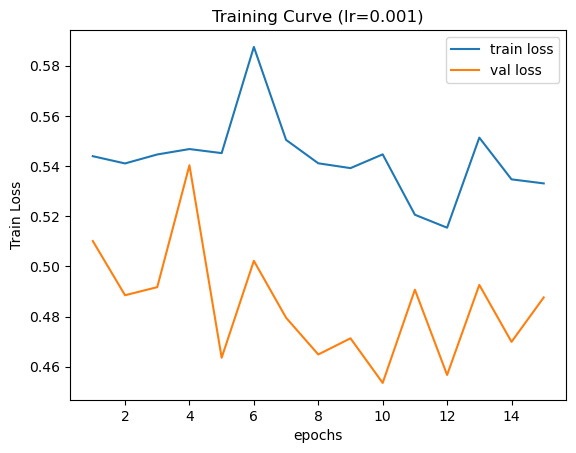

In [105]:
print("Plot of loss with epochs")
plt.plot(range(1, n_trained_epochs+1), train_avg_loss, label="train loss")
plt.plot(range(1, n_trained_epochs+1), val_avg_loss, label="val loss")
plt.title("Training Curve (lr={})".format(lr))
plt.xlabel("epochs")
plt.ylabel("Train Loss")
plt.legend(loc="best")
plt.show()

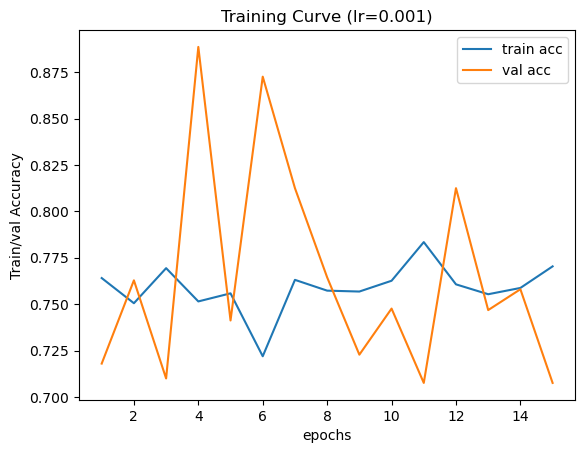

In [106]:
plt.plot(range(1, n_trained_epochs+1), train_avg_acc, label="train acc")
plt.plot(range(1, n_trained_epochs+1), val_avg_acc, label="val acc")
plt.title("Training Curve (lr={})".format(lr))
plt.xlabel("epochs")
plt.ylabel("Train/val Accuracy")
plt.legend(loc="best")
plt.show()

In [111]:
!ls model-causal-model/

model_0_finetuned-35-epochs-lr_0.001.pth
model_1_finetuned-35-epochs-lr_0.001.pth
model_2_finetuned-30-epochs-lr_0.001.pth
model_3_finetuned-0-epochs-lr_0.001.pth
model_3_finetuned-1-epochs-lr_0.001.pth
model_3_finetuned--3-epochs-lr_0.001.pth
model_3_finetuned--4-epochs-lr_0.001.pth
model_3_finetuned-5-epochs-lr_0.001.pth


In [117]:
ls ./model-causal-model/model_3_finetuned-5-epochs-lr_0.001.pth

./model-causal-model/model_3_finetuned-5-epochs-lr_0.001.pth


In [27]:
## saving the model 
# torch.save(model.state_dict(), "finetuned-35-epochs-1e3-lr-with-weighted-loss.pth") # early stopping saves model

### Load the model 
- if train and wants to evaluate: jsut use the `sameModelName`
- if want to laod a specific model - use next cell and write in double quote

In [107]:
# model_name = str(saveModelName)
# print(model_name)

./model-causal-model/model_3_finetuned-10-epochs-lr_0.001.pth


In [118]:

model_name = "./model-causal-model/model_3_finetuned-5-epochs-lr_0.001.pth"


In [119]:
# loading the locally saved model

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CausalityBERT()
model.load_state_dict(torch.load(model_name))
## Move the model to the GPU 
model.to(device)
model.eval() # gettign in the eval mode 



You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing BertModel: ['roberta.encoder.layer.6.attention.self.key.bias', 'roberta.encoder.layer.0.output.dense.bias', 'roberta.encoder.layer.1.attention.self.key.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.dense.bias', 'roberta.encoder.layer.2.attention.self.key.bias', 'roberta.encoder.layer.11.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.intermediate.dense.weight', 'roberta.encoder.layer.7.output.LayerNorm.weight', 'roberta.encoder.layer.1.intermediate.dense.bias', 'roberta.encoder.layer.9.attention.output.dense.weight', 'roberta.encoder.layer.9.attention.output.LayerNorm.bias', 'roberta.encoder.layer.9.attention.self.value.weight', 'roberta.encoder.layer.1.output.dense.weight', 'robe

CausalityBERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True

In [120]:
!ls ./model-causal-model/

model_0_finetuned-35-epochs-lr_0.001.pth
model_1_finetuned-35-epochs-lr_0.001.pth
model_2_finetuned-30-epochs-lr_0.001.pth
model_3_finetuned-0-epochs-lr_0.001.pth
model_3_finetuned-1-epochs-lr_0.001.pth
model_3_finetuned--3-epochs-lr_0.001.pth
model_3_finetuned--4-epochs-lr_0.001.pth
model_3_finetuned-5-epochs-lr_0.001.pth


## evaluation on the test dataset 



In [122]:
#loss_fn = CrossEntropyLoss()
test_loss = []
test_acc = []
test_prec = []
test_rec = []
test_f1 = []


for batch in tqdm(test_loader):
    batch = tuple(batch[t].to(device) for t in batch)      # batch to GPU
    b_input_ids, b_input_mask, b_token_type_ids, b_labels = batch     # unpack inputs from dataloader

    with torch.no_grad():
        model.eval()
        logits = model(**{"input_ids":b_input_ids, "attention_mask":b_input_mask, "token_type_ids":b_token_type_ids}) # forward pass, calculates logit predictions 
    
    # move logits and labels to CPU
    logits = logits.detach().to('cpu').numpy()
    label_ids = b_labels.to('cpu').numpy()

    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()
    
    metrics = compute_metrics(pred_flat, labels_flat)
    test_acc.append(metrics["accuracy"])
    test_prec.append(metrics["precision"])
    test_rec.append(metrics["recall"])
    test_f1.append(metrics["f1"])

    
print(F'\n\ttest loss: {np.mean(test_loss)}')
print(F'\n\ttest acc: {np.mean(test_acc)}')
print(F'\n\ttest prec: {np.mean(test_prec)}')
print(F'\n\ttest rec: {np.mean(test_rec)}')
print(F'\n\ttest f1: {np.mean(test_f1)}')





  0%|          | 0/77 [00:00<?, ?it/s]<ipython-input-91-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
  1%|▏         | 1/77 [00:01<01:31,  1.20s/it]<ipython-input-91-2d1ecdd7ffef>:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  , "labels" : torch.tensor(self.labels[idx], dtype=torch.long)
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 2/77 [00:02<01:28,  1.18s/it]<ipytho


	test loss: nan

	test acc: 0.6537569573283859

	test prec: 0.2376267311332246

	test rec: 0.6922077922077923

	test f1: 0.3369105090648253



/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vivek/miniconda3/envs/clue/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Print predictions of last test set batch:

In [123]:
# take last batch of test set:

for i in range(len(batch)):
    tokens = tokenizer.convert_ids_to_tokens(b_input_ids[i])
    print("\nPadded Sentence:")
    print(tokens)
    print("prediction:", pred_flat[i])
    


Padded Sentence:
['<s>', '@USER', 'Hey', 'Chee@@', 'to', 'man', ',', 'I', 'am', 'older', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
prediction: 0

Padded Sentence:
['<s>', 'My', 'body', 'almost', 'went', 'into', 'diabetic', 'coma', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '

In [124]:
# add seed => check
# add binary accuracy  => ???????
# add plot loss function accuracy => validation accu

# y - axis: loss function; validation accuracy
# x - axis: epochs


# epochs, learning rate => ok

# 90% training => 10% test  => ok
# how to use random batch of training set for validation

# clean notebook

# clean data sheet => check

# Check Pytorch: EarlyStopping add => check